In [1]:
import openpyxl
from sklearn import svm
import xlrd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from translate import Translator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.optimize import minimize
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection
from sklearn.metrics import r2_score
import time

if not os.path.exists('Output'):
    os.makedirs('Output')
if not os.path.exists('min'):
    os.makedirs('min')
def train(model, x_train, y_train):
    model.fit(x_train, y_train.ravel())
def print_accuracy(model, x_train, y_train, x_test, y_test):
    print('SVM-输出训练集的准确率为:', model.score(x_train, y_train))
    print("SVM-输出测试集的准确率为:", model.score(x_test, y_test))
    # 原始结果与预测结果进行对比
    show_accuracy(model.predict(x_train), y_train, 'traing data')
    show_accuracy(model.predict(x_test), y_test, 'testing data')
    # 计算决策函数的值
    print('decision_function:\n', model.decision_function(x_train))

def show_accuracy(a, b, tip):
    acc = (a.ravel() == b.ravel())
    print("%s Accuracy:%.3f" % (tip, np.mean(acc)))

buy_threshold =0.08
sell_threshold =0.05

#'交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元'
# 设置相对路径
data_path = "./data"              ###股票十年历史数据所在文件夹
max_longs = 2000                    ####总日期长度
SF='FCNN神经网络'
translator = Translator(from_lang='zh', to_lang='en')
SF = translator.translate(SF)
# 创建空DataFrame来存储所有表格的数据
all_data = pd.DataFrame()
row_index2 = ['total time(s)', 'total revenue(%)', 'train_accuracy', 'test_accuracy']
# 创建一个空的DataFrame
table2_data = pd.DataFrame(index=row_index2)
row_index = ['Longs=183','Longs=366','Longs=549','Longs=732','Longs=915','Longs=1098','Longs=1281','Longs=1464','Longs=1647']
# 创建一个空的DataFrame
table1_data = pd.DataFrame(index=row_index)
########################如果文件是一个，分成不同的工作表，以下代码是先将工作表分开##########
# 打开Excel文件
workbook = xlrd.open_workbook("data\\股票十年历史数据.xls")

# 遍历每个工作表
for sheet_name in workbook.sheet_names():
    # 选择工作表
    sheet = workbook.sheet_by_name(sheet_name)
    # 创建一个新的Excel文件
    new_workbook = openpyxl.Workbook()

    # 选择新的工作表，并将数据复制到该工作表中
    new_sheet = new_workbook.active
    new_sheet.title = sheet_name
    for row in range(sheet.nrows):
        for col in range(sheet.ncols):
            # 检查是否为“交易日期”列
            if sheet.cell_value(0, col) == "交易日期":
                # 如果是，则将单元格格式设置为日期时间格式
                cell = new_sheet.cell(row=row+1, column=col+1)
                cell.value = sheet.cell_value(row, col)
                cell.number_format = "yyyy/m/d h:mm:ss"
            else:
                # 如果不是，则直接复制单元格的值
                new_sheet.cell(row=row+1, column=col+1).value = sheet.cell_value(row, col)
    # 获取“证券简称”列第一个数据
    security_name = sheet.cell_value(1, 1)

    # 去除文件名中的非法字符
    for char in ["\\", "/", ":", "*", "?", "\"", "<", ">", "|"]:
        security_name = security_name.replace(char, "")

    # 将工作表保存到新的Excel文件中，并将文件命名为“证券简称”列第一个数据
    new_workbook.save(os.path.join("data", f"{security_name}.xls"))

    # # 将工作表保存到新的Excel文件中
    # new_workbook.save(os.path.join("data", f"{sheet_name}.xls"))
##########################################################################################   



# 遍历"data"文件夹中的所有文件
for filename in os.listdir(data_path):
    if filename == "股票十年历史数据.xls":
       # 如果文件名是"股票十年历史数据.xls"，则跳过该文件
        continue
    if filename.endswith(".xls"):
        filepath = os.path.join(data_path, filename)
        # 读取表格数据
        df = pd.read_excel(filepath)#####################################
        
        nameT = os.path.splitext(os.path.basename(filename))[0].split(' ')[0]
        nameT = translator.translate(nameT)
        start_time = time.time()
        time_list = []
        remark_list = []
        table2=[]
        def ff(longg):
            Longs=longg
            name=filepath
            TEXTname=name
            # 读取 XLS 文件
            df = pd.read_excel(name)
            df = df.iloc[-Longs:]
            # 选择需要的列并创建新的DataFrame
            data = df[['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']]
            dataL = data.set_index('交易日期')
            dataV= data
            # 重新命名列
            data.columns = ['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']
            df=data
            # 数据清洗
            df = df.drop_duplicates()  # 去重
            # 缺失值处理
            df = df.fillna(method='ffill')  # 用前一行的值填充缺失值
            # 异常值处理
            df = df[df['成交数量@单位：股'] > 0]  # 去除成交数量为负的数据
            # 特征工程
            df['涨跌幅'] = (df['最近成交'] - df['昨日收盘']) / df['昨日收盘']  # 计算涨跌幅
            dddate=df##后面画图还要用到日期，这里先保留在ddate里
            # 删除无用的特征
            df = df.drop(columns=['交易日期', '最近成交', '成交金额(人民币)@单位：元'])  
            # 数据标准化z = (x - u) / s：均值归零，方差化1
            scaler = StandardScaler()
            df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

            # 将数据分为特征和标签；自变量因变量
            X = df_scaled.drop(columns=['涨跌幅'])
            y = df_scaled[['涨跌幅']]

            # 将数据分为训练集和测试集
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # 构建CNN模型
            model = keras.Sequential([
                layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
                layers.Dense(64, activation='relu'),
                layers.Dense(1)
            ])
            model.compile(loss='mean_squared_error', optimizer='adam')

            # 训练模型
            model.fit(X_train, y_train, epochs=100, validation_split=0.2)
            # 在训练集和测试集上预测结果###########训练完成
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # 将预测结果映射为二分类结果（涨或跌）
            y_train_pred_binary = np.where(y_train_pred > 0, 1, 0)
            y_test_pred_binary = np.where(y_test_pred > 0, 1, 0)
            y_train_binary = np.where(y_train > 0, 1, 0)
            y_test_binary = np.where(y_test > 0, 1, 0)
            # 计算并输出准确率
            train_acc = accuracy_score(y_train_binary, y_train_pred_binary)
            test_acc = accuracy_score(y_test_binary, y_test_pred_binary)
            print("Train accuracy:", train_acc)
            print("Test accuracy:", test_acc)


            X1=X.iloc[:366,:]
            y_pred = model.predict(X1)
            yy = pd.DataFrame(y_pred, columns=[ '涨跌幅'])

            # RR=r2_score(y, y_pred)##R平方值
            # print(f'R平方值={RR}')
            # history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


            y_pred=yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
            df_scaled['策略'] = yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
            dataV2= dataV.iloc[:366, :]
            df_selected= df_scaled.iloc[:366, :]


            df_selected.index=df_selected.index+len(dddate)-Longs
            df_selected['今日开盘']=dataV2['今日开盘']

            # 初始化买入价格和买入索引
            buy_price = None
            buy_index = None

            # 初始化收益率和策略列表
            profits = []
            strategies = []
            for i, row in df_selected.iterrows():
                if y_pred[i-len(dddate)+Longs] == 1:
                    # 买入策略
                    buy_price = row['今日开盘']
                    buy_index = i
                    buy_cishu=1
                    profits.append(0)
                    strategies.append('买进')
                else:
                    # 卖出策略
                    if buy_price is not None:
                            profit = (row['今日开盘']*buy_cishu - buy_price) / (buy_price)
                            profits.append(profit)
                            strategies.append('卖出')
                            buy_price=None
                            buy_cishu=0
                    else:
                            # 如果当前没有持仓，就继续观望
                            profits.append(0)
                            strategies.append('持有')



            # 将收益率和策略列表添加到数据框中
            df_selected['收益率'] = profits
            df_selected['策略'] = strategies
            sum_B1 = df_selected['收益率'].sum()
            print(sum_B1)
            sum_B_list.append(float(sum_B1))
            return sum_B1

        sum_B_list = []
        # 定义参数的可能取值范围###############################
        min_longs = 1
        max_longs = 1800
        Longs_range = [i for i in range(min_longs, max_longs+1) if i % 183 == 0]

        # 初始化最大输出和对应的参数值
        max_mean = -np.inf
        best_Longs = None

        # 遍历所有可能的参数值
        for Longs in Longs_range:
            # 计算当前参数值对应的输出
            output = ff(Longs)
            
            # 如果当前输出比最大输出更大，则更新最大输出和对应的参数值
            if output > max_mean:
                max_mean = output
                best_Longs = Longs
        ########################################################

        Longs=best_Longs
        name=filepath
        TEXTname=name
        # 读取 XLS 文件
        df = pd.read_excel(name)
        dddate=df##后面画图还要用到日期，这里先保留在ddate里
        df = df.iloc[-Longs:]
        # 选择需要的列并创建新的DataFrame
        data = df[['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']]
        dataL = data.set_index('交易日期')
        dataV= data
        # 重新命名列
        data.columns = ['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']
        df=data
        # 数据清洗
        df = df.drop_duplicates()  # 去重
        # 缺失值处理
        df = df.fillna(method='ffill')  # 用前一行的值填充缺失值
        # 异常值处理
        df = df[df['成交数量@单位：股'] > 0]  # 去除成交数量为负的数据
        # 特征工程
        df['涨跌幅'] = (df['最近成交'] - df['昨日收盘']) / df['昨日收盘']  # 计算涨跌幅

        # 删除无用的特征
        df = df.drop(columns=['交易日期', '最近成交', '成交金额(人民币)@单位：元'])  
        # 数据标准化z = (x - u) / s：均值归零，方差化1
        scaler = StandardScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

        # 将数据分为特征和标签；自变量因变量
        X = df_scaled.drop(columns=['涨跌幅'])
        y = df_scaled[['涨跌幅']]

        # 将数据分为训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 构建CNN模型
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(loss='mean_squared_error', optimizer='adam')

        # 训练模型
        model.fit(X_train, y_train, epochs=100, validation_split=0.2)
        # 在训练集和测试集上预测结果###########训练完成
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # 将预测结果映射为二分类结果（涨或跌）
        y_train_pred_binary = np.where(y_train_pred > 0, 1, 0)
        y_test_pred_binary = np.where(y_test_pred > 0, 1, 0)
        y_train_binary = np.where(y_train > 0, 1, 0)
        y_test_binary = np.where(y_test > 0, 1, 0)
        # 计算并输出准确率
        train_acc = accuracy_score(y_train_binary, y_train_pred_binary)
        test_acc = accuracy_score(y_test_binary, y_test_pred_binary)
        print("Train accuracy:", train_acc)
        print("Test accuracy:", test_acc)


        X1=X.iloc[:366,:]
        y_pred = model.predict(X1)
        yy = pd.DataFrame(y_pred, columns=[ '涨跌幅'])

        # RR=r2_score(y, y_pred)##R平方值
        # print(f'R平方值={RR}')
        # history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


        y_pred=yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
        df_scaled['策略'] = yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
        dataV2= dataV.iloc[-366:, :]
        df_selected= df_scaled.iloc[:366, :]

        df_selected.index=df_selected.index+len(dddate)-Longs
        df_selected['今日开盘']=dataV2['今日开盘']

        # 初始化买入价格和买入索引
        buy_price = None
        buy_index = None

        # 初始化收益率和策略列表
        profits = []
        strategies = []

        for i, row in df_selected.iterrows():
            if y_pred[i-len(dddate)+Longs] == 1:
                # 买入策略
                buy_price = row['今日开盘']
                buy_index = i
                buy_cishu=1
                profits.append(0)
                strategies.append('买进')
            else:
                # 卖出策略
                if buy_price is not None:
                        profit = (row['今日开盘']*buy_cishu - buy_price) / (buy_price)
                        profits.append(profit)
                        strategies.append('卖出')
                        buy_price=None
                        buy_cishu=0
                else:
                        # 如果当前没有持仓，就继续观望
                        profits.append(0)
                        strategies.append('持有')



        # 将收益率和策略列表添加到数据框中
        df_selected['收益率'] = profits
        df_selected['策略'] = strategies
        sum_B = df_selected['收益率'].sum()
        print(sum_B)

        ddate=df_selected

        ddate['交易日期']=dddate['交易日期']
        ddate['最近成交']=dddate['最近成交']
        # ddate['策略'] = ddate['策略'].replace({'卖出': '买入', '买入': '卖出'})###买进卖出互换

        avg_ddate = ddate.groupby('交易日期')['最近成交'].mean()
        # 选择买入和卖出点的数据
        buy_points = ddate.loc[ddate['策略'] == '买进']
        sell_points = ddate.loc[ddate['策略'] == '卖出']
        # 绘制折线图和散点图
        plt.plot(avg_ddate.index, avg_ddate.values, label='stock price')
        plt.scatter(buy_points['交易日期'], buy_points['最近成交'], marker='v', color='red', label='Buy')
        plt.scatter(sell_points['交易日期'], sell_points['最近成交'], marker='^', color='green', label='Sell')
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{nameT}-Optimal trading point and stock price')
        # 显示折线图和散点图
        plt.savefig(f'Output/{nameT}-最优交易点与股票价格.png', bbox_inches='tight')
        plt.legend()
        plt.show()
        dd = ddate[['交易日期','策略']]
        dd.to_csv(f'Output/{nameT}-决策方案.csv',index=False)
        # 打印列B的总和
        print(f"{nameT}总收益率为:", sum_B)



        end_time = time.time()
        elapsed_time = end_time - start_time


        # 将table作为一列添加到DataFrame中
        table1_data[f'{nameT}'] = sum_B_list




        table2.append(elapsed_time)
        table2.append(sum_B)
        table2.append(train_acc)
        table2.append(test_acc)



        # 将table作为一列添加到DataFrame中
        table2_data[f'{nameT}'] = table2

        all_data.loc[nameT, "Yield"] = sum_B

# 可视化
all_data.to_csv('Output/各个股票的模拟收益率.csv')
all_data = pd.DataFrame(all_data)

# 绘制柱形图
ax = all_data.plot(kind='bar', figsize=(10, 6), rot=0)

# 添加详细纵坐标
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.xticks(rotation=45)
plt.title('Simulated yield of each stock')
plt.savefig(f'Output/{filename}-各个股票的模拟收益率.png', bbox_inches='tight')
plt.legend()
plt.show()
mean = all_data.mean().mean()
print(f'Simulated average yield of each stock:{mean}')
all_data.to_csv('Output/各个股票的模拟收益率.csv')
all_data = pd.DataFrame(all_data)

# 绘制柱形图
ax = all_data.plot(kind='bar', figsize=(10, 6), rot=0)

# 添加详细纵坐标
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.xticks(rotation=45)
plt.title(f'base {SF}`s Simulated average yield of each stock:{mean}')
plt.savefig(f'基于{SF}模型的股票总收益率.png', bbox_inches='tight')
plt.legend()
plt.show()
# 创建一个Styler对象
table1_data = table1_data.style

# 将每一列的最大值用红色字体标注
table1_data.highlight_max(color='red')
with pd.ExcelWriter(f'Output/基于{SF}模型的训练时长分析.xlsx') as writer:
    table1_data.to_excel(writer, index=True, sheet_name='数据')
# 创建一个Styler对象

#table1_data.to_csv(f'基于{SF}模型的训练时长分析.csv')
table2_data.to_csv(f'Output/基于{SF}模型的结果表.csv')

Duplicate key in file WindowsPath('c:/Users/Administrator/venv/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 263 ('font.family: Microsoft YaHei')


ConnectionError: HTTPConnectionPool(host='api.mymemory.translated.net', port=80): Max retries exceeded with url: /get?q=ST%E5%AE%9C%E7%BA%B8&langpair=zh%7Cen (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001D79C18CBE0>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))

Epoch 1/100
4/4 [==============================] - 0s 46ms/step - loss: 0.8909 - val_loss: 0.9799
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8035 - val_loss: 0.8858
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7777 - val_loss: 0.8485
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7596 - val_loss: 0.8326
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7289 - val_loss: 0.8211
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7015 - val_loss: 0.8215
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6748 - val_loss: 0.8234
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6547 - val_loss: 0.8273
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6293 - val_loss: 0.8102
Epoch 10/100
4/4 [==============================] - 0s 18ms/step - loss: 0.6075 - val_loss: 0.7714
Epoch 11/100
4/4 [==

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 1s 10ms/step - loss: 1.0463 - val_loss: 0.8795
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.9223 - val_loss: 0.8763
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8710 - val_loss: 0.8329
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.8348 - val_loss: 0.8105
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7917 - val_loss: 0.7689
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7548 - val_loss: 0.7381
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7137 - val_loss: 0.6677
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 0.6483 - val_loss: 0.6232
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.5808 - val_loss: 0.5462
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.5122 - val_loss: 0.4723
Epoch 11

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 1.0333 - val_loss: 1.2577
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9241 - val_loss: 1.2155
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8967 - val_loss: 1.1713
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8583 - val_loss: 1.1174
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8211 - val_loss: 1.0576
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7897 - val_loss: 1.0249
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.7249 - val_loss: 0.9140
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.6928 - val_loss: 0.8591
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6129 - val_loss: 0.7646
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.5339 - val_loss: 0.7118
Epoch 11/

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 7ms/step - loss: 1.0625 - val_loss: 1.0823
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9664 - val_loss: 1.1102
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9494 - val_loss: 1.0601
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9131 - val_loss: 1.0539
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8805 - val_loss: 0.9889
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8443 - val_loss: 0.9678
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7972 - val_loss: 0.8892
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7372 - val_loss: 0.8237
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 0.6501 - val_loss: 0.7720
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5466 - val_loss: 0.6808
Epoch 11/

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 6ms/step - loss: 0.9480 - val_loss: 1.0448
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9082 - val_loss: 1.0403
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8794 - val_loss: 1.0203
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8425 - val_loss: 0.9956
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8129 - val_loss: 0.9652
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.7673 - val_loss: 0.9634
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 0.7233 - val_loss: 0.9037
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.6590 - val_loss: 0.8762
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.5925 - val_loss: 0.7490
Epoch 10/100
26/26 [==============================] - 0s 4ms/step - loss: 0.5352 - val_loss: 0.7164
Epoch 11/

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
30/30 [==============================] - 0s 5ms/step - loss: 1.1174 - val_loss: 0.8822
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 1.0670 - val_loss: 0.8441
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 1.0708 - val_loss: 0.8938
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 1.0448 - val_loss: 0.8818
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 1.0293 - val_loss: 0.8538
Epoch 6/100
30/30 [==============================] - 0s 2ms/step - loss: 1.0187 - val_loss: 0.8099
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9931 - val_loss: 0.8614
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9826 - val_loss: 0.7801
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9256 - val_loss: 0.7815
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9138 - val_loss: 0.6825
Epoch 11/

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 1s 6ms/step - loss: 1.0224 - val_loss: 1.0949
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9895 - val_loss: 1.0251
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9757 - val_loss: 1.0208
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9673 - val_loss: 1.0075
Epoch 5/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9601 - val_loss: 0.9886
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9440 - val_loss: 0.9659
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9293 - val_loss: 0.9671
Epoch 8/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9219 - val_loss: 0.9577
Epoch 9/100
33/33 [==============================] - 0s 2ms/step - loss: 0.8895 - val_loss: 0.9497
Epoch 10/100
33/33 [==============================] - 0s 2ms/step - loss: 0.8712 - val_loss: 0.8987
Epoch 11/

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 37ms/step - loss: 1.2188 - val_loss: 1.2275
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 1.0042 - val_loss: 1.0869
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8457 - val_loss: 1.0385
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7734 - val_loss: 1.0323
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7647 - val_loss: 1.0543
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: 0.7462 - val_loss: 1.0551
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7291 - val_loss: 1.0042
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7005 - val_loss: 0.9408
Epoch 9/100
4/4 [==============================] - 0s 18ms/step - loss: 0.6704 - val_loss: 0.8877
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6428 - val_loss: 0.8484
Epoch 11/100
4/4 [=

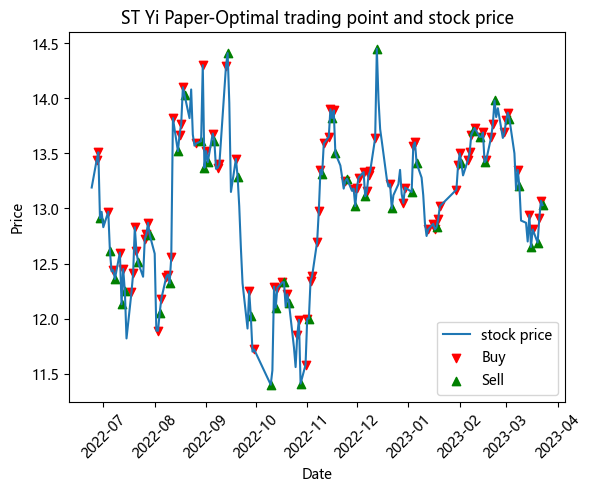

ST Yi Paper总收益率为: 0.7741282266228968
Epoch 1/100
4/4 [==============================] - 0s 38ms/step - loss: 1.0748 - val_loss: 1.4767
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9567 - val_loss: 1.2752
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8928 - val_loss: 1.1272
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 0.8351 - val_loss: 1.0020
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7928 - val_loss: 0.9142
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7602 - val_loss: 0.8423
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7187 - val_loss: 0.8219
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6923 - val_loss: 0.8195
Epoch 9/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6554 - val_loss: 0.7826
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6274 -

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 9ms/step - loss: 0.9344 - val_loss: 1.0729
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.8759 - val_loss: 1.0454
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.8387 - val_loss: 0.9984
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7968 - val_loss: 0.9349
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7642 - val_loss: 0.8909
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7174 - val_loss: 0.8823
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6764 - val_loss: 0.7889
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6097 - val_loss: 0.6738
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: 0.5608 - val_loss: 0.6755
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.4703 - val_loss: 0.5116
Epoch 11/

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 8ms/step - loss: 1.1001 - val_loss: 0.6328
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 1.0415 - val_loss: 0.6441
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0212 - val_loss: 0.6118
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.9909 - val_loss: 0.5902
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9538 - val_loss: 0.5582
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9107 - val_loss: 0.5432
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8675 - val_loss: 0.5076
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8143 - val_loss: 0.4669
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7609 - val_loss: 0.4495
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6959 - val_loss: 0.3944
Epoch 11/

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 1.0084 - val_loss: 0.9842
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9658 - val_loss: 0.9531
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9392 - val_loss: 0.9343
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9141 - val_loss: 0.9190
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8746 - val_loss: 0.8857
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8376 - val_loss: 0.8266
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7979 - val_loss: 0.7865
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7392 - val_loss: 0.7563
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 0.6648 - val_loss: 0.6668
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 0.5805 - val_loss: 0.5754
Epoch 11/

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 6ms/step - loss: 1.0097 - val_loss: 1.0032
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9767 - val_loss: 0.9734
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9676 - val_loss: 0.9714
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9521 - val_loss: 0.9417
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 0.9415 - val_loss: 0.9476
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9183 - val_loss: 0.9114
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9054 - val_loss: 0.9053
Epoch 8/100
26/26 [==============================] - 0s 2ms/step - loss: 0.8838 - val_loss: 0.8836
Epoch 9/100
26/26 [==============================] - 0s 2ms/step - loss: 0.8709 - val_loss: 0.8508
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8507 - val_loss: 0.8312
Epoch 11/

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
30/30 [==============================] - 1s 6ms/step - loss: 0.9285 - val_loss: 1.0157
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9031 - val_loss: 1.0096
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8975 - val_loss: 1.0052
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8974 - val_loss: 1.0051
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8904 - val_loss: 0.9902
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8856 - val_loss: 0.9743
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8896 - val_loss: 0.9909
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8667 - val_loss: 0.9945
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8524 - val_loss: 0.9613
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8345 - val_loss: 0.9433
Epoch 11/

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 0s 5ms/step - loss: 1.0419 - val_loss: 0.9837
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0143 - val_loss: 0.9609
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0078 - val_loss: 0.9428
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9982 - val_loss: 0.9451
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9997 - val_loss: 0.9762
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9924 - val_loss: 0.9453
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9832 - val_loss: 0.9561
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9724 - val_loss: 0.9168
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9620 - val_loss: 0.9133
Epoch 10/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9639 - val_loss: 0.9383
Epoch 11/

<ipython-input-2-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-2-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-2-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 39ms/step - loss: 1.1119 - val_loss: 0.9699
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.9408 - val_loss: 0.9928
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8665 - val_loss: 1.0125
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8489 - val_loss: 1.0080
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8265 - val_loss: 0.9599
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.7898 - val_loss: 0.8887
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7568 - val_loss: 0.8127
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7263 - val_loss: 0.7677
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7048 - val_loss: 0.7191
Epoch 10/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6795 - val_loss: 0.6921
Epoch 11/100
4/4 [==

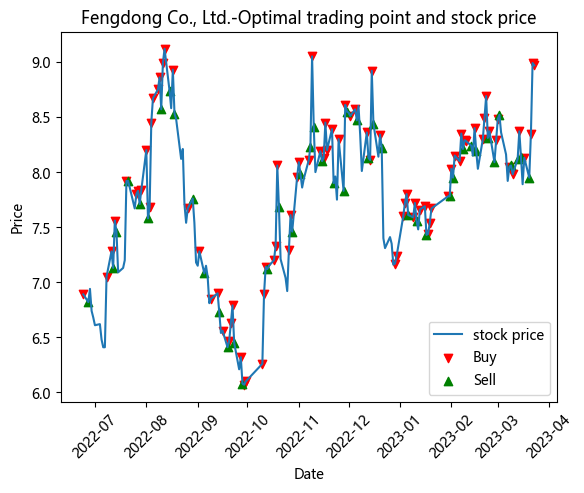

Fengdong Co., Ltd.总收益率为: 1.1215237060180385


ConnectionError: HTTPConnectionPool(host='api.mymemory.translated.net', port=80): Max retries exceeded with url: /get?q=%E4%BC%A0%E6%99%BA%E6%95%99%E8%82%B2&langpair=zh%7Cen (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001D79A7D6310>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))

In [2]:
import openpyxl
from sklearn import svm
import xlrd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from translate import Translator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.optimize import minimize
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection
from sklearn.metrics import r2_score
import time

if not os.path.exists('Output'):
    os.makedirs('Output')
if not os.path.exists('min'):
    os.makedirs('min')
def train(model, x_train, y_train):
    model.fit(x_train, y_train.ravel())
def print_accuracy(model, x_train, y_train, x_test, y_test):
    print('SVM-输出训练集的准确率为:', model.score(x_train, y_train))
    print("SVM-输出测试集的准确率为:", model.score(x_test, y_test))
    # 原始结果与预测结果进行对比
    show_accuracy(model.predict(x_train), y_train, 'traing data')
    show_accuracy(model.predict(x_test), y_test, 'testing data')
    # 计算决策函数的值
    print('decision_function:\n', model.decision_function(x_train))

def show_accuracy(a, b, tip):
    acc = (a.ravel() == b.ravel())
    print("%s Accuracy:%.3f" % (tip, np.mean(acc)))

buy_threshold =0.08
sell_threshold =0.05

#'交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元'
# 设置相对路径
data_path = "./data"              ###股票十年历史数据所在文件夹
max_longs = 2000                    ####总日期长度
SF='FCNN神经网络'
translator = Translator(from_lang='zh', to_lang='en')
SF = translator.translate(SF)
# 创建空DataFrame来存储所有表格的数据
all_data = pd.DataFrame()
row_index2 = ['total time(s)', 'total revenue(%)', 'train_accuracy', 'test_accuracy']
# 创建一个空的DataFrame
table2_data = pd.DataFrame(index=row_index2)
row_index = ['Longs=183','Longs=366','Longs=549','Longs=732','Longs=915','Longs=1098','Longs=1281','Longs=1464','Longs=1647']
# 创建一个空的DataFrame
table1_data = pd.DataFrame(index=row_index)
########################如果文件是一个，分成不同的工作表，以下代码是先将工作表分开##########
# 打开Excel文件
workbook = xlrd.open_workbook("data\\股票十年历史数据.xls")

# 遍历每个工作表
for sheet_name in workbook.sheet_names():
    # 选择工作表
    sheet = workbook.sheet_by_name(sheet_name)
    # 创建一个新的Excel文件
    new_workbook = openpyxl.Workbook()

    # 选择新的工作表，并将数据复制到该工作表中
    new_sheet = new_workbook.active
    new_sheet.title = sheet_name
    for row in range(sheet.nrows):
        for col in range(sheet.ncols):
            # 检查是否为“交易日期”列
            if sheet.cell_value(0, col) == "交易日期":
                # 如果是，则将单元格格式设置为日期时间格式
                cell = new_sheet.cell(row=row+1, column=col+1)
                cell.value = sheet.cell_value(row, col)
                cell.number_format = "yyyy/m/d h:mm:ss"
            else:
                # 如果不是，则直接复制单元格的值
                new_sheet.cell(row=row+1, column=col+1).value = sheet.cell_value(row, col)
    # 获取“证券简称”列第一个数据
    security_name = sheet.cell_value(1, 1)

    # 去除文件名中的非法字符
    for char in ["\\", "/", ":", "*", "?", "\"", "<", ">", "|"]:
        security_name = security_name.replace(char, "")

    # 将工作表保存到新的Excel文件中，并将文件命名为“证券简称”列第一个数据
    new_workbook.save(os.path.join("data", f"{security_name}.xls"))

    # # 将工作表保存到新的Excel文件中
    # new_workbook.save(os.path.join("data", f"{sheet_name}.xls"))
##########################################################################################   



# 遍历"data"文件夹中的所有文件
for filename in os.listdir(data_path):
    if filename == "股票十年历史数据.xls":
       # 如果文件名是"股票十年历史数据.xls"，则跳过该文件
        continue
    if filename.endswith(".xls"):
        filepath = os.path.join(data_path, filename)
        # 读取表格数据
        df = pd.read_excel(filepath)#####################################
        
        nameT = os.path.splitext(os.path.basename(filename))[0].split(' ')[0]
        nameT = translator.translate(nameT)
        start_time = time.time()
        time_list = []
        remark_list = []
        table2=[]
        def ff(longg):
            Longs=longg
            name=filepath
            TEXTname=name
            # 读取 XLS 文件
            df = pd.read_excel(name)
            df = df.iloc[-Longs:]
            # 选择需要的列并创建新的DataFrame
            data = df[['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']]
            dataL = data.set_index('交易日期')
            dataV= data
            # 重新命名列
            data.columns = ['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']
            df=data
            # 数据清洗
            df = df.drop_duplicates()  # 去重
            # 缺失值处理
            df = df.fillna(method='ffill')  # 用前一行的值填充缺失值
            # 异常值处理
            df = df[df['成交数量@单位：股'] > 0]  # 去除成交数量为负的数据
            # 特征工程
            df['涨跌幅'] = (df['最近成交'] - df['昨日收盘']) / df['昨日收盘']  # 计算涨跌幅
            dddate=df##后面画图还要用到日期，这里先保留在ddate里
            # 删除无用的特征
            df = df.drop(columns=['交易日期', '最近成交', '成交金额(人民币)@单位：元'])  
            # 数据标准化z = (x - u) / s：均值归零，方差化1
            scaler = StandardScaler()
            df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

            # 将数据分为特征和标签；自变量因变量
            X = df_scaled.drop(columns=['涨跌幅'])
            y = df_scaled[['涨跌幅']]

            # 将数据分为训练集和测试集
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # 构建CNN模型
            model = keras.Sequential([
                layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
                layers.Dense(64, activation='relu'),
                layers.Dense(1)
            ])
            model.compile(loss='mean_squared_error', optimizer='adam')

            # 训练模型
            model.fit(X_train, y_train, epochs=100, validation_split=0.2)
            # 在训练集和测试集上预测结果###########训练完成
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # 将预测结果映射为二分类结果（涨或跌）
            y_train_pred_binary = np.where(y_train_pred > 0, 1, 0)
            y_test_pred_binary = np.where(y_test_pred > 0, 1, 0)
            y_train_binary = np.where(y_train > 0, 1, 0)
            y_test_binary = np.where(y_test > 0, 1, 0)
            # 计算并输出准确率
            train_acc = accuracy_score(y_train_binary, y_train_pred_binary)
            test_acc = accuracy_score(y_test_binary, y_test_pred_binary)
            print("Train accuracy:", train_acc)
            print("Test accuracy:", test_acc)


            X1=X.iloc[:366,:]
            y_pred = model.predict(X1)
            yy = pd.DataFrame(y_pred, columns=[ '涨跌幅'])

            # RR=r2_score(y, y_pred)##R平方值
            # print(f'R平方值={RR}')
            # history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


            y_pred=yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
            df_scaled['策略'] = yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
            dataV2= dataV.iloc[:366, :]
            df_selected= df_scaled.iloc[:366, :]


            df_selected.index=df_selected.index+len(dddate)-Longs
            df_selected['今日开盘']=dataV2['今日开盘']

            # 初始化买入价格和买入索引
            buy_price = None
            buy_index = None

            # 初始化收益率和策略列表
            profits = []
            strategies = []
            for i, row in df_selected.iterrows():
                if y_pred[i-len(dddate)+Longs] == 1:
                    # 买入策略
                    buy_price = row['今日开盘']
                    buy_index = i
                    buy_cishu=1
                    profits.append(0)
                    strategies.append('买进')
                else:
                    # 卖出策略
                    if buy_price is not None:
                            profit = (row['今日开盘']*buy_cishu - buy_price) / (buy_price)
                            profits.append(profit)
                            strategies.append('卖出')
                            buy_price=None
                            buy_cishu=0
                    else:
                            # 如果当前没有持仓，就继续观望
                            profits.append(0)
                            strategies.append('持有')



            # 将收益率和策略列表添加到数据框中
            df_selected['收益率'] = profits
            df_selected['策略'] = strategies
            sum_B1 = df_selected['收益率'].sum()
            print(sum_B1)
            sum_B_list.append(float(sum_B1))
            return sum_B1

        sum_B_list = []
        # 定义参数的可能取值范围###############################
        min_longs = 1
        max_longs = 1800
        Longs_range = [i for i in range(min_longs, max_longs+1) if i % 183 == 0]

        # 初始化最大输出和对应的参数值
        max_mean = -np.inf
        best_Longs = None

        # 遍历所有可能的参数值
        for Longs in Longs_range:
            # 计算当前参数值对应的输出
            output = ff(Longs)
            
            # 如果当前输出比最大输出更大，则更新最大输出和对应的参数值
            if output > max_mean:
                max_mean = output
                best_Longs = Longs
        ########################################################

        Longs=best_Longs
        name=filepath
        TEXTname=name
        # 读取 XLS 文件
        df = pd.read_excel(name)
        dddate=df##后面画图还要用到日期，这里先保留在ddate里
        df = df.iloc[-Longs:]
        # 选择需要的列并创建新的DataFrame
        data = df[['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']]
        dataL = data.set_index('交易日期')
        dataV= data
        # 重新命名列
        data.columns = ['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']
        df=data
        # 数据清洗
        df = df.drop_duplicates()  # 去重
        # 缺失值处理
        df = df.fillna(method='ffill')  # 用前一行的值填充缺失值
        # 异常值处理
        df = df[df['成交数量@单位：股'] > 0]  # 去除成交数量为负的数据
        # 特征工程
        df['涨跌幅'] = (df['最近成交'] - df['昨日收盘']) / df['昨日收盘']  # 计算涨跌幅

        # 删除无用的特征
        df = df.drop(columns=['交易日期', '最近成交', '成交金额(人民币)@单位：元'])  
        # 数据标准化z = (x - u) / s：均值归零，方差化1
        scaler = StandardScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

        # 将数据分为特征和标签；自变量因变量
        X = df_scaled.drop(columns=['涨跌幅'])
        y = df_scaled[['涨跌幅']]

        # 将数据分为训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 构建CNN模型
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(loss='mean_squared_error', optimizer='adam')

        # 训练模型
        model.fit(X_train, y_train, epochs=100, validation_split=0.2)
        # 在训练集和测试集上预测结果###########训练完成
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # 将预测结果映射为二分类结果（涨或跌）
        y_train_pred_binary = np.where(y_train_pred > 0, 1, 0)
        y_test_pred_binary = np.where(y_test_pred > 0, 1, 0)
        y_train_binary = np.where(y_train > 0, 1, 0)
        y_test_binary = np.where(y_test > 0, 1, 0)
        # 计算并输出准确率
        train_acc = accuracy_score(y_train_binary, y_train_pred_binary)
        test_acc = accuracy_score(y_test_binary, y_test_pred_binary)
        print("Train accuracy:", train_acc)
        print("Test accuracy:", test_acc)


        X1=X.iloc[:366,:]
        y_pred = model.predict(X1)
        yy = pd.DataFrame(y_pred, columns=[ '涨跌幅'])

        # RR=r2_score(y, y_pred)##R平方值
        # print(f'R平方值={RR}')
        # history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


        y_pred=yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
        df_scaled['策略'] = yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
        dataV2= dataV.iloc[-366:, :]
        df_selected= df_scaled.iloc[:366, :]

        df_selected.index=df_selected.index+len(dddate)-Longs
        df_selected['今日开盘']=dataV2['今日开盘']

        # 初始化买入价格和买入索引
        buy_price = None
        buy_index = None

        # 初始化收益率和策略列表
        profits = []
        strategies = []

        for i, row in df_selected.iterrows():
            if y_pred[i-len(dddate)+Longs] == 1:
                # 买入策略
                buy_price = row['今日开盘']
                buy_index = i
                buy_cishu=1
                profits.append(0)
                strategies.append('买进')
            else:
                # 卖出策略
                if buy_price is not None:
                        profit = (row['今日开盘']*buy_cishu - buy_price) / (buy_price)
                        profits.append(profit)
                        strategies.append('卖出')
                        buy_price=None
                        buy_cishu=0
                else:
                        # 如果当前没有持仓，就继续观望
                        profits.append(0)
                        strategies.append('持有')



        # 将收益率和策略列表添加到数据框中
        df_selected['收益率'] = profits
        df_selected['策略'] = strategies
        sum_B = df_selected['收益率'].sum()
        print(sum_B)

        ddate=df_selected

        ddate['交易日期']=dddate['交易日期']
        ddate['最近成交']=dddate['最近成交']
        # ddate['策略'] = ddate['策略'].replace({'卖出': '买入', '买入': '卖出'})###买进卖出互换

        avg_ddate = ddate.groupby('交易日期')['最近成交'].mean()
        # 选择买入和卖出点的数据
        buy_points = ddate.loc[ddate['策略'] == '买进']
        sell_points = ddate.loc[ddate['策略'] == '卖出']
        # 绘制折线图和散点图
        plt.plot(avg_ddate.index, avg_ddate.values, label='stock price')
        plt.scatter(buy_points['交易日期'], buy_points['最近成交'], marker='v', color='red', label='Buy')
        plt.scatter(sell_points['交易日期'], sell_points['最近成交'], marker='^', color='green', label='Sell')
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{nameT}-Optimal trading point and stock price')
        # 显示折线图和散点图
        plt.savefig(f'Output/{nameT}-最优交易点与股票价格.png', bbox_inches='tight')
        plt.legend()
        plt.show()
        dd = ddate[['交易日期','策略']]
        dd.to_csv(f'Output/{nameT}-决策方案.csv',index=False)
        # 打印列B的总和
        print(f"{nameT}总收益率为:", sum_B)



        end_time = time.time()
        elapsed_time = end_time - start_time


        # 将table作为一列添加到DataFrame中
        table1_data[f'{nameT}'] = sum_B_list




        table2.append(elapsed_time)
        table2.append(sum_B)
        table2.append(train_acc)
        table2.append(test_acc)



        # 将table作为一列添加到DataFrame中
        table2_data[f'{nameT}'] = table2

        all_data.loc[nameT, "Yield"] = sum_B

# 可视化
all_data.to_csv('Output/各个股票的模拟收益率.csv')
all_data = pd.DataFrame(all_data)

# 绘制柱形图
ax = all_data.plot(kind='bar', figsize=(10, 6), rot=0)

# 添加详细纵坐标
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.xticks(rotation=45)
plt.title('Simulated yield of each stock')
plt.savefig(f'Output/{filename}-各个股票的模拟收益率.png', bbox_inches='tight')
plt.legend()
plt.show()
mean = all_data.mean().mean()
print(f'Simulated average yield of each stock:{mean}')
all_data.to_csv('Output/各个股票的模拟收益率.csv')
all_data = pd.DataFrame(all_data)

# 绘制柱形图
ax = all_data.plot(kind='bar', figsize=(10, 6), rot=0)

# 添加详细纵坐标
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.xticks(rotation=45)
plt.title(f'base {SF}`s Simulated average yield of each stock:{mean}')
plt.savefig(f'基于{SF}模型的股票总收益率.png', bbox_inches='tight')
plt.legend()
plt.show()
# 创建一个Styler对象
table1_data = table1_data.style

# 将每一列的最大值用红色字体标注
table1_data.highlight_max(color='red')
with pd.ExcelWriter(f'Output/基于{SF}模型的训练时长分析.xlsx') as writer:
    table1_data.to_excel(writer, index=True, sheet_name='数据')
# 创建一个Styler对象

#table1_data.to_csv(f'基于{SF}模型的训练时长分析.csv')
table2_data.to_csv(f'Output/基于{SF}模型的结果表.csv')

Epoch 1/100
4/4 [==============================] - 0s 37ms/step - loss: 0.8612 - val_loss: 1.2149
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 0.7613 - val_loss: 1.0480
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7124 - val_loss: 0.9331
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6816 - val_loss: 0.8595
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6386 - val_loss: 0.8254
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5950 - val_loss: 0.8219
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.5607 - val_loss: 0.8234
Epoch 8/100
4/4 [==============================] - 0s 16ms/step - loss: 0.5350 - val_loss: 0.8215
Epoch 9/100
4/4 [==============================] - 0s 17ms/step - loss: 0.4963 - val_loss: 0.7527
Epoch 10/100
4/4 [==============================] - 0s 11ms/step - loss: 0.4574 - val_loss: 0.7055
Epoch 11/100
4/4 [===

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 1.0713 - val_loss: 0.8797
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.9555 - val_loss: 0.8735
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.8945 - val_loss: 0.8201
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8405 - val_loss: 0.7783
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7794 - val_loss: 0.7346
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7378 - val_loss: 0.6589
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6275 - val_loss: 0.6122
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.5343 - val_loss: 0.4898
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.4495 - val_loss: 0.3751
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.3678 - val_loss: 0.3014
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 8ms/step - loss: 0.9743 - val_loss: 1.2680
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9383 - val_loss: 1.2004
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9122 - val_loss: 1.1852
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8888 - val_loss: 1.1495
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.8640 - val_loss: 1.1028
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8443 - val_loss: 1.0874
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.8173 - val_loss: 1.0562
Epoch 8/100
19/19 [==============================] - 0s 5ms/step - loss: 0.7919 - val_loss: 1.0097
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 0.7373 - val_loss: 1.0007
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 0.6954 - val_loss: 0.9308
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 7ms/step - loss: 1.0120 - val_loss: 1.0970
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9511 - val_loss: 1.1125
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9125 - val_loss: 0.9984
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8682 - val_loss: 0.9981
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8304 - val_loss: 0.9161
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7776 - val_loss: 0.8592
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7193 - val_loss: 0.8355
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6442 - val_loss: 0.7113
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5642 - val_loss: 0.6478
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.4909 - val_loss: 0.5778
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 6ms/step - loss: 0.9561 - val_loss: 1.0448
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8996 - val_loss: 1.0321
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8777 - val_loss: 1.0205
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8647 - val_loss: 1.0031
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 0.8283 - val_loss: 0.9942
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7996 - val_loss: 0.9656
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 0.7529 - val_loss: 0.9407
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7132 - val_loss: 0.8794
Epoch 9/100
26/26 [==============================] - 0s 2ms/step - loss: 0.6477 - val_loss: 0.8229
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.5816 - val_loss: 0.7400
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
30/30 [==============================] - 0s 5ms/step - loss: 1.0801 - val_loss: 0.8881
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 1.0578 - val_loss: 0.8501
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 1.0467 - val_loss: 0.8641
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 1.0808 - val_loss: 0.8690
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 1.0310 - val_loss: 0.8436
Epoch 6/100
30/30 [==============================] - 0s 2ms/step - loss: 1.0490 - val_loss: 0.8905
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 1.0169 - val_loss: 0.8008
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9984 - val_loss: 0.7988
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 1.0159 - val_loss: 0.7755
Epoch 10/100
30/30 [==============================] - 0s 2ms/step - loss: 0.9639 - val_loss: 0.7968
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 0s 5ms/step - loss: 1.0173 - val_loss: 1.0193
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9814 - val_loss: 1.0090
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9634 - val_loss: 0.9832
Epoch 4/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9522 - val_loss: 0.9673
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9450 - val_loss: 0.9472
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9329 - val_loss: 0.9615
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9268 - val_loss: 0.9113
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.8990 - val_loss: 0.8945
Epoch 9/100
33/33 [==============================] - 0s 2ms/step - loss: 0.8530 - val_loss: 0.9050
Epoch 10/100
33/33 [==============================] - 0s 3ms/step - loss: 0.8851 - val_loss: 0.8350
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 34ms/step - loss: 0.8495 - val_loss: 0.9617
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7793 - val_loss: 0.8861
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7382 - val_loss: 0.8046
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 0.7003 - val_loss: 0.7347
Epoch 5/100
4/4 [==============================] - 0s 7ms/step - loss: 0.6737 - val_loss: 0.6748
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6460 - val_loss: 0.6323
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6094 - val_loss: 0.6181
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.5746 - val_loss: 0.6166
Epoch 9/100
4/4 [==============================] - 0s 7ms/step - loss: 0.5433 - val_loss: 0.6235
Epoch 10/100
4/4 [==============================] - 0s 10ms/step - loss: 0.5155 - val_loss: 0.6219
Epoch 11/100
4/4 [====

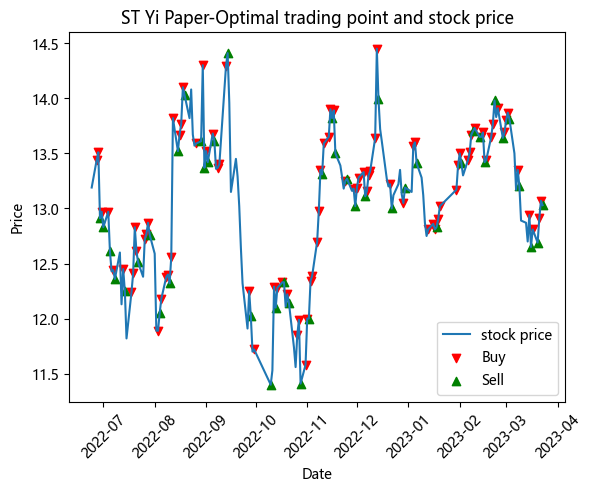

ST Yi Paper总收益率为: 0.5606378870847016
Epoch 1/100
4/4 [==============================] - 0s 40ms/step - loss: 0.9954 - val_loss: 1.2503
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.9418 - val_loss: 1.1629
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.9036 - val_loss: 1.1238
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 0.8711 - val_loss: 1.0759
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.8364 - val_loss: 1.0536
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8045 - val_loss: 1.0132
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7706 - val_loss: 0.9620
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7386 - val_loss: 0.9039
Epoch 9/100
4/4 [==============================] - 0s 21ms/step - loss: 0.7093 - val_loss: 0.8579
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6790 -

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 10ms/step - loss: 0.9565 - val_loss: 1.0620
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9008 - val_loss: 1.0419
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.8793 - val_loss: 1.0627
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8522 - val_loss: 1.0263
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.8249 - val_loss: 1.0068
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7966 - val_loss: 0.9952
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7650 - val_loss: 0.9704
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.7256 - val_loss: 0.9039
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6862 - val_loss: 0.8481
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6345 - val_loss: 0.8542
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 1.1212 - val_loss: 0.6270
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 1.0620 - val_loss: 0.6182
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 1.0309 - val_loss: 0.6098
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9879 - val_loss: 0.5985
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9600 - val_loss: 0.5668
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9316 - val_loss: 0.5493
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.8743 - val_loss: 0.5219
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8306 - val_loss: 0.4684
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 0.7616 - val_loss: 0.4246
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 0.6761 - val_loss: 0.3858
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 7ms/step - loss: 0.9915 - val_loss: 0.9793
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9653 - val_loss: 0.9535
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9605 - val_loss: 0.9609
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9212 - val_loss: 0.9267
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8895 - val_loss: 0.9111
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8634 - val_loss: 0.9022
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8404 - val_loss: 0.8544
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7864 - val_loss: 0.8076
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7467 - val_loss: 0.7526
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 0.6914 - val_loss: 0.7164
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 1.0076 - val_loss: 0.9664
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9743 - val_loss: 0.9664
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9627 - val_loss: 0.9564
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9481 - val_loss: 0.9505
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9373 - val_loss: 0.9171
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9281 - val_loss: 0.9063
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9203 - val_loss: 0.8811
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9031 - val_loss: 0.8802
Epoch 9/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8840 - val_loss: 0.8311
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8264 - val_loss: 0.7891
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
30/30 [==============================] - 0s 6ms/step - loss: 0.9618 - val_loss: 1.0134
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.9128 - val_loss: 0.9963
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9003 - val_loss: 1.0093
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9066 - val_loss: 1.0073
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8911 - val_loss: 1.0012
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8734 - val_loss: 0.9867
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8504 - val_loss: 0.9416
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8340 - val_loss: 1.0073
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8295 - val_loss: 0.9408
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.7965 - val_loss: 0.9107
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 1s 7ms/step - loss: 1.0349 - val_loss: 0.9815
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0189 - val_loss: 0.9821
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0077 - val_loss: 0.9794
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0044 - val_loss: 0.9515
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9954 - val_loss: 0.9423
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9843 - val_loss: 0.9257
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9752 - val_loss: 0.9280
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9760 - val_loss: 0.9520
Epoch 9/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9580 - val_loss: 0.9083
Epoch 10/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9413 - val_loss: 0.8856
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 49ms/step - loss: 1.2352 - val_loss: 1.2249
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0190 - val_loss: 1.2676
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 0.9429 - val_loss: 1.2806
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 0.9277 - val_loss: 1.2502
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8972 - val_loss: 1.1119
Epoch 6/100
4/4 [==============================] - 0s 25ms/step - loss: 0.8558 - val_loss: 0.9926
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8171 - val_loss: 0.8991
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7879 - val_loss: 0.8294
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7594 - val_loss: 0.7667
Epoch 10/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7355 - val_loss: 0.7392
Epoch 11/100
4/4 [=

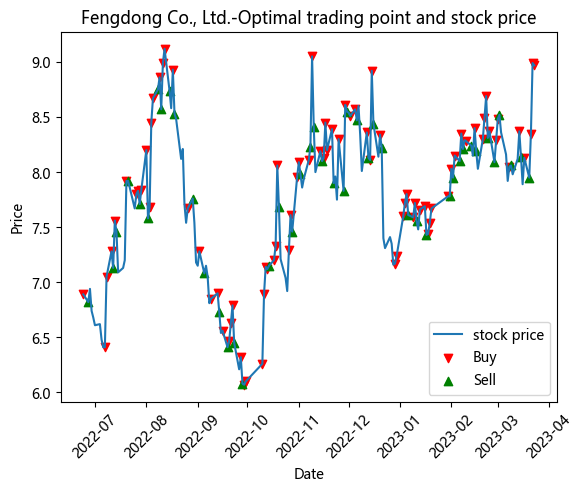

Fengdong Co., Ltd.总收益率为: 1.1489285540971874
Epoch 1/100
4/4 [==============================] - 1s 44ms/step - loss: 0.9357 - val_loss: 0.8209
Epoch 2/100
4/4 [==============================] - 0s 19ms/step - loss: 0.8147 - val_loss: 0.8081
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 0.8058 - val_loss: 0.8217
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8009 - val_loss: 0.8149
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.7818 - val_loss: 0.7838
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7573 - val_loss: 0.7541
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7404 - val_loss: 0.7350
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7341 - val_loss: 0.7284
Epoch 9/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7163 - val_loss: 0.7159
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 13ms/step - loss: 0.7924 - val_loss: 0.9795
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7683 - val_loss: 0.9625
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7444 - val_loss: 0.9469
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7253 - val_loss: 0.9446
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7124 - val_loss: 0.9187
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6919 - val_loss: 0.9029
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6712 - val_loss: 0.8840
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6540 - val_loss: 0.8568
Epoch 9/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6300 - val_loss: 0.8236
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6058 - val_loss: 0.8259
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 0.8073 - val_loss: 1.0366
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7757 - val_loss: 1.0068
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7562 - val_loss: 0.9672
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7337 - val_loss: 0.9657
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7185 - val_loss: 0.9304
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6967 - val_loss: 0.9036
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6758 - val_loss: 0.9018
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6683 - val_loss: 0.8522
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6380 - val_loss: 0.8301
Epoch 10/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6151 - val_loss: 0.7912
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 13ms/step - loss: 0.8322 - val_loss: 1.0669
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7885 - val_loss: 1.0037
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7764 - val_loss: 0.9771
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7673 - val_loss: 0.9729
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7562 - val_loss: 0.9667
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7468 - val_loss: 0.9492
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7408 - val_loss: 0.9564
Epoch 8/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7232 - val_loss: 0.9342
Epoch 9/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7157 - val_loss: 0.9145
Epoch 10/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7025 - val_loss: 0.9204
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 0.8512 - val_loss: 1.0483
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.8017 - val_loss: 1.0456
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7639 - val_loss: 0.9911
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7591 - val_loss: 0.9717
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7456 - val_loss: 0.9759
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7156 - val_loss: 0.9260
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6991 - val_loss: 0.9111
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6819 - val_loss: 0.8877
Epoch 9/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6557 - val_loss: 0.8697
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6354 - val_loss: 0.8397
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 0.8471 - val_loss: 1.0452
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7852 - val_loss: 1.0082
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7617 - val_loss: 0.9965
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7493 - val_loss: 0.9676
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7342 - val_loss: 0.9923
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7077 - val_loss: 0.9419
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6985 - val_loss: 0.9214
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6705 - val_loss: 0.8938
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6517 - val_loss: 0.8857
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6275 - val_loss: 0.8406
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.8594 - val_loss: 1.0374
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7814 - val_loss: 1.0122
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7633 - val_loss: 0.9990
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7495 - val_loss: 0.9944
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7343 - val_loss: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7198 - val_loss: 0.9551
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7029 - val_loss: 0.9174
Epoch 8/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6845 - val_loss: 0.8928
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6587 - val_loss: 0.8654
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6385 - val_loss: 0.8450
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
8/8 [==============================] - 0s 20ms/step - loss: 1.1377 - val_loss: 0.9155
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 1.0323 - val_loss: 0.8779
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9830 - val_loss: 0.8805
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9603 - val_loss: 0.8767
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9185 - val_loss: 0.8240
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.8888 - val_loss: 0.8015
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.8408 - val_loss: 0.7815
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.8172 - val_loss: 0.7578
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 0.7733 - val_loss: 0.7083
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 0.7315 - val_loss: 0.6805
Epoch 11/100
8/8 [==========

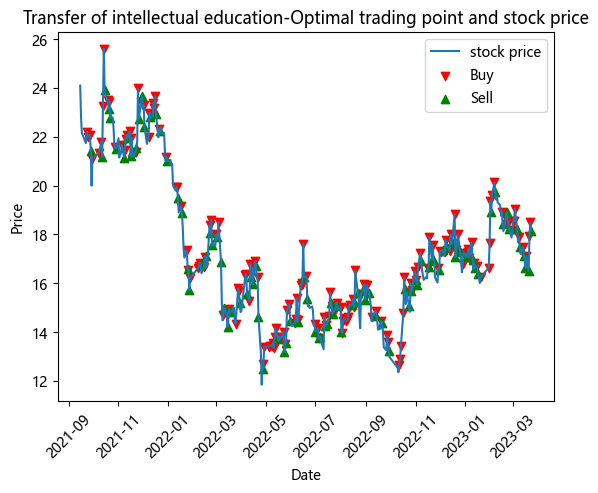

Transfer of intellectual education总收益率为: 1.6082205764547115
Epoch 1/100
4/4 [==============================] - 0s 55ms/step - loss: 1.1251 - val_loss: 1.0266
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 1.0788 - val_loss: 0.9387
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 1.0529 - val_loss: 0.8762
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 1.0343 - val_loss: 0.8365
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 1.0154 - val_loss: 0.8223
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 1.0015 - val_loss: 0.8177
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9906 - val_loss: 0.8292
Epoch 8/100
4/4 [==============================] - 0s 20ms/step - loss: 0.9843 - val_loss: 0.8241
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9778 - val_loss: 0.8273
Epoch 10/100
4/4 [==============================] - 0s 15m

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 1.1354 - val_loss: 0.8824
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0975 - val_loss: 0.8669
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0561 - val_loss: 0.8596
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0490 - val_loss: 0.8617
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0246 - val_loss: 0.8204
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.9969 - val_loss: 0.8282
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.9813 - val_loss: 0.7955
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9263 - val_loss: 0.7883
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9118 - val_loss: 0.7439
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8595 - val_loss: 0.7028
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 0.9296 - val_loss: 1.0927
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9025 - val_loss: 1.0579
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8872 - val_loss: 1.0430
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8745 - val_loss: 1.0301
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8632 - val_loss: 1.0256
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8636 - val_loss: 1.0130
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8467 - val_loss: 0.9787
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8221 - val_loss: 0.9724
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8108 - val_loss: 0.9674
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7843 - val_loss: 0.9044
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 1.0637 - val_loss: 0.8112
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 1.0184 - val_loss: 0.8038
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9760 - val_loss: 0.8006
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9498 - val_loss: 0.7789
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9033 - val_loss: 0.7736
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8649 - val_loss: 0.7630
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8147 - val_loss: 0.7381
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7610 - val_loss: 0.6923
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7106 - val_loss: 0.6898
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6470 - val_loss: 0.6230
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 0.9221 - val_loss: 1.0803
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8938 - val_loss: 1.0569
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9003 - val_loss: 1.0597
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8728 - val_loss: 1.0252
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8455 - val_loss: 1.0420
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8248 - val_loss: 0.9985
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7929 - val_loss: 0.9770
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7556 - val_loss: 0.9267
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7630 - val_loss: 0.9353
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7045 - val_loss: 0.8370
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 1s 7ms/step - loss: 1.0262 - val_loss: 0.8290
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9993 - val_loss: 0.8056
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9787 - val_loss: 0.7794
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9621 - val_loss: 0.8019
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9450 - val_loss: 0.7357
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9383 - val_loss: 0.7452
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8907 - val_loss: 0.7015
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8628 - val_loss: 0.7115
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8371 - val_loss: 0.6832
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8276 - val_loss: 0.6339
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 0s 6ms/step - loss: 1.0334 - val_loss: 0.8182
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9859 - val_loss: 0.7973
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9673 - val_loss: 0.7795
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9398 - val_loss: 0.7599
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9409 - val_loss: 0.7341
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8999 - val_loss: 0.7165
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8620 - val_loss: 0.7069
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8573 - val_loss: 0.6704
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8284 - val_loss: 0.6697
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7722 - val_loss: 0.6124
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 0s 6ms/step - loss: 1.0480 - val_loss: 0.8366
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9956 - val_loss: 0.8076
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9865 - val_loss: 0.7801
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9622 - val_loss: 0.8149
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9429 - val_loss: 0.7403
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9228 - val_loss: 0.7639
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8932 - val_loss: 0.7356
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8746 - val_loss: 0.7235
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8348 - val_loss: 0.7400
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8068 - val_loss: 0.6955
Epoch 11/

<ipython-input-3-162043647918>:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:368: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

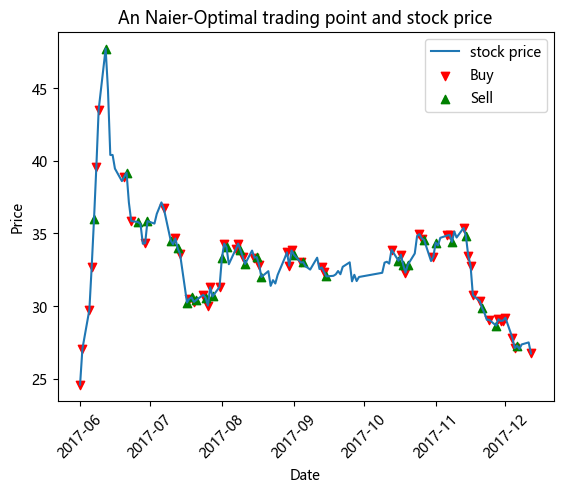

An Naier总收益率为: 0.0
Epoch 1/100
4/4 [==============================] - 0s 44ms/step - loss: 0.9435 - val_loss: 1.1993
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.8360 - val_loss: 1.1817
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7474 - val_loss: 1.1567
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6964 - val_loss: 1.1357
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6388 - val_loss: 1.1508
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6013 - val_loss: 1.1427
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.5722 - val_loss: 1.1319
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.5543 - val_loss: 1.1205
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5315 - val_loss: 1.1041
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.5209 - val_loss: 1.0622


<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 1.0831 - val_loss: 0.8062
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9718 - val_loss: 0.7843
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9478 - val_loss: 0.7655
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9237 - val_loss: 0.7577
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9029 - val_loss: 0.7455
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8798 - val_loss: 0.7357
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8673 - val_loss: 0.7198
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8456 - val_loss: 0.6923
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8196 - val_loss: 0.6821
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8150 - val_loss: 0.6545
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 0.9826 - val_loss: 0.9770
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9200 - val_loss: 0.9534
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9021 - val_loss: 0.9678
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8962 - val_loss: 0.9369
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8745 - val_loss: 0.9051
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8558 - val_loss: 0.9132
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8397 - val_loss: 0.8634
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8092 - val_loss: 0.8623
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7935 - val_loss: 0.8497
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7692 - val_loss: 0.7682
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 1.0110 - val_loss: 0.8524
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9639 - val_loss: 0.8448
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9428 - val_loss: 0.8555
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9372 - val_loss: 0.8556
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9224 - val_loss: 0.8312
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9182 - val_loss: 0.8220
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9116 - val_loss: 0.8155
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8920 - val_loss: 0.8171
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8876 - val_loss: 0.8025
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8770 - val_loss: 0.7795
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 0.9774 - val_loss: 0.9682
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9072 - val_loss: 0.9749
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8947 - val_loss: 0.9747
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8913 - val_loss: 0.9895
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8774 - val_loss: 0.9515
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8667 - val_loss: 0.9619
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8639 - val_loss: 0.9461
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8427 - val_loss: 0.9564
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8554 - val_loss: 0.9334
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8322 - val_loss: 0.9054
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
30/30 [==============================] - 0s 6ms/step - loss: 0.9612 - val_loss: 0.9239
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8963 - val_loss: 0.9112
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8917 - val_loss: 0.9116
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8725 - val_loss: 0.8872
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8779 - val_loss: 0.8987
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8539 - val_loss: 0.9234
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8810 - val_loss: 0.8763
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8681 - val_loss: 0.8790
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8325 - val_loss: 0.8682
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8392 - val_loss: 0.9015
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 0s 6ms/step - loss: 1.0384 - val_loss: 0.8845
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0017 - val_loss: 0.8645
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0161 - val_loss: 0.8332
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9967 - val_loss: 0.8581
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9919 - val_loss: 0.8620
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9888 - val_loss: 0.8387
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9759 - val_loss: 0.8363
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9793 - val_loss: 0.8341
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9538 - val_loss: 0.8052
Epoch 10/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9401 - val_loss: 0.8116
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 45ms/step - loss: 0.8795 - val_loss: 1.2681
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7609 - val_loss: 1.3023
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7011 - val_loss: 1.3504
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6806 - val_loss: 1.3877
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6391 - val_loss: 1.3540
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6215 - val_loss: 1.3389
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5986 - val_loss: 1.2902
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5862 - val_loss: 1.2479
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.5691 - val_loss: 1.2135
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.5505 - val_loss: 1.1854
Epoch 11/100
4/4 [=

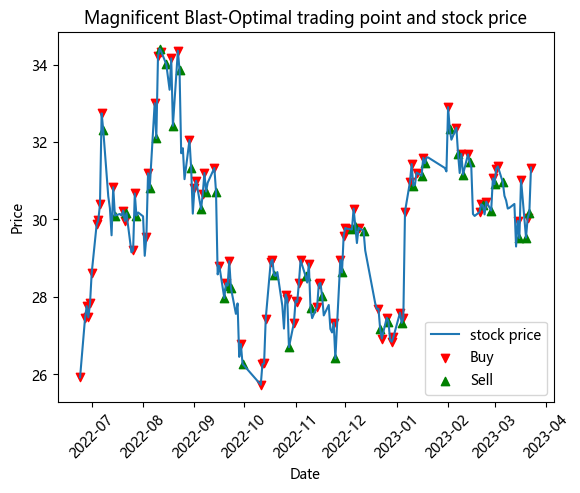

Magnificent Blast总收益率为: 0.9106915704422824
Epoch 1/100
4/4 [==============================] - 0s 49ms/step - loss: 1.0843 - val_loss: 0.9689
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9770 - val_loss: 0.9500
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9734 - val_loss: 0.9663
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 0.9733 - val_loss: 0.9707
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9533 - val_loss: 0.9544
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.9301 - val_loss: 0.9429
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.9202 - val_loss: 0.9339
Epoch 8/100
4/4 [==============================] - 0s 15ms/step - loss: 0.9123 - val_loss: 0.9268
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9031 - val_loss: 0.9248
Epoch 10/100
4/4 [==============================] - 0s 15ms/step - loss: 0.

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.7736 - val_loss: 0.6174
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7355 - val_loss: 0.6310
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7101 - val_loss: 0.5924
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7005 - val_loss: 0.5905
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6921 - val_loss: 0.5829
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6777 - val_loss: 0.5773
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6728 - val_loss: 0.5772
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6615 - val_loss: 0.5564
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6523 - val_loss: 0.5553
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6438 - val_loss: 0.5541
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 0.7777 - val_loss: 0.6144
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7084 - val_loss: 0.5918
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6926 - val_loss: 0.5936
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6855 - val_loss: 0.5894
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6697 - val_loss: 0.5610
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6565 - val_loss: 0.5476
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6391 - val_loss: 0.5475
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6279 - val_loss: 0.5294
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6093 - val_loss: 0.5242
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5919 - val_loss: 0.5055
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.7467 - val_loss: 0.6170
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7110 - val_loss: 0.5997
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6833 - val_loss: 0.5895
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6725 - val_loss: 0.5738
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6690 - val_loss: 0.5781
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6547 - val_loss: 0.5730
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6367 - val_loss: 0.5562
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6273 - val_loss: 0.5288
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6029 - val_loss: 0.5424
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5929 - val_loss: 0.5099
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 0.8177 - val_loss: 0.6425
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7220 - val_loss: 0.5861
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6937 - val_loss: 0.5918
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6740 - val_loss: 0.5723
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6577 - val_loss: 0.5585
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6417 - val_loss: 0.5484
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6215 - val_loss: 0.5213
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6064 - val_loss: 0.5125
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5959 - val_loss: 0.5054
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss: 0.5698 - val_loss: 0.4742
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 0.7610 - val_loss: 0.5925
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7145 - val_loss: 0.5736
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6955 - val_loss: 0.5774
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6809 - val_loss: 0.5795
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6733 - val_loss: 0.5618
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6435 - val_loss: 0.5711
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6387 - val_loss: 0.5507
Epoch 8/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6311 - val_loss: 0.5337
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6029 - val_loss: 0.5326
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5890 - val_loss: 0.5199
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.8291 - val_loss: 0.6126
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7269 - val_loss: 0.6001
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7137 - val_loss: 0.5792
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6944 - val_loss: 0.5719
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6864 - val_loss: 0.5575
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6706 - val_loss: 0.5603
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6480 - val_loss: 0.5349
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6466 - val_loss: 0.5266
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6260 - val_loss: 0.5273
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6133 - val_loss: 0.5023
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
8/8 [==============================] - 0s 23ms/step - loss: 1.2019 - val_loss: 0.7110
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 1.1476 - val_loss: 0.6932
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 1.1409 - val_loss: 0.6891
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 1.1284 - val_loss: 0.6912
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 1.1263 - val_loss: 0.6894
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 1.1288 - val_loss: 0.6914
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 1.1178 - val_loss: 0.6716
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 1.1143 - val_loss: 0.6661
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 1.1092 - val_loss: 0.6730
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 1.1004 - val_loss: 0.6711
Epoch 11/100
8/8 [==========

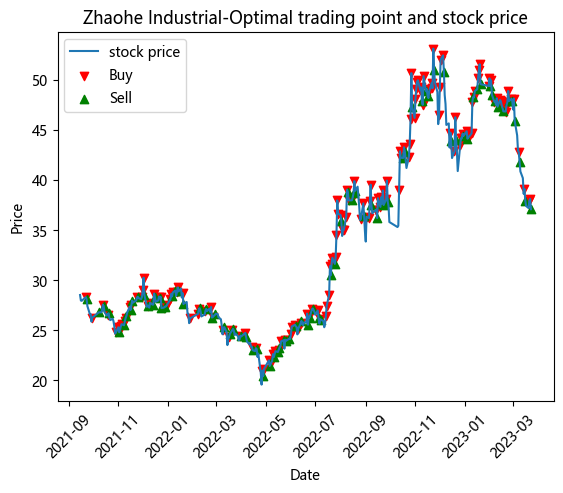

Zhaohe Industrial总收益率为: 1.5548634897723206
Epoch 1/100
4/4 [==============================] - 1s 58ms/step - loss: 0.9899 - val_loss: 0.8931
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8948 - val_loss: 0.8683
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8510 - val_loss: 0.8649
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8260 - val_loss: 0.8669
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7955 - val_loss: 0.8632
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7761 - val_loss: 0.8656
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7526 - val_loss: 0.8657
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7284 - val_loss: 0.8667
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7085 - val_loss: 0.8681
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 0.9208 - val_loss: 1.1221
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8588 - val_loss: 1.0662
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8481 - val_loss: 1.0583
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8258 - val_loss: 1.0191
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8043 - val_loss: 1.0067
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7868 - val_loss: 0.9661
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7609 - val_loss: 0.9373
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7515 - val_loss: 0.9075
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7237 - val_loss: 0.8461
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6823 - val_loss: 0.8087
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 0.9598 - val_loss: 1.1538
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9289 - val_loss: 1.1245
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9061 - val_loss: 1.1426
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8900 - val_loss: 1.1335
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8758 - val_loss: 1.1141
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8727 - val_loss: 1.0958
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8548 - val_loss: 1.0771
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8442 - val_loss: 1.0663
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8206 - val_loss: 1.0859
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7957 - val_loss: 1.0063
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 1.0656 - val_loss: 0.8351
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9909 - val_loss: 0.8476
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9676 - val_loss: 0.8237
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9558 - val_loss: 0.8061
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9502 - val_loss: 0.8144
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9417 - val_loss: 0.8121
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9143 - val_loss: 0.7792
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8972 - val_loss: 0.7662
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8782 - val_loss: 0.7388
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8602 - val_loss: 0.7238
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 0.9929 - val_loss: 0.8531
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9579 - val_loss: 0.8314
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9428 - val_loss: 0.8314
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9321 - val_loss: 0.8163
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9198 - val_loss: 0.8170
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9191 - val_loss: 0.8063
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9088 - val_loss: 0.8004
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8910 - val_loss: 0.7916
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8900 - val_loss: 0.7869
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8741 - val_loss: 0.8184
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 1s 7ms/step - loss: 0.9366 - val_loss: 1.1519
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9117 - val_loss: 1.1065
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8974 - val_loss: 1.0905
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8829 - val_loss: 1.0804
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8795 - val_loss: 1.0331
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8634 - val_loss: 1.0257
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8528 - val_loss: 1.0297
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8381 - val_loss: 0.9933
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8116 - val_loss: 0.9495
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7991 - val_loss: 0.9732
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9525 - val_loss: 1.1301
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9240 - val_loss: 1.1359
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9151 - val_loss: 1.1348
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9051 - val_loss: 1.1070
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9005 - val_loss: 1.1092
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8878 - val_loss: 1.1111
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8772 - val_loss: 1.1098
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8646 - val_loss: 1.1516
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8535 - val_loss: 1.0350
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8377 - val_loss: 1.0688
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 44ms/step - loss: 0.9635 - val_loss: 0.8316
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8997 - val_loss: 0.8050
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8530 - val_loss: 0.7995
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8179 - val_loss: 0.7966
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7878 - val_loss: 0.7932
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7488 - val_loss: 0.7857
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7149 - val_loss: 0.7701
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6845 - val_loss: 0.7574
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6482 - val_loss: 0.7396
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6117 - val_loss: 0.7256
Epoch 11/100
4/4 [=

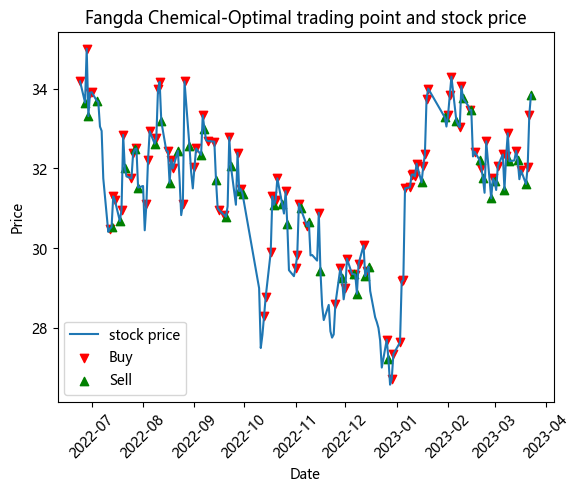

Fangda Chemical总收益率为: 0.6915079759917635
Epoch 1/100
4/4 [==============================] - 1s 45ms/step - loss: 0.9060 - val_loss: 1.4853
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7816 - val_loss: 1.6063
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7282 - val_loss: 1.7734
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6860 - val_loss: 1.8991
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.6841 - val_loss: 2.0074
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6681 - val_loss: 1.9844
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6543 - val_loss: 1.8836
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6375 - val_loss: 1.8454
Epoch 9/100
4/4 [==============================] - 0s 12ms/step - loss: 0.6212 - val_loss: 1.7743
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.60

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 1.0445 - val_loss: 0.7964
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9845 - val_loss: 0.7461
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9416 - val_loss: 0.7232
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9041 - val_loss: 0.6983
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8520 - val_loss: 0.6635
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8026 - val_loss: 0.6147
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7510 - val_loss: 0.5848
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6956 - val_loss: 0.5237
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6545 - val_loss: 0.5470
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6054 - val_loss: 0.4436
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 10ms/step - loss: 0.9963 - val_loss: 0.9677
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9548 - val_loss: 0.9017
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9170 - val_loss: 0.8839
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8816 - val_loss: 0.8400
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8373 - val_loss: 0.7746
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8002 - val_loss: 0.7530
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7636 - val_loss: 0.6659
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.6995 - val_loss: 0.6552
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6528 - val_loss: 0.5634
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.5818 - val_loss: 0.4701
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 1.0669 - val_loss: 0.8217
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 1.0355 - val_loss: 0.7951
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 1.0010 - val_loss: 0.7962
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9666 - val_loss: 0.7579
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9554 - val_loss: 0.7469
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9071 - val_loss: 0.7086
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8580 - val_loss: 0.7045
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8219 - val_loss: 0.6499
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7493 - val_loss: 0.5793
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6707 - val_loss: 0.5137
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 8ms/step - loss: 0.9863 - val_loss: 1.0599
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9102 - val_loss: 1.0537
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8775 - val_loss: 1.0234
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8690 - val_loss: 1.0059
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8444 - val_loss: 0.9992
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8397 - val_loss: 0.9926
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8339 - val_loss: 0.9570
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8133 - val_loss: 0.9487
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7819 - val_loss: 0.9282
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7682 - val_loss: 0.8735
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 0s 6ms/step - loss: 1.0536 - val_loss: 1.0083
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 1.0208 - val_loss: 0.9581
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 1.0035 - val_loss: 0.9511
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9814 - val_loss: 0.9213
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9591 - val_loss: 0.9039
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9441 - val_loss: 0.9039
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9318 - val_loss: 0.8515
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8734 - val_loss: 0.8912
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8370 - val_loss: 0.7721
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7846 - val_loss: 0.7462
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 0s 6ms/step - loss: 1.0717 - val_loss: 0.8682
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0427 - val_loss: 0.8556
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0350 - val_loss: 0.8542
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0372 - val_loss: 0.8584
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0223 - val_loss: 0.8534
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0260 - val_loss: 0.8438
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0066 - val_loss: 0.8462
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0039 - val_loss: 0.8216
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9947 - val_loss: 0.8154
Epoch 10/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9813 - val_loss: 0.8366
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 44ms/step - loss: 0.9327 - val_loss: 1.8852
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8157 - val_loss: 2.0147
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7620 - val_loss: 2.1095
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7424 - val_loss: 2.1703
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7284 - val_loss: 2.1637
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7076 - val_loss: 2.1173
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6935 - val_loss: 2.0588
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6817 - val_loss: 1.9880
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6670 - val_loss: 1.9433
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6546 - val_loss: 1.9214
Epoch 11/100
4/4 [=

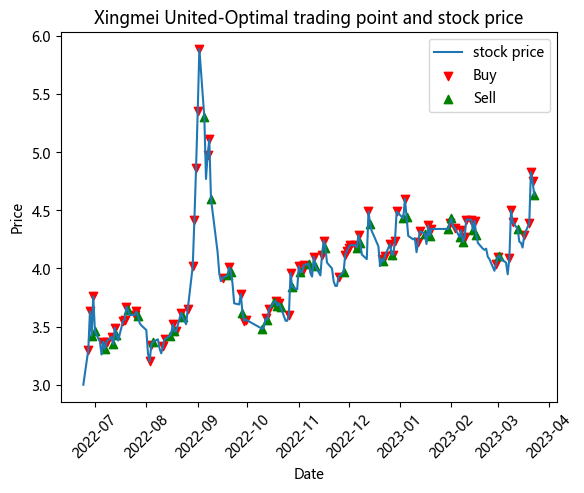

Xingmei United总收益率为: 0.9992440106152063
Epoch 1/100
4/4 [==============================] - 0s 54ms/step - loss: 1.2124 - val_loss: 0.8905
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0904 - val_loss: 0.8530
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0209 - val_loss: 0.8358
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9643 - val_loss: 0.8317
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9317 - val_loss: 0.8170
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8912 - val_loss: 0.8073
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8780 - val_loss: 0.7893
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8576 - val_loss: 0.7688
Epoch 9/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8266 - val_loss: 0.7518
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.803

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 0.9971 - val_loss: 1.1291
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9304 - val_loss: 1.1087
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9082 - val_loss: 1.1215
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9027 - val_loss: 1.0996
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8898 - val_loss: 1.0785
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8733 - val_loss: 1.0849
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8593 - val_loss: 1.0467
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8518 - val_loss: 1.0329
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8462 - val_loss: 0.9959
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8122 - val_loss: 1.0181
Epoch 11

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 0.9048 - val_loss: 0.9003
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8539 - val_loss: 0.9247
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8292 - val_loss: 0.9278
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8063 - val_loss: 0.9221
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7814 - val_loss: 0.8895
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7707 - val_loss: 0.9009
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7466 - val_loss: 0.8511
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6983 - val_loss: 0.8067
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6635 - val_loss: 0.7769
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 0.6078 - val_loss: 0.6997
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 0.9445 - val_loss: 1.0679
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8994 - val_loss: 1.0882
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8865 - val_loss: 1.0851
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8899 - val_loss: 1.0559
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8504 - val_loss: 1.0102
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8105 - val_loss: 1.0046
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7746 - val_loss: 0.9160
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7627 - val_loss: 0.8853
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7163 - val_loss: 0.8891
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6600 - val_loss: 0.8195
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
24/24 [==============================] - 0s 7ms/step - loss: 0.9812 - val_loss: 1.0457
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.9235 - val_loss: 1.0155
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.9088 - val_loss: 1.0356
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.8746 - val_loss: 0.9588
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.8397 - val_loss: 0.9301
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.8112 - val_loss: 0.9091
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.7719 - val_loss: 0.8217
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.7047 - val_loss: 0.7968
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6531 - val_loss: 0.7147
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6150 - val_loss: 0.7315
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
28/28 [==============================] - 0s 7ms/step - loss: 0.9943 - val_loss: 0.8309
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 0.9361 - val_loss: 0.8290
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 0.9123 - val_loss: 0.8116
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8717 - val_loss: 0.8103
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8226 - val_loss: 0.7739
Epoch 6/100
28/28 [==============================] - 0s 3ms/step - loss: 0.7802 - val_loss: 0.6988
Epoch 7/100
28/28 [==============================] - 0s 3ms/step - loss: 0.7055 - val_loss: 0.6235
Epoch 8/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6352 - val_loss: 0.5440
Epoch 9/100
28/28 [==============================] - 0s 3ms/step - loss: 0.5324 - val_loss: 0.5022
Epoch 10/100
28/28 [==============================] - 0s 3ms/step - loss: 0.4604 - val_loss: 0.4110
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9704 - val_loss: 1.0878
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9379 - val_loss: 1.0676
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9341 - val_loss: 1.0603
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9146 - val_loss: 1.0596
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9084 - val_loss: 1.0216
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8753 - val_loss: 0.9873
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8741 - val_loss: 0.9801
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8267 - val_loss: 0.9441
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7949 - val_loss: 0.8737
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7831 - val_loss: 0.8263
Epoch 11/

<ipython-input-3-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-3-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-3-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 46ms/step - loss: 1.1889 - val_loss: 0.8442
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 1.0817 - val_loss: 0.8184
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 1.0075 - val_loss: 0.8135
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9459 - val_loss: 0.7935
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8976 - val_loss: 0.7688
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8633 - val_loss: 0.7370
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8210 - val_loss: 0.7082
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7956 - val_loss: 0.6812
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7664 - val_loss: 0.6602
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7468 - val_loss: 0.6475
Epoch 11/100
4/4 [=

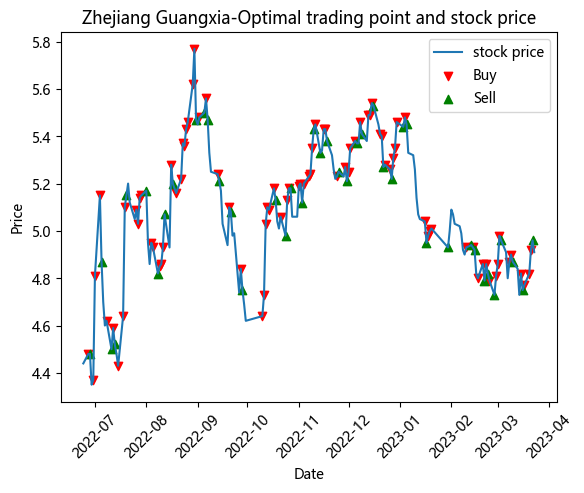

Zhejiang Guangxia总收益率为: 0.40918941644335444


ConnectionError: HTTPConnectionPool(host='api.mymemory.translated.net', port=80): Max retries exceeded with url: /get?q=%E7%BA%A2%E8%B1%86%E8%82%A1%E4%BB%BD&langpair=zh%7Cen (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001D79B7774C0>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))

In [3]:
import openpyxl
from sklearn import svm
import xlrd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from translate import Translator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.optimize import minimize
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection
from sklearn.metrics import r2_score
import time

if not os.path.exists('Output'):
    os.makedirs('Output')
if not os.path.exists('min'):
    os.makedirs('min')
def train(model, x_train, y_train):
    model.fit(x_train, y_train.ravel())
def print_accuracy(model, x_train, y_train, x_test, y_test):
    print('SVM-输出训练集的准确率为:', model.score(x_train, y_train))
    print("SVM-输出测试集的准确率为:", model.score(x_test, y_test))
    # 原始结果与预测结果进行对比
    show_accuracy(model.predict(x_train), y_train, 'traing data')
    show_accuracy(model.predict(x_test), y_test, 'testing data')
    # 计算决策函数的值
    print('decision_function:\n', model.decision_function(x_train))

def show_accuracy(a, b, tip):
    acc = (a.ravel() == b.ravel())
    print("%s Accuracy:%.3f" % (tip, np.mean(acc)))

buy_threshold =0.08
sell_threshold =0.05

#'交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元'
# 设置相对路径
data_path = "./data"              ###股票十年历史数据所在文件夹
max_longs = 2000                    ####总日期长度
SF='FCNN神经网络'
translator = Translator(from_lang='zh', to_lang='en')
SF = translator.translate(SF)
# 创建空DataFrame来存储所有表格的数据
all_data = pd.DataFrame()
row_index2 = ['total time(s)', 'total revenue(%)', 'train_accuracy', 'test_accuracy']
# 创建一个空的DataFrame
table2_data = pd.DataFrame(index=row_index2)
row_index = ['Longs=183','Longs=366','Longs=549','Longs=732','Longs=915','Longs=1098','Longs=1281','Longs=1464','Longs=1647']
# 创建一个空的DataFrame
table1_data = pd.DataFrame(index=row_index)
########################如果文件是一个，分成不同的工作表，以下代码是先将工作表分开##########
# 打开Excel文件
workbook = xlrd.open_workbook("data\\股票十年历史数据.xls")

# 遍历每个工作表
for sheet_name in workbook.sheet_names():
    # 选择工作表
    sheet = workbook.sheet_by_name(sheet_name)
    # 创建一个新的Excel文件
    new_workbook = openpyxl.Workbook()

    # 选择新的工作表，并将数据复制到该工作表中
    new_sheet = new_workbook.active
    new_sheet.title = sheet_name
    for row in range(sheet.nrows):
        for col in range(sheet.ncols):
            # 检查是否为“交易日期”列
            if sheet.cell_value(0, col) == "交易日期":
                # 如果是，则将单元格格式设置为日期时间格式
                cell = new_sheet.cell(row=row+1, column=col+1)
                cell.value = sheet.cell_value(row, col)
                cell.number_format = "yyyy/m/d h:mm:ss"
            else:
                # 如果不是，则直接复制单元格的值
                new_sheet.cell(row=row+1, column=col+1).value = sheet.cell_value(row, col)
    # 获取“证券简称”列第一个数据
    security_name = sheet.cell_value(1, 1)

    # 去除文件名中的非法字符
    for char in ["\\", "/", ":", "*", "?", "\"", "<", ">", "|"]:
        security_name = security_name.replace(char, "")

    # 将工作表保存到新的Excel文件中，并将文件命名为“证券简称”列第一个数据
    new_workbook.save(os.path.join("data", f"{security_name}.xls"))

    # # 将工作表保存到新的Excel文件中
    # new_workbook.save(os.path.join("data", f"{sheet_name}.xls"))
##########################################################################################   



# 遍历"data"文件夹中的所有文件
for filename in os.listdir(data_path):
    if filename == "股票十年历史数据.xls":
       # 如果文件名是"股票十年历史数据.xls"，则跳过该文件
        continue
    if filename.endswith(".xls"):
        filepath = os.path.join(data_path, filename)
        # 读取表格数据
        df = pd.read_excel(filepath)#####################################
        
        nameT = os.path.splitext(os.path.basename(filename))[0].split(' ')[0]
        nameT = translator.translate(nameT)
        start_time = time.time()
        time_list = []
        remark_list = []
        table2=[]
        def ff(longg):
            Longs=longg
            name=filepath
            TEXTname=name
            # 读取 XLS 文件
            df = pd.read_excel(name)
            df = df.iloc[-Longs:]
            # 选择需要的列并创建新的DataFrame
            data = df[['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']]
            dataL = data.set_index('交易日期')
            dataV= data
            # 重新命名列
            data.columns = ['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']
            df=data
            # 数据清洗
            df = df.drop_duplicates()  # 去重
            # 缺失值处理
            df = df.fillna(method='ffill')  # 用前一行的值填充缺失值
            # 异常值处理
            df = df[df['成交数量@单位：股'] > 0]  # 去除成交数量为负的数据
            # 特征工程
            df['涨跌幅'] = (df['最近成交'] - df['昨日收盘']) / df['昨日收盘']  # 计算涨跌幅
            dddate=df##后面画图还要用到日期，这里先保留在ddate里
            # 删除无用的特征
            df = df.drop(columns=['交易日期', '最近成交', '成交金额(人民币)@单位：元'])  
            # 数据标准化z = (x - u) / s：均值归零，方差化1
            scaler = StandardScaler()
            df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

            # 将数据分为特征和标签；自变量因变量
            X = df_scaled.drop(columns=['涨跌幅'])
            y = df_scaled[['涨跌幅']]

            # 将数据分为训练集和测试集
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # 构建CNN模型
            model = keras.Sequential([
                layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
                layers.Dense(64, activation='relu'),
                layers.Dense(1)
            ])
            model.compile(loss='mean_squared_error', optimizer='adam')

            # 训练模型
            model.fit(X_train, y_train, epochs=100, validation_split=0.2)
            # 在训练集和测试集上预测结果###########训练完成
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # 将预测结果映射为二分类结果（涨或跌）
            y_train_pred_binary = np.where(y_train_pred > 0, 1, 0)
            y_test_pred_binary = np.where(y_test_pred > 0, 1, 0)
            y_train_binary = np.where(y_train > 0, 1, 0)
            y_test_binary = np.where(y_test > 0, 1, 0)
            # 计算并输出准确率
            train_acc = accuracy_score(y_train_binary, y_train_pred_binary)
            test_acc = accuracy_score(y_test_binary, y_test_pred_binary)
            print("Train accuracy:", train_acc)
            print("Test accuracy:", test_acc)


            X1=X.iloc[:366,:]
            y_pred = model.predict(X1)
            yy = pd.DataFrame(y_pred, columns=[ '涨跌幅'])

            # RR=r2_score(y, y_pred)##R平方值
            # print(f'R平方值={RR}')
            # history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


            y_pred=yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
            df_scaled['策略'] = yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
            dataV2= dataV.iloc[:366, :]
            df_selected= df_scaled.iloc[:366, :]


            df_selected.index=df_selected.index+len(dddate)-Longs
            df_selected['今日开盘']=dataV2['今日开盘']

            # 初始化买入价格和买入索引
            buy_price = None
            buy_index = None

            # 初始化收益率和策略列表
            profits = []
            strategies = []
            for i, row in df_selected.iterrows():
                if y_pred[i-len(dddate)+Longs] == 1:
                    # 买入策略
                    buy_price = row['今日开盘']
                    buy_index = i
                    buy_cishu=1
                    profits.append(0)
                    strategies.append('买进')
                else:
                    # 卖出策略
                    if buy_price is not None:
                            profit = (row['今日开盘']*buy_cishu - buy_price) / (buy_price)
                            profits.append(profit)
                            strategies.append('卖出')
                            buy_price=None
                            buy_cishu=0
                    else:
                            # 如果当前没有持仓，就继续观望
                            profits.append(0)
                            strategies.append('持有')



            # 将收益率和策略列表添加到数据框中
            df_selected['收益率'] = profits
            df_selected['策略'] = strategies
            sum_B1 = df_selected['收益率'].sum()
            print(sum_B1)
            sum_B_list.append(float(sum_B1))
            return sum_B1

        sum_B_list = []
        # 定义参数的可能取值范围###############################
        min_longs = 1
        max_longs = 1800
        Longs_range = [i for i in range(min_longs, max_longs+1) if i % 183 == 0]

        # 初始化最大输出和对应的参数值
        max_mean = -np.inf
        best_Longs = None

        # 遍历所有可能的参数值
        for Longs in Longs_range:
            # 计算当前参数值对应的输出
            output = ff(Longs)
            
            # 如果当前输出比最大输出更大，则更新最大输出和对应的参数值
            if output > max_mean:
                max_mean = output
                best_Longs = Longs
        ########################################################

        Longs=best_Longs
        name=filepath
        TEXTname=name
        # 读取 XLS 文件
        df = pd.read_excel(name)
        dddate=df##后面画图还要用到日期，这里先保留在ddate里
        df = df.iloc[-Longs:]
        # 选择需要的列并创建新的DataFrame
        data = df[['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']]
        dataL = data.set_index('交易日期')
        dataV= data
        # 重新命名列
        data.columns = ['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']
        df=data
        # 数据清洗
        df = df.drop_duplicates()  # 去重
        # 缺失值处理
        df = df.fillna(method='ffill')  # 用前一行的值填充缺失值
        # 异常值处理
        df = df[df['成交数量@单位：股'] > 0]  # 去除成交数量为负的数据
        # 特征工程
        df['涨跌幅'] = (df['最近成交'] - df['昨日收盘']) / df['昨日收盘']  # 计算涨跌幅

        # 删除无用的特征
        df = df.drop(columns=['交易日期', '最近成交', '成交金额(人民币)@单位：元'])  
        # 数据标准化z = (x - u) / s：均值归零，方差化1
        scaler = StandardScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

        # 将数据分为特征和标签；自变量因变量
        X = df_scaled.drop(columns=['涨跌幅'])
        y = df_scaled[['涨跌幅']]

        # 将数据分为训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 构建CNN模型
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(loss='mean_squared_error', optimizer='adam')

        # 训练模型
        model.fit(X_train, y_train, epochs=100, validation_split=0.2)
        # 在训练集和测试集上预测结果###########训练完成
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # 将预测结果映射为二分类结果（涨或跌）
        y_train_pred_binary = np.where(y_train_pred > 0, 1, 0)
        y_test_pred_binary = np.where(y_test_pred > 0, 1, 0)
        y_train_binary = np.where(y_train > 0, 1, 0)
        y_test_binary = np.where(y_test > 0, 1, 0)
        # 计算并输出准确率
        train_acc = accuracy_score(y_train_binary, y_train_pred_binary)
        test_acc = accuracy_score(y_test_binary, y_test_pred_binary)
        print("Train accuracy:", train_acc)
        print("Test accuracy:", test_acc)


        X1=X.iloc[:366,:]
        y_pred = model.predict(X1)
        yy = pd.DataFrame(y_pred, columns=[ '涨跌幅'])

        # RR=r2_score(y, y_pred)##R平方值
        # print(f'R平方值={RR}')
        # history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


        y_pred=yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
        df_scaled['策略'] = yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
        dataV2= dataV.iloc[-366:, :]
        df_selected= df_scaled.iloc[:366, :]

        df_selected.index=df_selected.index+len(dddate)-Longs
        df_selected['今日开盘']=dataV2['今日开盘']

        # 初始化买入价格和买入索引
        buy_price = None
        buy_index = None

        # 初始化收益率和策略列表
        profits = []
        strategies = []

        for i, row in df_selected.iterrows():
            if y_pred[i-len(dddate)+Longs] == 1:
                # 买入策略
                buy_price = row['今日开盘']
                buy_index = i
                buy_cishu=1
                profits.append(0)
                strategies.append('买进')
            else:
                # 卖出策略
                if buy_price is not None:
                        profit = (row['今日开盘']*buy_cishu - buy_price) / (buy_price)
                        profits.append(profit)
                        strategies.append('卖出')
                        buy_price=None
                        buy_cishu=0
                else:
                        # 如果当前没有持仓，就继续观望
                        profits.append(0)
                        strategies.append('持有')



        # 将收益率和策略列表添加到数据框中
        df_selected['收益率'] = profits
        df_selected['策略'] = strategies
        sum_B = df_selected['收益率'].sum()
        print(sum_B)

        ddate=df_selected

        ddate['交易日期']=dddate['交易日期']
        ddate['最近成交']=dddate['最近成交']
        # ddate['策略'] = ddate['策略'].replace({'卖出': '买入', '买入': '卖出'})###买进卖出互换

        avg_ddate = ddate.groupby('交易日期')['最近成交'].mean()
        # 选择买入和卖出点的数据
        buy_points = ddate.loc[ddate['策略'] == '买进']
        sell_points = ddate.loc[ddate['策略'] == '卖出']
        # 绘制折线图和散点图
        plt.plot(avg_ddate.index, avg_ddate.values, label='stock price')
        plt.scatter(buy_points['交易日期'], buy_points['最近成交'], marker='v', color='red', label='Buy')
        plt.scatter(sell_points['交易日期'], sell_points['最近成交'], marker='^', color='green', label='Sell')
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{nameT}-Optimal trading point and stock price')
        # 显示折线图和散点图
        plt.savefig(f'Output/{nameT}-最优交易点与股票价格.png', bbox_inches='tight')
        plt.legend()
        plt.show()
        dd = ddate[['交易日期','策略']]
        dd.to_csv(f'Output/{nameT}-决策方案.csv',index=False)
        # 打印列B的总和
        print(f"{nameT}总收益率为:", sum_B)



        end_time = time.time()
        elapsed_time = end_time - start_time


        # 将table作为一列添加到DataFrame中
        table1_data[f'{nameT}'] = sum_B_list




        table2.append(elapsed_time)
        table2.append(sum_B)
        table2.append(train_acc)
        table2.append(test_acc)



        # 将table作为一列添加到DataFrame中
        table2_data[f'{nameT}'] = table2

        all_data.loc[nameT, "Yield"] = sum_B

# 可视化
all_data.to_csv('Output/各个股票的模拟收益率.csv')
all_data = pd.DataFrame(all_data)

# 绘制柱形图
ax = all_data.plot(kind='bar', figsize=(10, 6), rot=0)

# 添加详细纵坐标
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.xticks(rotation=45)
plt.title('Simulated yield of each stock')
plt.savefig(f'Output/{filename}-各个股票的模拟收益率.png', bbox_inches='tight')
plt.legend()
plt.show()
mean = all_data.mean().mean()
print(f'Simulated average yield of each stock:{mean}')
all_data.to_csv('Output/各个股票的模拟收益率.csv')
all_data = pd.DataFrame(all_data)

# 绘制柱形图
ax = all_data.plot(kind='bar', figsize=(10, 6), rot=0)

# 添加详细纵坐标
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.xticks(rotation=45)
plt.title(f'base {SF}`s Simulated average yield of each stock:{mean}')
plt.savefig(f'基于{SF}模型的股票总收益率.png', bbox_inches='tight')
plt.legend()
plt.show()
# 创建一个Styler对象
table1_data = table1_data.style

# 将每一列的最大值用红色字体标注
table1_data.highlight_max(color='red')
with pd.ExcelWriter(f'Output/基于{SF}模型的训练时长分析.xlsx') as writer:
    table1_data.to_excel(writer, index=True, sheet_name='数据')
# 创建一个Styler对象

#table1_data.to_csv(f'基于{SF}模型的训练时长分析.csv')
table2_data.to_csv(f'Output/基于{SF}模型的结果表.csv')

Epoch 1/100
4/4 [==============================] - 0s 45ms/step - loss: 0.8164 - val_loss: 0.9769
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.7732 - val_loss: 0.9585
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7389 - val_loss: 0.9513
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7100 - val_loss: 0.9395
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6858 - val_loss: 0.9100
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6642 - val_loss: 0.8857
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6398 - val_loss: 0.8827
Epoch 8/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6141 - val_loss: 0.8563
Epoch 9/100
4/4 [==============================] - 0s 17ms/step - loss: 0.5864 - val_loss: 0.8222
Epoch 10/100
4/4 [==============================] - 0s 10ms/step - loss: 0.5606 - val_loss: 0.7986
Epoch 11/100
4/4 [=

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 10ms/step - loss: 0.9757 - val_loss: 0.8644
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.8999 - val_loss: 0.8404
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.8637 - val_loss: 0.8355
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.8208 - val_loss: 0.8047
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7991 - val_loss: 0.7634
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7897 - val_loss: 0.7462
Epoch 7/100
15/15 [==============================] - 0s 6ms/step - loss: 0.7344 - val_loss: 0.6829
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6701 - val_loss: 0.6719
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6270 - val_loss: 0.5757
Epoch 10/100
15/15 [==============================] - 0s 6ms/step - loss: 0.5590 - val_loss: 0.4970
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 10ms/step - loss: 0.9537 - val_loss: 1.2647
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9128 - val_loss: 1.1686
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 0.8781 - val_loss: 1.1580
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.8472 - val_loss: 1.1084
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.8106 - val_loss: 1.0726
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8031 - val_loss: 0.9955
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7346 - val_loss: 0.9044
Epoch 8/100
19/19 [==============================] - 0s 5ms/step - loss: 0.6708 - val_loss: 0.8407
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.5979 - val_loss: 0.7056
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.5525 - val_loss: 0.6270
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 1s 11ms/step - loss: 0.9725 - val_loss: 1.1401
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9428 - val_loss: 1.0510
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8992 - val_loss: 1.0196
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8835 - val_loss: 1.0421
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8258 - val_loss: 0.9653
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.7776 - val_loss: 0.8960
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7081 - val_loss: 0.8062
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 0.6326 - val_loss: 0.6720
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5488 - val_loss: 0.6160
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.4990 - val_loss: 0.5884
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 1s 8ms/step - loss: 0.9555 - val_loss: 1.0358
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9130 - val_loss: 1.0168
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8868 - val_loss: 1.0128
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8337 - val_loss: 0.9673
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8048 - val_loss: 0.9230
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.7351 - val_loss: 0.8779
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 0.6679 - val_loss: 0.7907
Epoch 8/100
26/26 [==============================] - 0s 4ms/step - loss: 0.5900 - val_loss: 0.7290
Epoch 9/100
26/26 [==============================] - 0s 4ms/step - loss: 0.5181 - val_loss: 0.6415
Epoch 10/100
26/26 [==============================] - 0s 5ms/step - loss: 0.4393 - val_loss: 0.5641
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
30/30 [==============================] - 0s 7ms/step - loss: 1.1063 - val_loss: 0.8671
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 1.0646 - val_loss: 0.8316
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 1.0590 - val_loss: 0.8538
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 1.0370 - val_loss: 0.8214
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 1.0441 - val_loss: 0.8124
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 1.0261 - val_loss: 0.8704
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 1.0308 - val_loss: 0.8918
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.9944 - val_loss: 0.8159
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9958 - val_loss: 0.8244
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9702 - val_loss: 0.7781
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 1s 8ms/step - loss: 1.0270 - val_loss: 1.0247
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0025 - val_loss: 1.0193
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9770 - val_loss: 1.0027
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9810 - val_loss: 1.0065
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9733 - val_loss: 0.9894
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9620 - val_loss: 1.0082
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9512 - val_loss: 0.9991
Epoch 8/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9561 - val_loss: 0.9947
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9560 - val_loss: 0.9840
Epoch 10/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9246 - val_loss: 0.9359
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 41ms/step - loss: 0.8891 - val_loss: 1.0838
Epoch 2/100
4/4 [==============================] - 0s 18ms/step - loss: 0.8443 - val_loss: 1.0332
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8045 - val_loss: 1.0110
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 0.7793 - val_loss: 1.0077
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.7500 - val_loss: 0.9730
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.7293 - val_loss: 0.9528
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7017 - val_loss: 0.9118
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6717 - val_loss: 0.9071
Epoch 9/100
4/4 [==============================] - 0s 19ms/step - loss: 0.6471 - val_loss: 0.8954
Epoch 10/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6228 - val_loss: 0.8682
Epoch 11/100
4/4 [=

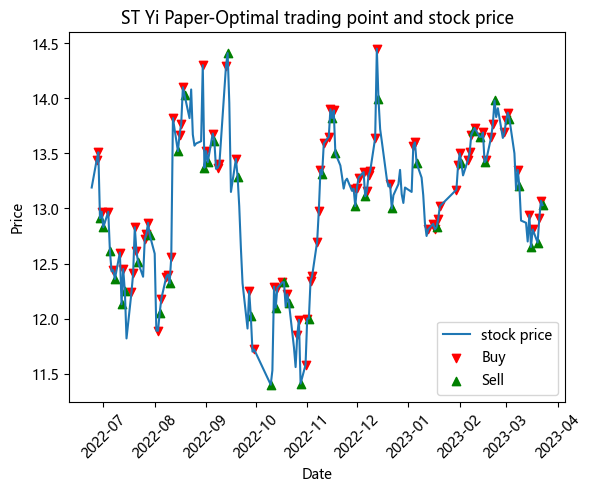

ST Yi Paper总收益率为: 0.6165924705521866
Epoch 1/100
4/4 [==============================] - 0s 50ms/step - loss: 0.9567 - val_loss: 0.9237
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8295 - val_loss: 0.9339
Epoch 3/100
4/4 [==============================] - 0s 19ms/step - loss: 0.7982 - val_loss: 0.9450
Epoch 4/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7748 - val_loss: 0.9302
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7417 - val_loss: 0.8630
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6994 - val_loss: 0.7811
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6697 - val_loss: 0.7000
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6428 - val_loss: 0.6884
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6138 - val_loss: 0.6450
Epoch 10/100
4/4 [==============================] - 0s 19ms/step - loss: 0.5852 -

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 13ms/step - loss: 0.9373 - val_loss: 1.1016
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.8848 - val_loss: 1.0292
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: 0.8546 - val_loss: 1.0294
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 0.8170 - val_loss: 0.9851
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7876 - val_loss: 0.9808
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7485 - val_loss: 0.8780
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7025 - val_loss: 0.9209
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 0.6457 - val_loss: 0.8049
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: 0.5828 - val_loss: 0.7105
Epoch 10/100
15/15 [==============================] - 0s 6ms/step - loss: 0.5216 - val_loss: 0.6741
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 1.1706 - val_loss: 0.6626
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 1.1071 - val_loss: 0.6523
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 1.0758 - val_loss: 0.6416
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 1.0777 - val_loss: 0.6366
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 1.0507 - val_loss: 0.6098
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 1.0023 - val_loss: 0.6023
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9716 - val_loss: 0.5798
Epoch 8/100
19/19 [==============================] - 0s 5ms/step - loss: 0.9311 - val_loss: 0.5614
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8938 - val_loss: 0.5267
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8443 - val_loss: 0.5046
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 9ms/step - loss: 1.0369 - val_loss: 0.9780
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9538 - val_loss: 0.9417
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9083 - val_loss: 0.9246
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 0.8870 - val_loss: 0.8923
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8477 - val_loss: 0.8484
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7965 - val_loss: 0.8092
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7418 - val_loss: 0.7525
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6849 - val_loss: 0.6608
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 0.6613 - val_loss: 0.5957
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5564 - val_loss: 0.5408
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 1.0010 - val_loss: 0.9752
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9716 - val_loss: 0.9609
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 0.9579 - val_loss: 0.9509
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 0.9445 - val_loss: 0.9302
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9257 - val_loss: 0.9387
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9019 - val_loss: 0.8802
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 0.8819 - val_loss: 0.8517
Epoch 8/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8419 - val_loss: 0.8026
Epoch 9/100
26/26 [==============================] - 0s 4ms/step - loss: 0.7844 - val_loss: 0.7440
Epoch 10/100
26/26 [==============================] - 0s 4ms/step - loss: 0.7268 - val_loss: 0.6603
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
30/30 [==============================] - 0s 6ms/step - loss: 0.9460 - val_loss: 1.0021
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9178 - val_loss: 1.0326
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.8950 - val_loss: 0.9892
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8989 - val_loss: 0.9968
Epoch 5/100
30/30 [==============================] - 0s 2ms/step - loss: 0.8858 - val_loss: 0.9862
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.8713 - val_loss: 0.9779
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.8731 - val_loss: 0.9960
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8680 - val_loss: 0.9541
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.8378 - val_loss: 0.9803
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8344 - val_loss: 0.9527
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 1s 6ms/step - loss: 1.0406 - val_loss: 0.9655
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0077 - val_loss: 0.9689
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0015 - val_loss: 0.9466
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9934 - val_loss: 0.9474
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9885 - val_loss: 0.9834
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9841 - val_loss: 0.9342
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9726 - val_loss: 0.9179
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9575 - val_loss: 0.9078
Epoch 9/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9587 - val_loss: 0.9262
Epoch 10/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9394 - val_loss: 0.9036
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 47ms/step - loss: 1.0692 - val_loss: 1.2661
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9993 - val_loss: 1.2259
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9459 - val_loss: 1.2022
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9143 - val_loss: 1.1647
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8784 - val_loss: 1.1158
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8525 - val_loss: 1.0605
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8224 - val_loss: 1.0012
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7982 - val_loss: 0.9325
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7705 - val_loss: 0.8841
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7437 - val_loss: 0.8259
Epoch 11/100
4/4 [=

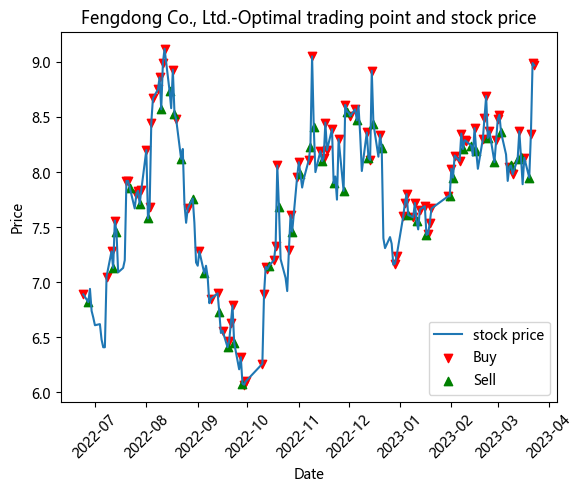

Fengdong Co., Ltd.总收益率为: 0.979721334387548
Epoch 1/100
4/4 [==============================] - 0s 43ms/step - loss: 0.9376 - val_loss: 0.8124
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.8566 - val_loss: 0.8120
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8290 - val_loss: 0.8038
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8081 - val_loss: 0.7877
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7850 - val_loss: 0.7567
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7595 - val_loss: 0.7367
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7400 - val_loss: 0.7159
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7189 - val_loss: 0.7044
Epoch 9/100
4/4 [==============================] - 0s 12ms/step - loss: 0.6987 - val_loss: 0.6789
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 16ms/step - loss: 0.8323 - val_loss: 1.0438
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7812 - val_loss: 1.0060
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7654 - val_loss: 0.9828
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7415 - val_loss: 0.9830
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7273 - val_loss: 0.9464
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7046 - val_loss: 0.9116
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6833 - val_loss: 0.8958
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6539 - val_loss: 0.8586
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6312 - val_loss: 0.8431
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6014 - val_loss: 0.7885
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.8603 - val_loss: 0.9982
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7563 - val_loss: 0.9771
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7307 - val_loss: 0.9394
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7156 - val_loss: 0.9188
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7001 - val_loss: 0.9307
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6693 - val_loss: 0.8813
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6499 - val_loss: 0.8526
Epoch 8/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6140 - val_loss: 0.8216
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 0.5762 - val_loss: 0.7620
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss: 0.5417 - val_loss: 0.7203
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.8717 - val_loss: 1.0374
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7918 - val_loss: 1.0074
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7400 - val_loss: 0.9302
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7315 - val_loss: 0.9308
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7066 - val_loss: 0.9034
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6910 - val_loss: 0.8820
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6664 - val_loss: 0.8587
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6397 - val_loss: 0.8185
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6167 - val_loss: 0.8003
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5843 - val_loss: 0.7562
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 0.8449 - val_loss: 1.0547
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7760 - val_loss: 0.9966
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7668 - val_loss: 0.9648
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7396 - val_loss: 0.9639
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7169 - val_loss: 0.9245
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6961 - val_loss: 0.8966
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6745 - val_loss: 0.8725
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6494 - val_loss: 0.8420
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6179 - val_loss: 0.7913
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss: 0.5766 - val_loss: 0.7946
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.8186 - val_loss: 1.0128
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7843 - val_loss: 1.0316
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7506 - val_loss: 0.9816
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7380 - val_loss: 0.9621
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7168 - val_loss: 0.9584
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7042 - val_loss: 0.9212
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6767 - val_loss: 0.8960
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6598 - val_loss: 0.8664
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6362 - val_loss: 0.8289
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6062 - val_loss: 0.8014
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.8266 - val_loss: 1.0909
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7814 - val_loss: 1.0219
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7603 - val_loss: 0.9878
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7362 - val_loss: 0.9888
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7248 - val_loss: 0.9546
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6976 - val_loss: 0.9144
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6837 - val_loss: 0.8955
Epoch 8/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6622 - val_loss: 0.8559
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6424 - val_loss: 0.8419
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6169 - val_loss: 0.8025
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 1s 17ms/step - loss: 0.7987 - val_loss: 0.9911
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7787 - val_loss: 0.9620
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7601 - val_loss: 0.9461
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7392 - val_loss: 0.9265
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7326 - val_loss: 0.9301
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7066 - val_loss: 0.8596
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6847 - val_loss: 0.8589
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6620 - val_loss: 0.8272
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6563 - val_loss: 0.7738
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6100 - val_loss: 0.7829
Epoch 11

<ipython-input-4-162043647918>:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:368: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

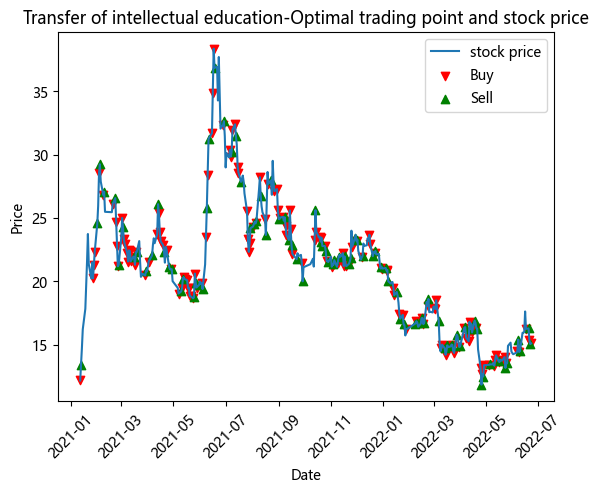

Transfer of intellectual education总收益率为: -0.17033346088236367
Epoch 1/100
4/4 [==============================] - 0s 43ms/step - loss: 1.1488 - val_loss: 0.7393
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 1.0361 - val_loss: 0.8362
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0150 - val_loss: 0.8488
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9996 - val_loss: 0.7896
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9718 - val_loss: 0.7484
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9668 - val_loss: 0.7176
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9598 - val_loss: 0.7166
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9511 - val_loss: 0.7399
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9423 - val_loss: 0.7544
Epoch 10/100
4/4 [==============================] - 0s 1

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 12ms/step - loss: 1.1808 - val_loss: 0.8880
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 1.1129 - val_loss: 0.8766
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0677 - val_loss: 0.8604
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0482 - val_loss: 0.8512
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0141 - val_loss: 0.8224
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9896 - val_loss: 0.8078
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0450 - val_loss: 0.7918
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9208 - val_loss: 0.7540
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9204 - val_loss: 0.7543
Epoch 10/100
15/15 [==============================] - 0s 5ms/step - loss: 0.8407 - val_loss: 0.6851
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 0.9659 - val_loss: 1.0724
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8955 - val_loss: 1.0622
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8812 - val_loss: 1.0408
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8633 - val_loss: 1.0299
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8448 - val_loss: 1.0123
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8455 - val_loss: 0.9983
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8229 - val_loss: 1.0065
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7981 - val_loss: 0.9931
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7859 - val_loss: 0.9765
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7631 - val_loss: 0.9589
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 1.0929 - val_loss: 0.7618
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 1.0251 - val_loss: 0.7624
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9867 - val_loss: 0.7486
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9453 - val_loss: 0.7384
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9068 - val_loss: 0.7227
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8686 - val_loss: 0.7083
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8264 - val_loss: 0.6862
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7967 - val_loss: 0.6528
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7522 - val_loss: 0.6743
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 0.6780 - val_loss: 0.6029
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 0.9542 - val_loss: 1.1008
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8907 - val_loss: 1.0536
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8668 - val_loss: 1.0535
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8422 - val_loss: 1.0323
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8105 - val_loss: 0.9903
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7877 - val_loss: 0.9426
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7528 - val_loss: 0.9459
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7059 - val_loss: 0.8221
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.6362 - val_loss: 0.7704
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.6120 - val_loss: 0.6421
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 1s 8ms/step - loss: 1.0217 - val_loss: 0.8091
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9801 - val_loss: 0.8141
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9743 - val_loss: 0.7786
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9538 - val_loss: 0.7739
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9420 - val_loss: 0.7388
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9195 - val_loss: 0.7448
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8968 - val_loss: 0.7284
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8782 - val_loss: 0.6711
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8313 - val_loss: 0.6901
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7913 - val_loss: 0.6145
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 1s 6ms/step - loss: 1.0188 - val_loss: 0.8458
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9863 - val_loss: 0.7957
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9661 - val_loss: 0.7830
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9403 - val_loss: 0.7611
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9172 - val_loss: 0.7345
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9061 - val_loss: 0.7289
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8786 - val_loss: 0.6927
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8492 - val_loss: 0.6748
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8091 - val_loss: 0.6453
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7547 - val_loss: 0.6074
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 1s 8ms/step - loss: 1.0576 - val_loss: 0.8451
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 1.0097 - val_loss: 0.8286
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9991 - val_loss: 0.8042
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9821 - val_loss: 0.7740
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9636 - val_loss: 0.7795
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9389 - val_loss: 0.7756
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9358 - val_loss: 0.7390
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9007 - val_loss: 0.7181
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8847 - val_loss: 0.7053
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8645 - val_loss: 0.6789
Epoch 11/

<ipython-input-4-162043647918>:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:368: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

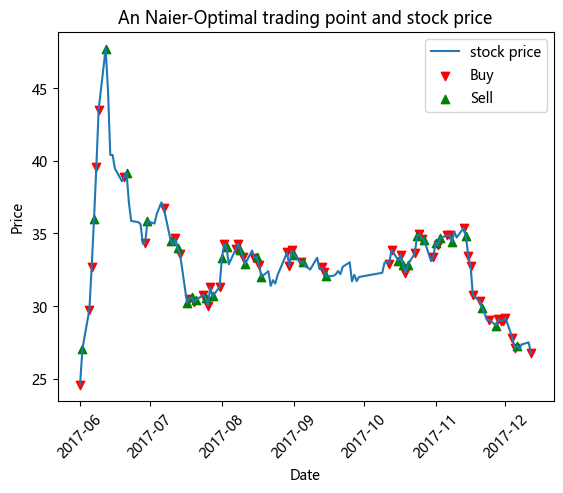

An Naier总收益率为: 0.0
Epoch 1/100
4/4 [==============================] - 0s 47ms/step - loss: 0.9037 - val_loss: 1.2363
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.8211 - val_loss: 1.2123
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7450 - val_loss: 1.2223
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6986 - val_loss: 1.2308
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.6534 - val_loss: 1.2531
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6210 - val_loss: 1.2684
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.5994 - val_loss: 1.2689
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5798 - val_loss: 1.2425
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5618 - val_loss: 1.2029
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5494 - val_loss: 1.1572


<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 1s 13ms/step - loss: 1.0526 - val_loss: 0.8111
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.9795 - val_loss: 0.7931
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9268 - val_loss: 0.7652
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9053 - val_loss: 0.7527
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8868 - val_loss: 0.7552
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8615 - val_loss: 0.7315
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.8448 - val_loss: 0.7183
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8243 - val_loss: 0.7000
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8072 - val_loss: 0.6710
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8088 - val_loss: 0.6756
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 0.9567 - val_loss: 0.9976
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9292 - val_loss: 1.0003
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9158 - val_loss: 0.9767
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8953 - val_loss: 0.9339
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8869 - val_loss: 0.9716
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8714 - val_loss: 0.9331
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8609 - val_loss: 0.9078
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8439 - val_loss: 0.8966
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8199 - val_loss: 0.8537
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8082 - val_loss: 0.8493
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 0.9795 - val_loss: 0.8323
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9401 - val_loss: 0.8294
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9310 - val_loss: 0.8402
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9129 - val_loss: 0.8223
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9070 - val_loss: 0.8371
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9041 - val_loss: 0.8206
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8998 - val_loss: 0.8223
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8854 - val_loss: 0.7945
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8750 - val_loss: 0.7908
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8546 - val_loss: 0.7572
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 0.9425 - val_loss: 0.9723
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9012 - val_loss: 0.9754
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8996 - val_loss: 0.9734
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8891 - val_loss: 0.9927
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8863 - val_loss: 0.9909
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8833 - val_loss: 0.9773
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8758 - val_loss: 0.9683
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8726 - val_loss: 0.9692
Epoch 9/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8590 - val_loss: 0.9590
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8543 - val_loss: 0.9464
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
30/30 [==============================] - 0s 6ms/step - loss: 0.9261 - val_loss: 0.9176
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9172 - val_loss: 0.9202
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8929 - val_loss: 0.9098
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8886 - val_loss: 0.9228
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8841 - val_loss: 0.9096
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8892 - val_loss: 0.9171
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8802 - val_loss: 0.9197
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8741 - val_loss: 0.9231
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8705 - val_loss: 0.9142
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8687 - val_loss: 0.9142
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 0s 6ms/step - loss: 1.0660 - val_loss: 0.8720
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0150 - val_loss: 0.8766
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0124 - val_loss: 0.8647
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9993 - val_loss: 0.8431
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9858 - val_loss: 0.8384
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9790 - val_loss: 0.8195
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9685 - val_loss: 0.8207
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9639 - val_loss: 0.8036
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9478 - val_loss: 0.8259
Epoch 10/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9399 - val_loss: 0.8011
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 45ms/step - loss: 1.3992 - val_loss: 1.1496
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 1.1964 - val_loss: 1.1385
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0528 - val_loss: 1.1525
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9421 - val_loss: 1.1489
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8316 - val_loss: 1.1407
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7825 - val_loss: 1.1395
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7099 - val_loss: 1.1518
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6611 - val_loss: 1.1405
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6264 - val_loss: 1.1128
Epoch 10/100
4/4 [==============================] - 0s 15ms/step - loss: 0.5879 - val_loss: 1.0962
Epoch 11/100
4/4 [=

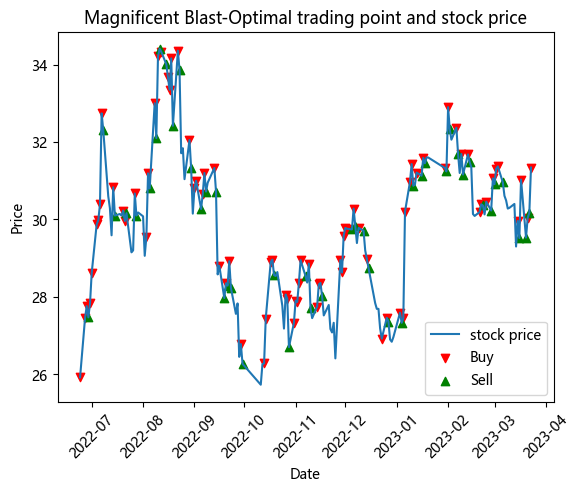

Magnificent Blast总收益率为: 0.8138325866596838
Epoch 1/100
4/4 [==============================] - 0s 46ms/step - loss: 1.0349 - val_loss: 0.9665
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9887 - val_loss: 0.9539
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9625 - val_loss: 0.9435
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9460 - val_loss: 0.9391
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.9333 - val_loss: 0.9358
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.9179 - val_loss: 0.9285
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9053 - val_loss: 0.9201
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8927 - val_loss: 0.9143
Epoch 9/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8834 - val_loss: 0.9135
Epoch 10/100
4/4 [==============================] - 0s 17ms/step - loss: 0.

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.7997 - val_loss: 0.6765
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7466 - val_loss: 0.6122
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7254 - val_loss: 0.6000
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7104 - val_loss: 0.6020
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7012 - val_loss: 0.5895
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6968 - val_loss: 0.5776
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6801 - val_loss: 0.5810
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6693 - val_loss: 0.5715
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6607 - val_loss: 0.5568
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6523 - val_loss: 0.5483
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 16ms/step - loss: 0.8183 - val_loss: 0.6440
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7454 - val_loss: 0.6087
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7236 - val_loss: 0.5932
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7095 - val_loss: 0.5934
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6986 - val_loss: 0.5840
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6854 - val_loss: 0.5731
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6754 - val_loss: 0.5578
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6622 - val_loss: 0.5493
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6519 - val_loss: 0.5447
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6428 - val_loss: 0.5259
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.7520 - val_loss: 0.6012
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7149 - val_loss: 0.5940
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7003 - val_loss: 0.5936
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6874 - val_loss: 0.5899
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6808 - val_loss: 0.5756
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6693 - val_loss: 0.5590
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6572 - val_loss: 0.5573
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6452 - val_loss: 0.5536
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6381 - val_loss: 0.5388
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6223 - val_loss: 0.5304
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.8665 - val_loss: 0.6755
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7364 - val_loss: 0.6310
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7237 - val_loss: 0.6305
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7158 - val_loss: 0.6264
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7022 - val_loss: 0.6124
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6869 - val_loss: 0.6034
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6776 - val_loss: 0.5854
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6638 - val_loss: 0.5795
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6572 - val_loss: 0.5626
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6515 - val_loss: 0.5669
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.7705 - val_loss: 0.6121
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7298 - val_loss: 0.6034
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7117 - val_loss: 0.5890
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7027 - val_loss: 0.5886
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6974 - val_loss: 0.5815
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6868 - val_loss: 0.5864
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6825 - val_loss: 0.5763
Epoch 8/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6741 - val_loss: 0.5741
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6674 - val_loss: 0.5740
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6585 - val_loss: 0.5638
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.8030 - val_loss: 0.6072
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7265 - val_loss: 0.6011
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7007 - val_loss: 0.5795
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6860 - val_loss: 0.5727
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6741 - val_loss: 0.5556
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6580 - val_loss: 0.5463
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6455 - val_loss: 0.5482
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6330 - val_loss: 0.5270
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6208 - val_loss: 0.5417
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss: 0.5959 - val_loss: 0.4941
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.7739 - val_loss: 0.6040
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7221 - val_loss: 0.5948
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7056 - val_loss: 0.5914
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7041 - val_loss: 0.5904
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6894 - val_loss: 0.5806
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6821 - val_loss: 0.5810
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6770 - val_loss: 0.5806
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6669 - val_loss: 0.5617
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6616 - val_loss: 0.5688
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6499 - val_loss: 0.5643
Epoch 11

<ipython-input-4-162043647918>:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:368: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

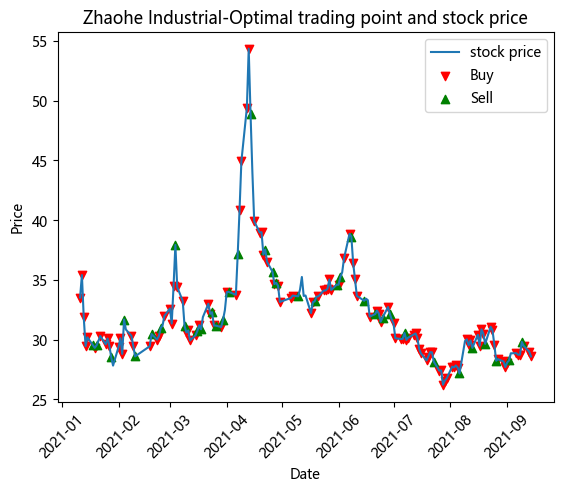

Zhaohe Industrial总收益率为: 0.0
Epoch 1/100
4/4 [==============================] - 0s 51ms/step - loss: 0.9099 - val_loss: 0.8848
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8463 - val_loss: 0.8654
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8107 - val_loss: 0.8545
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 0.7771 - val_loss: 0.8484
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.7476 - val_loss: 0.8496
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.7117 - val_loss: 0.8456
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6899 - val_loss: 0.8394
Epoch 8/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6589 - val_loss: 0.8333
Epoch 9/100
4/4 [==============================] - 0s 12ms/step - loss: 0.6334 - val_loss: 0.8227
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6048 - val_loss

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 12ms/step - loss: 0.9165 - val_loss: 1.1580
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8577 - val_loss: 1.0632
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8317 - val_loss: 1.0485
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8110 - val_loss: 1.0290
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7985 - val_loss: 0.9983
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7793 - val_loss: 0.9775
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7576 - val_loss: 0.9343
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7319 - val_loss: 0.9317
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7085 - val_loss: 0.8614
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6871 - val_loss: 0.8408
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 0.9984 - val_loss: 1.1847
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9483 - val_loss: 1.1624
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9290 - val_loss: 1.1608
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9185 - val_loss: 1.1688
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9191 - val_loss: 1.1520
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9013 - val_loss: 1.1352
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8887 - val_loss: 1.1307
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8710 - val_loss: 1.1211
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8566 - val_loss: 1.1218
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8485 - val_loss: 1.0988
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 1.0470 - val_loss: 0.8562
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 1.0027 - val_loss: 0.8459
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9938 - val_loss: 0.8277
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9754 - val_loss: 0.8339
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9697 - val_loss: 0.8317
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9624 - val_loss: 0.8215
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9472 - val_loss: 0.8079
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9395 - val_loss: 0.7968
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9252 - val_loss: 0.8019
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9236 - val_loss: 0.7683
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 0.9954 - val_loss: 0.8393
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9653 - val_loss: 0.8379
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9474 - val_loss: 0.8339
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9319 - val_loss: 0.8178
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9384 - val_loss: 0.8234
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9280 - val_loss: 0.8036
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8950 - val_loss: 0.7746
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8804 - val_loss: 0.7586
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8609 - val_loss: 0.7368
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8247 - val_loss: 0.7115
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 0s 7ms/step - loss: 0.9736 - val_loss: 1.1120
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9155 - val_loss: 1.1041
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9127 - val_loss: 1.0712
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9086 - val_loss: 1.0628
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8959 - val_loss: 1.0591
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8789 - val_loss: 1.0583
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8706 - val_loss: 1.0236
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8598 - val_loss: 1.0014
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8436 - val_loss: 1.0246
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8314 - val_loss: 0.9683
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9597 - val_loss: 1.1826
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9296 - val_loss: 1.1212
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9250 - val_loss: 1.1501
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9096 - val_loss: 1.1395
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9070 - val_loss: 1.0909
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8964 - val_loss: 1.0984
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8839 - val_loss: 1.0972
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8749 - val_loss: 1.1039
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8479 - val_loss: 1.1243
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8373 - val_loss: 1.0362
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 46ms/step - loss: 1.0456 - val_loss: 0.9454
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9267 - val_loss: 0.8924
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8660 - val_loss: 0.8678
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8434 - val_loss: 0.8561
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8119 - val_loss: 0.8480
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7897 - val_loss: 0.8402
Epoch 7/100
4/4 [==============================] - 0s 17ms/step - loss: 0.7633 - val_loss: 0.8369
Epoch 8/100
4/4 [==============================] - 0s 15ms/step - loss: 0.7458 - val_loss: 0.8335
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7260 - val_loss: 0.8253
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7072 - val_loss: 0.8126
Epoch 11/100
4/4 [=

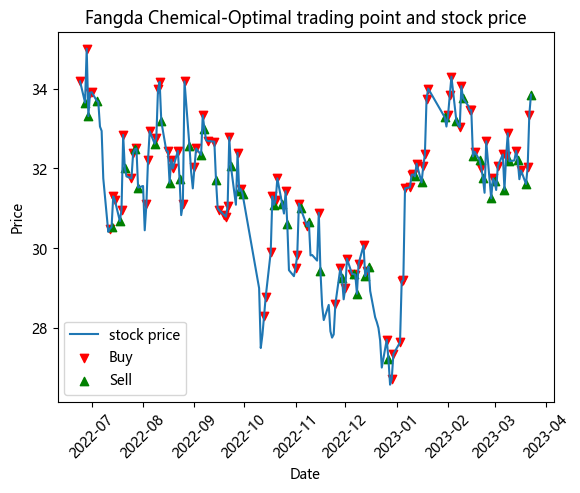

Fangda Chemical总收益率为: 0.6853736805240515
Epoch 1/100
4/4 [==============================] - 0s 45ms/step - loss: 0.8660 - val_loss: 2.1612
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7907 - val_loss: 2.2753
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7716 - val_loss: 2.3241
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7567 - val_loss: 2.3419
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7353 - val_loss: 2.2524
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7151 - val_loss: 2.1739
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6967 - val_loss: 2.0999
Epoch 8/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6816 - val_loss: 2.0118
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6664 - val_loss: 1.9557
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.65

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 1.0474 - val_loss: 0.7680
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9947 - val_loss: 0.7553
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9694 - val_loss: 0.7455
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9457 - val_loss: 0.7203
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9202 - val_loss: 0.7195
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8940 - val_loss: 0.6905
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8734 - val_loss: 0.7024
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8402 - val_loss: 0.6524
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8142 - val_loss: 0.6345
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7830 - val_loss: 0.6082
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 1s 9ms/step - loss: 0.9676 - val_loss: 0.8932
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9260 - val_loss: 0.8820
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9168 - val_loss: 0.8292
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8655 - val_loss: 0.8204
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8257 - val_loss: 0.7786
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7836 - val_loss: 0.7194
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7259 - val_loss: 0.6521
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6868 - val_loss: 0.5961
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6116 - val_loss: 0.5452
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.5563 - val_loss: 0.4655
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 1.0754 - val_loss: 0.8192
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 1.0210 - val_loss: 0.8157
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9976 - val_loss: 0.7774
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9671 - val_loss: 0.7792
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9460 - val_loss: 0.7422
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9176 - val_loss: 0.7155
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8885 - val_loss: 0.6817
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8337 - val_loss: 0.6416
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8100 - val_loss: 0.5868
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7207 - val_loss: 0.5479
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 0.9424 - val_loss: 1.0385
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9047 - val_loss: 1.0265
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8892 - val_loss: 1.0213
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8579 - val_loss: 0.9873
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8530 - val_loss: 0.9609
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8207 - val_loss: 0.9273
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7826 - val_loss: 0.8953
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7449 - val_loss: 0.8354
Epoch 9/100
26/26 [==============================] - 0s 4ms/step - loss: 0.7084 - val_loss: 0.7927
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.6616 - val_loss: 0.7195
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 0s 6ms/step - loss: 1.0682 - val_loss: 0.9912
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 1.0146 - val_loss: 0.9416
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9985 - val_loss: 0.9441
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9880 - val_loss: 0.9249
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9846 - val_loss: 0.9215
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9730 - val_loss: 0.9024
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9340 - val_loss: 0.8594
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9227 - val_loss: 0.8444
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8794 - val_loss: 0.8102
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8578 - val_loss: 0.8082
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 1s 6ms/step - loss: 1.1232 - val_loss: 0.8625
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0450 - val_loss: 0.8560
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0390 - val_loss: 0.8563
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0352 - val_loss: 0.8586
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0231 - val_loss: 0.8475
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0232 - val_loss: 0.8523
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0183 - val_loss: 0.8450
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0144 - val_loss: 0.8362
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0085 - val_loss: 0.8343
Epoch 10/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0000 - val_loss: 0.8450
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 46ms/step - loss: 0.8244 - val_loss: 1.6385
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7467 - val_loss: 1.7474
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7205 - val_loss: 1.8618
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6901 - val_loss: 1.9054
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6785 - val_loss: 1.9506
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6605 - val_loss: 1.9568
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6463 - val_loss: 1.9146
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6348 - val_loss: 1.8760
Epoch 9/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6225 - val_loss: 1.8562
Epoch 10/100
4/4 [==============================] - 0s 17ms/step - loss: 0.6066 - val_loss: 1.8158
Epoch 11/100
4/4 [=

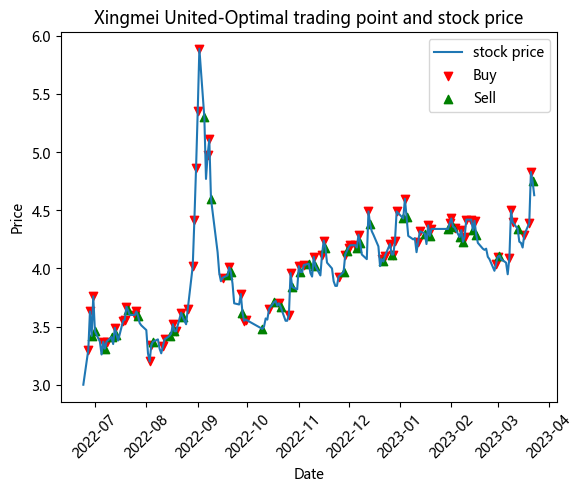

Xingmei United总收益率为: 1.2357902128613318
Epoch 1/100
4/4 [==============================] - 1s 45ms/step - loss: 1.0786 - val_loss: 0.8464
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9873 - val_loss: 0.8136
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9450 - val_loss: 0.7931
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9150 - val_loss: 0.7610
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8915 - val_loss: 0.7333
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8598 - val_loss: 0.7150
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8372 - val_loss: 0.6972
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8138 - val_loss: 0.6844
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.7931 - val_loss: 0.6769
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.764

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 0.9539 - val_loss: 1.1367
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9098 - val_loss: 1.1079
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8905 - val_loss: 1.0821
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8706 - val_loss: 1.0815
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8459 - val_loss: 1.0526
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8358 - val_loss: 1.0091
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.8089 - val_loss: 0.9712
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7809 - val_loss: 0.9367
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7584 - val_loss: 0.9169
Epoch 10/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7233 - val_loss: 0.8802
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 0.9132 - val_loss: 0.9242
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8622 - val_loss: 0.9421
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8413 - val_loss: 0.9352
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8284 - val_loss: 0.9512
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7944 - val_loss: 0.9046
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7807 - val_loss: 0.8895
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7509 - val_loss: 0.8585
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7157 - val_loss: 0.8286
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6705 - val_loss: 0.7599
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6307 - val_loss: 0.6887
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 0.9210 - val_loss: 1.0838
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8865 - val_loss: 1.0499
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8470 - val_loss: 1.0644
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8172 - val_loss: 0.9792
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7890 - val_loss: 0.9338
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7393 - val_loss: 0.8986
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6985 - val_loss: 0.8742
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6363 - val_loss: 0.7431
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5568 - val_loss: 0.6953
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.4704 - val_loss: 0.5683
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
24/24 [==============================] - 0s 7ms/step - loss: 0.9722 - val_loss: 1.0318
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.9368 - val_loss: 0.9991
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.8995 - val_loss: 0.9721
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.8581 - val_loss: 0.9326
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.8166 - val_loss: 0.8583
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.7400 - val_loss: 0.7896
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6629 - val_loss: 0.6954
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5478 - val_loss: 0.5989
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.4415 - val_loss: 0.4636
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.3443 - val_loss: 0.3463
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
28/28 [==============================] - 0s 6ms/step - loss: 1.0470 - val_loss: 0.8072
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 0.9627 - val_loss: 0.8321
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 0.9410 - val_loss: 0.8213
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 0.9168 - val_loss: 0.8189
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8925 - val_loss: 0.8049
Epoch 6/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8732 - val_loss: 0.8005
Epoch 7/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8481 - val_loss: 0.7747
Epoch 8/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8136 - val_loss: 0.7668
Epoch 9/100
28/28 [==============================] - 0s 3ms/step - loss: 0.7795 - val_loss: 0.7421
Epoch 10/100
28/28 [==============================] - 0s 3ms/step - loss: 0.7349 - val_loss: 0.6836
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
32/32 [==============================] - 1s 6ms/step - loss: 0.9990 - val_loss: 1.0928
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9712 - val_loss: 1.0991
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9468 - val_loss: 1.0713
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9432 - val_loss: 1.0462
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9355 - val_loss: 1.0578
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9338 - val_loss: 1.0395
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9012 - val_loss: 1.0033
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8916 - val_loss: 1.0063
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8814 - val_loss: 0.9568
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8419 - val_loss: 0.9347
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 43ms/step - loss: 1.0200 - val_loss: 0.8050
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.9565 - val_loss: 0.7686
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9181 - val_loss: 0.7524
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8905 - val_loss: 0.7393
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8621 - val_loss: 0.7347
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8366 - val_loss: 0.7217
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8028 - val_loss: 0.7143
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7810 - val_loss: 0.6962
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7522 - val_loss: 0.6745
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7301 - val_loss: 0.6513
Epoch 11/100
4/4 [=

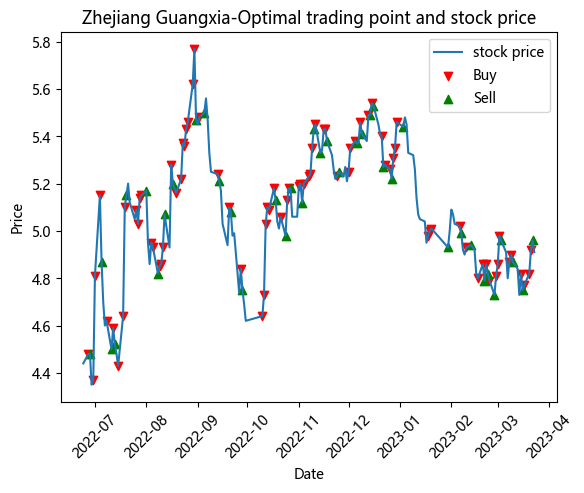

Zhejiang Guangxia总收益率为: 0.44051040536319686
Epoch 1/100
4/4 [==============================] - 0s 41ms/step - loss: 1.1325 - val_loss: 0.9443
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 1.0611 - val_loss: 0.8850
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 1.0303 - val_loss: 0.8535
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0054 - val_loss: 0.8406
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9934 - val_loss: 0.8330
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9732 - val_loss: 0.8349
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9652 - val_loss: 0.8423
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9512 - val_loss: 0.8172
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9341 - val_loss: 0.7942
Epoch 10/100
4/4 [==============================] - 0s 16ms/step - loss: 0

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 0.9991 - val_loss: 0.6780
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9389 - val_loss: 0.6508
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8943 - val_loss: 0.6715
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.8745 - val_loss: 0.6465
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8603 - val_loss: 0.6557
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8208 - val_loss: 0.6122
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7930 - val_loss: 0.6234
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7459 - val_loss: 0.6059
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7173 - val_loss: 0.5871
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6877 - val_loss: 0.5644
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 1s 11ms/step - loss: 1.0543 - val_loss: 0.8272
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9769 - val_loss: 0.8130
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9420 - val_loss: 0.8003
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9018 - val_loss: 0.7746
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8726 - val_loss: 0.7432
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8180 - val_loss: 0.6878
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7703 - val_loss: 0.6464
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6851 - val_loss: 0.6286
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6417 - val_loss: 0.5499
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6043 - val_loss: 0.4754
Epoch 11

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 0.9665 - val_loss: 0.9380
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9078 - val_loss: 0.9217
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8682 - val_loss: 0.9144
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8270 - val_loss: 0.8528
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7760 - val_loss: 0.7720
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7088 - val_loss: 0.6961
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6521 - val_loss: 0.6513
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5856 - val_loss: 0.5370
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.4998 - val_loss: 0.4724
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.4595 - val_loss: 0.4821
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 1s 7ms/step - loss: 1.0275 - val_loss: 1.0556
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9348 - val_loss: 1.0142
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8987 - val_loss: 1.0033
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8771 - val_loss: 0.9779
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8463 - val_loss: 0.9514
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8141 - val_loss: 0.9184
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7775 - val_loss: 0.8818
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7563 - val_loss: 0.8656
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.6951 - val_loss: 0.7977
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.6293 - val_loss: 0.7473
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 1s 7ms/step - loss: 0.9788 - val_loss: 1.0894
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9453 - val_loss: 1.0576
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9416 - val_loss: 1.0633
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9166 - val_loss: 1.0451
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8999 - val_loss: 1.0063
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9027 - val_loss: 1.0284
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8596 - val_loss: 0.9761
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8229 - val_loss: 0.9440
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7990 - val_loss: 0.9911
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7812 - val_loss: 0.8583
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9260 - val_loss: 0.9418
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8821 - val_loss: 0.9165
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8648 - val_loss: 0.9159
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8734 - val_loss: 0.9310
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8622 - val_loss: 0.8960
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8507 - val_loss: 0.9127
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8458 - val_loss: 0.9027
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8328 - val_loss: 0.8737
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8332 - val_loss: 0.8902
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8144 - val_loss: 0.8559
Epoch 11/

<ipython-input-4-162043647918>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-4-162043647918>:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-4-162043647918>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 45ms/step - loss: 1.1381 - val_loss: 0.9417
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 1.0593 - val_loss: 0.9058
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0183 - val_loss: 0.8911
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9912 - val_loss: 0.8561
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9731 - val_loss: 0.8377
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9511 - val_loss: 0.8194
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9310 - val_loss: 0.8024
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9137 - val_loss: 0.7814
Epoch 9/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8969 - val_loss: 0.7750
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8754 - val_loss: 0.7600
Epoch 11/100
4/4 [=

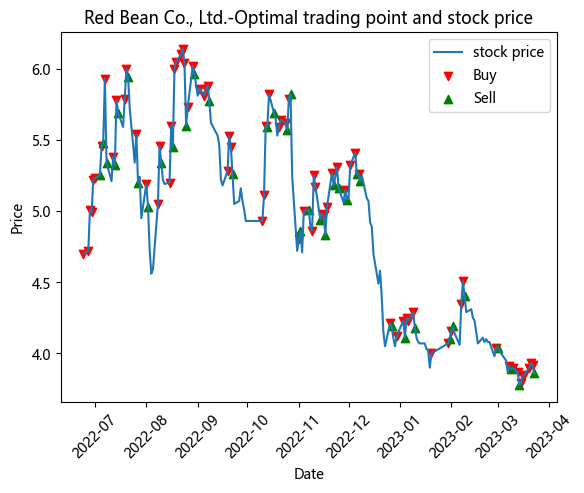

Red Bean Co., Ltd.总收益率为: 0.920600555509872


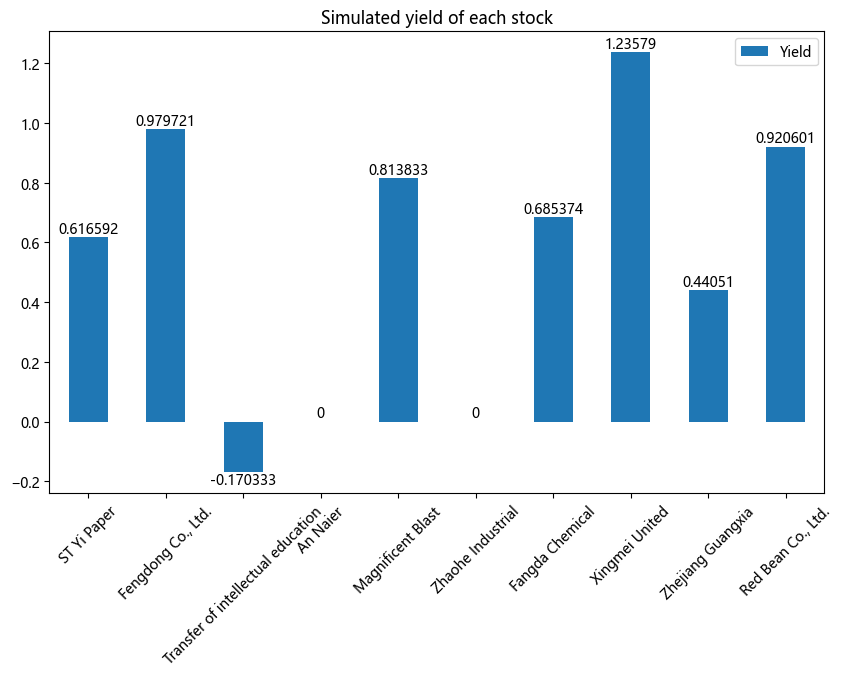

Simulated average yield of each stock:0.5522087784975508


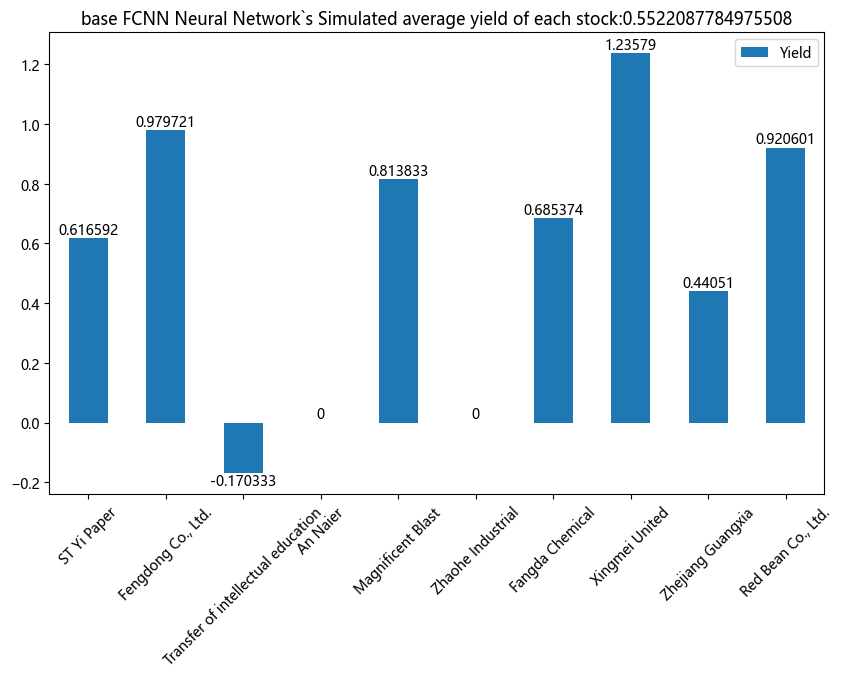

In [4]:
import openpyxl
from sklearn import svm
import xlrd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from translate import Translator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.optimize import minimize
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection
from sklearn.metrics import r2_score
import time

if not os.path.exists('Output'):
    os.makedirs('Output')
if not os.path.exists('min'):
    os.makedirs('min')
def train(model, x_train, y_train):
    model.fit(x_train, y_train.ravel())
def print_accuracy(model, x_train, y_train, x_test, y_test):
    print('SVM-输出训练集的准确率为:', model.score(x_train, y_train))
    print("SVM-输出测试集的准确率为:", model.score(x_test, y_test))
    # 原始结果与预测结果进行对比
    show_accuracy(model.predict(x_train), y_train, 'traing data')
    show_accuracy(model.predict(x_test), y_test, 'testing data')
    # 计算决策函数的值
    print('decision_function:\n', model.decision_function(x_train))

def show_accuracy(a, b, tip):
    acc = (a.ravel() == b.ravel())
    print("%s Accuracy:%.3f" % (tip, np.mean(acc)))

buy_threshold =0.08
sell_threshold =0.05

#'交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元'
# 设置相对路径
data_path = "./data"              ###股票十年历史数据所在文件夹
max_longs = 2000                    ####总日期长度
SF='FCNN神经网络'
translator = Translator(from_lang='zh', to_lang='en')
SF = translator.translate(SF)
# 创建空DataFrame来存储所有表格的数据
all_data = pd.DataFrame()
row_index2 = ['total time(s)', 'total revenue(%)', 'train_accuracy', 'test_accuracy']
# 创建一个空的DataFrame
table2_data = pd.DataFrame(index=row_index2)
row_index = ['Longs=183','Longs=366','Longs=549','Longs=732','Longs=915','Longs=1098','Longs=1281','Longs=1464','Longs=1647']
# 创建一个空的DataFrame
table1_data = pd.DataFrame(index=row_index)
########################如果文件是一个，分成不同的工作表，以下代码是先将工作表分开##########
# 打开Excel文件
workbook = xlrd.open_workbook("data\\股票十年历史数据.xls")

# 遍历每个工作表
for sheet_name in workbook.sheet_names():
    # 选择工作表
    sheet = workbook.sheet_by_name(sheet_name)
    # 创建一个新的Excel文件
    new_workbook = openpyxl.Workbook()

    # 选择新的工作表，并将数据复制到该工作表中
    new_sheet = new_workbook.active
    new_sheet.title = sheet_name
    for row in range(sheet.nrows):
        for col in range(sheet.ncols):
            # 检查是否为“交易日期”列
            if sheet.cell_value(0, col) == "交易日期":
                # 如果是，则将单元格格式设置为日期时间格式
                cell = new_sheet.cell(row=row+1, column=col+1)
                cell.value = sheet.cell_value(row, col)
                cell.number_format = "yyyy/m/d h:mm:ss"
            else:
                # 如果不是，则直接复制单元格的值
                new_sheet.cell(row=row+1, column=col+1).value = sheet.cell_value(row, col)
    # 获取“证券简称”列第一个数据
    security_name = sheet.cell_value(1, 1)

    # 去除文件名中的非法字符
    for char in ["\\", "/", ":", "*", "?", "\"", "<", ">", "|"]:
        security_name = security_name.replace(char, "")

    # 将工作表保存到新的Excel文件中，并将文件命名为“证券简称”列第一个数据
    new_workbook.save(os.path.join("data", f"{security_name}.xls"))

    # # 将工作表保存到新的Excel文件中
    # new_workbook.save(os.path.join("data", f"{sheet_name}.xls"))
##########################################################################################   



# 遍历"data"文件夹中的所有文件
for filename in os.listdir(data_path):
    if filename == "股票十年历史数据.xls":
       # 如果文件名是"股票十年历史数据.xls"，则跳过该文件
        continue
    if filename.endswith(".xls"):
        filepath = os.path.join(data_path, filename)
        # 读取表格数据
        df = pd.read_excel(filepath)#####################################
        
        nameT = os.path.splitext(os.path.basename(filename))[0].split(' ')[0]
        nameT = translator.translate(nameT)
        start_time = time.time()
        time_list = []
        remark_list = []
        table2=[]
        def ff(longg):
            Longs=longg
            name=filepath
            TEXTname=name
            # 读取 XLS 文件
            df = pd.read_excel(name)
            df = df.iloc[-Longs:]
            # 选择需要的列并创建新的DataFrame
            data = df[['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']]
            dataL = data.set_index('交易日期')
            dataV= data
            # 重新命名列
            data.columns = ['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']
            df=data
            # 数据清洗
            df = df.drop_duplicates()  # 去重
            # 缺失值处理
            df = df.fillna(method='ffill')  # 用前一行的值填充缺失值
            # 异常值处理
            df = df[df['成交数量@单位：股'] > 0]  # 去除成交数量为负的数据
            # 特征工程
            df['涨跌幅'] = (df['最近成交'] - df['昨日收盘']) / df['昨日收盘']  # 计算涨跌幅
            dddate=df##后面画图还要用到日期，这里先保留在ddate里
            # 删除无用的特征
            df = df.drop(columns=['交易日期', '最近成交', '成交金额(人民币)@单位：元'])  
            # 数据标准化z = (x - u) / s：均值归零，方差化1
            scaler = StandardScaler()
            df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

            # 将数据分为特征和标签；自变量因变量
            X = df_scaled.drop(columns=['涨跌幅'])
            y = df_scaled[['涨跌幅']]

            # 将数据分为训练集和测试集
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # 构建CNN模型
            model = keras.Sequential([
                layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
                layers.Dense(64, activation='relu'),
                layers.Dense(1)
            ])
            model.compile(loss='mean_squared_error', optimizer='adam')

            # 训练模型
            model.fit(X_train, y_train, epochs=100, validation_split=0.2)
            # 在训练集和测试集上预测结果###########训练完成
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # 将预测结果映射为二分类结果（涨或跌）
            y_train_pred_binary = np.where(y_train_pred > 0, 1, 0)
            y_test_pred_binary = np.where(y_test_pred > 0, 1, 0)
            y_train_binary = np.where(y_train > 0, 1, 0)
            y_test_binary = np.where(y_test > 0, 1, 0)
            # 计算并输出准确率
            train_acc = accuracy_score(y_train_binary, y_train_pred_binary)
            test_acc = accuracy_score(y_test_binary, y_test_pred_binary)
            print("Train accuracy:", train_acc)
            print("Test accuracy:", test_acc)


            X1=X.iloc[:366,:]
            y_pred = model.predict(X1)
            yy = pd.DataFrame(y_pred, columns=[ '涨跌幅'])

            # RR=r2_score(y, y_pred)##R平方值
            # print(f'R平方值={RR}')
            # history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


            y_pred=yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
            df_scaled['策略'] = yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
            dataV2= dataV.iloc[:366, :]
            df_selected= df_scaled.iloc[:366, :]


            df_selected.index=df_selected.index+len(dddate)-Longs
            df_selected['今日开盘']=dataV2['今日开盘']

            # 初始化买入价格和买入索引
            buy_price = None
            buy_index = None

            # 初始化收益率和策略列表
            profits = []
            strategies = []
            for i, row in df_selected.iterrows():
                if y_pred[i-len(dddate)+Longs] == 1:
                    # 买入策略
                    buy_price = row['今日开盘']
                    buy_index = i
                    buy_cishu=1
                    profits.append(0)
                    strategies.append('买进')
                else:
                    # 卖出策略
                    if buy_price is not None:
                            profit = (row['今日开盘']*buy_cishu - buy_price) / (buy_price)
                            profits.append(profit)
                            strategies.append('卖出')
                            buy_price=None
                            buy_cishu=0
                    else:
                            # 如果当前没有持仓，就继续观望
                            profits.append(0)
                            strategies.append('持有')



            # 将收益率和策略列表添加到数据框中
            df_selected['收益率'] = profits
            df_selected['策略'] = strategies
            sum_B1 = df_selected['收益率'].sum()
            print(sum_B1)
            sum_B_list.append(float(sum_B1))
            return sum_B1

        sum_B_list = []
        # 定义参数的可能取值范围###############################
        min_longs = 1
        max_longs = 1800
        Longs_range = [i for i in range(min_longs, max_longs+1) if i % 183 == 0]

        # 初始化最大输出和对应的参数值
        max_mean = -np.inf
        best_Longs = None

        # 遍历所有可能的参数值
        for Longs in Longs_range:
            # 计算当前参数值对应的输出
            output = ff(Longs)
            
            # 如果当前输出比最大输出更大，则更新最大输出和对应的参数值
            if output > max_mean:
                max_mean = output
                best_Longs = Longs
        ########################################################

        Longs=best_Longs
        name=filepath
        TEXTname=name
        # 读取 XLS 文件
        df = pd.read_excel(name)
        dddate=df##后面画图还要用到日期，这里先保留在ddate里
        df = df.iloc[-Longs:]
        # 选择需要的列并创建新的DataFrame
        data = df[['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']]
        dataL = data.set_index('交易日期')
        dataV= data
        # 重新命名列
        data.columns = ['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']
        df=data
        # 数据清洗
        df = df.drop_duplicates()  # 去重
        # 缺失值处理
        df = df.fillna(method='ffill')  # 用前一行的值填充缺失值
        # 异常值处理
        df = df[df['成交数量@单位：股'] > 0]  # 去除成交数量为负的数据
        # 特征工程
        df['涨跌幅'] = (df['最近成交'] - df['昨日收盘']) / df['昨日收盘']  # 计算涨跌幅

        # 删除无用的特征
        df = df.drop(columns=['交易日期', '最近成交', '成交金额(人民币)@单位：元'])  
        # 数据标准化z = (x - u) / s：均值归零，方差化1
        scaler = StandardScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

        # 将数据分为特征和标签；自变量因变量
        X = df_scaled.drop(columns=['涨跌幅'])
        y = df_scaled[['涨跌幅']]

        # 将数据分为训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 构建CNN模型
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(loss='mean_squared_error', optimizer='adam')

        # 训练模型
        model.fit(X_train, y_train, epochs=100, validation_split=0.2)
        # 在训练集和测试集上预测结果###########训练完成
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # 将预测结果映射为二分类结果（涨或跌）
        y_train_pred_binary = np.where(y_train_pred > 0, 1, 0)
        y_test_pred_binary = np.where(y_test_pred > 0, 1, 0)
        y_train_binary = np.where(y_train > 0, 1, 0)
        y_test_binary = np.where(y_test > 0, 1, 0)
        # 计算并输出准确率
        train_acc = accuracy_score(y_train_binary, y_train_pred_binary)
        test_acc = accuracy_score(y_test_binary, y_test_pred_binary)
        print("Train accuracy:", train_acc)
        print("Test accuracy:", test_acc)


        X1=X.iloc[:366,:]
        y_pred = model.predict(X1)
        yy = pd.DataFrame(y_pred, columns=[ '涨跌幅'])

        # RR=r2_score(y, y_pred)##R平方值
        # print(f'R平方值={RR}')
        # history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


        y_pred=yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
        df_scaled['策略'] = yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
        dataV2= dataV.iloc[-366:, :]
        df_selected= df_scaled.iloc[:366, :]

        df_selected.index=df_selected.index+len(dddate)-Longs
        df_selected['今日开盘']=dataV2['今日开盘']

        # 初始化买入价格和买入索引
        buy_price = None
        buy_index = None

        # 初始化收益率和策略列表
        profits = []
        strategies = []

        for i, row in df_selected.iterrows():
            if y_pred[i-len(dddate)+Longs] == 1:
                # 买入策略
                buy_price = row['今日开盘']
                buy_index = i
                buy_cishu=1
                profits.append(0)
                strategies.append('买进')
            else:
                # 卖出策略
                if buy_price is not None:
                        profit = (row['今日开盘']*buy_cishu - buy_price) / (buy_price)
                        profits.append(profit)
                        strategies.append('卖出')
                        buy_price=None
                        buy_cishu=0
                else:
                        # 如果当前没有持仓，就继续观望
                        profits.append(0)
                        strategies.append('持有')



        # 将收益率和策略列表添加到数据框中
        df_selected['收益率'] = profits
        df_selected['策略'] = strategies
        sum_B = df_selected['收益率'].sum()
        print(sum_B)

        ddate=df_selected

        ddate['交易日期']=dddate['交易日期']
        ddate['最近成交']=dddate['最近成交']
        # ddate['策略'] = ddate['策略'].replace({'卖出': '买入', '买入': '卖出'})###买进卖出互换

        avg_ddate = ddate.groupby('交易日期')['最近成交'].mean()
        # 选择买入和卖出点的数据
        buy_points = ddate.loc[ddate['策略'] == '买进']
        sell_points = ddate.loc[ddate['策略'] == '卖出']
        # 绘制折线图和散点图
        plt.plot(avg_ddate.index, avg_ddate.values, label='stock price')
        plt.scatter(buy_points['交易日期'], buy_points['最近成交'], marker='v', color='red', label='Buy')
        plt.scatter(sell_points['交易日期'], sell_points['最近成交'], marker='^', color='green', label='Sell')
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{nameT}-Optimal trading point and stock price')
        # 显示折线图和散点图
        plt.savefig(f'Output/{nameT}-最优交易点与股票价格.png', bbox_inches='tight')
        plt.legend()
        plt.show()
        dd = ddate[['交易日期','策略']]
        dd.to_csv(f'Output/{nameT}-决策方案.csv',index=False)
        # 打印列B的总和
        print(f"{nameT}总收益率为:", sum_B)



        end_time = time.time()
        elapsed_time = end_time - start_time


        # 将table作为一列添加到DataFrame中
        table1_data[f'{nameT}'] = sum_B_list




        table2.append(elapsed_time)
        table2.append(sum_B)
        table2.append(train_acc)
        table2.append(test_acc)



        # 将table作为一列添加到DataFrame中
        table2_data[f'{nameT}'] = table2

        all_data.loc[nameT, "Yield"] = sum_B

# 可视化
all_data.to_csv('Output/各个股票的模拟收益率.csv')
all_data = pd.DataFrame(all_data)

# 绘制柱形图
ax = all_data.plot(kind='bar', figsize=(10, 6), rot=0)

# 添加详细纵坐标
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.xticks(rotation=45)
plt.title('Simulated yield of each stock')
plt.savefig(f'Output/{filename}-各个股票的模拟收益率.png', bbox_inches='tight')
plt.legend()
plt.show()
mean = all_data.mean().mean()
print(f'Simulated average yield of each stock:{mean}')
all_data.to_csv('Output/各个股票的模拟收益率.csv')
all_data = pd.DataFrame(all_data)

# 绘制柱形图
ax = all_data.plot(kind='bar', figsize=(10, 6), rot=0)

# 添加详细纵坐标
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.xticks(rotation=45)
plt.title(f'base {SF}`s Simulated average yield of each stock:{mean}')
plt.savefig(f'基于{SF}模型的股票总收益率.png', bbox_inches='tight')
plt.legend()
plt.show()
# 创建一个Styler对象
table1_data = table1_data.style

# 将每一列的最大值用红色字体标注
table1_data.highlight_max(color='red')
with pd.ExcelWriter(f'Output/基于{SF}模型的训练时长分析.xlsx') as writer:
    table1_data.to_excel(writer, index=True, sheet_name='数据')
# 创建一个Styler对象

#table1_data.to_csv(f'基于{SF}模型的训练时长分析.csv')
table2_data.to_csv(f'Output/基于{SF}模型的结果表.csv')

Epoch 1/100
4/4 [==============================] - 0s 41ms/step - loss: 0.9274 - val_loss: 0.9424
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8668 - val_loss: 0.9570
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8166 - val_loss: 0.9881
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 0.7815 - val_loss: 1.0029
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.7471 - val_loss: 0.9824
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7138 - val_loss: 0.9666
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6868 - val_loss: 0.9533
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6524 - val_loss: 0.9055
Epoch 9/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6217 - val_loss: 0.8647
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5914 - val_loss: 0.8398
Epoch 11/100
4/4 [=

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 1s 12ms/step - loss: 1.0090 - val_loss: 0.8840
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.9219 - val_loss: 0.8685
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8712 - val_loss: 0.8303
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8284 - val_loss: 0.8145
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7769 - val_loss: 0.7752
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7441 - val_loss: 0.7046
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6846 - val_loss: 0.6538
Epoch 8/100
15/15 [==============================] - 0s 6ms/step - loss: 0.6141 - val_loss: 0.5810
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: 0.5401 - val_loss: 0.5168
Epoch 10/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4735 - val_loss: 0.4627
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 8ms/step - loss: 0.9703 - val_loss: 1.2290
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9280 - val_loss: 1.1535
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 0.8930 - val_loss: 1.1937
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.8713 - val_loss: 1.1147
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8434 - val_loss: 1.0379
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8101 - val_loss: 1.0488
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7757 - val_loss: 0.9781
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7131 - val_loss: 0.8918
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6524 - val_loss: 0.8039
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.5858 - val_loss: 0.7739
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 1.0077 - val_loss: 1.1249
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 0.9545 - val_loss: 1.0422
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9211 - val_loss: 1.0059
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8871 - val_loss: 0.9594
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8446 - val_loss: 0.9272
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7900 - val_loss: 0.8677
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7243 - val_loss: 0.7716
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 0.6469 - val_loss: 0.7452
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 0.5755 - val_loss: 0.6280
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 0.5072 - val_loss: 0.5500
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 6ms/step - loss: 0.9535 - val_loss: 1.0465
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 0.9070 - val_loss: 1.0288
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8850 - val_loss: 1.0100
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8473 - val_loss: 1.0034
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8057 - val_loss: 0.9645
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.7547 - val_loss: 0.9067
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7043 - val_loss: 0.8499
Epoch 8/100
26/26 [==============================] - 0s 4ms/step - loss: 0.6483 - val_loss: 0.8170
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.5811 - val_loss: 0.7399
Epoch 10/100
26/26 [==============================] - 0s 5ms/step - loss: 0.5087 - val_loss: 0.6405
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
30/30 [==============================] - 0s 6ms/step - loss: 1.1061 - val_loss: 0.8703
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 1.0608 - val_loss: 0.8606
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 1.0584 - val_loss: 0.8454
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 1.0546 - val_loss: 0.8833
Epoch 5/100
30/30 [==============================] - 0s 2ms/step - loss: 1.0455 - val_loss: 0.8560
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 1.0304 - val_loss: 0.8573
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 1.0327 - val_loss: 0.8258
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 1.0144 - val_loss: 0.8324
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.9953 - val_loss: 0.8054
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9719 - val_loss: 0.8149
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 0s 5ms/step - loss: 1.0081 - val_loss: 1.0339
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9835 - val_loss: 1.0065
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9727 - val_loss: 0.9946
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9673 - val_loss: 0.9910
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9592 - val_loss: 0.9804
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9656 - val_loss: 0.9813
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9484 - val_loss: 0.9797
Epoch 8/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9352 - val_loss: 1.0002
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9120 - val_loss: 0.9369
Epoch 10/100
33/33 [==============================] - 0s 2ms/step - loss: 0.8938 - val_loss: 0.9260
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
8/8 [==============================] - 0s 17ms/step - loss: 1.1763 - val_loss: 0.7267
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0824 - val_loss: 0.6934
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0458 - val_loss: 0.6910
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9971 - val_loss: 0.5963
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.9602 - val_loss: 0.5617
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.9106 - val_loss: 0.5445
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8835 - val_loss: 0.5216
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 0.8203 - val_loss: 0.5164
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7817 - val_loss: 0.4802
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7280 - val_loss: 0.4512
Epoch 11/100
8/8 [==========

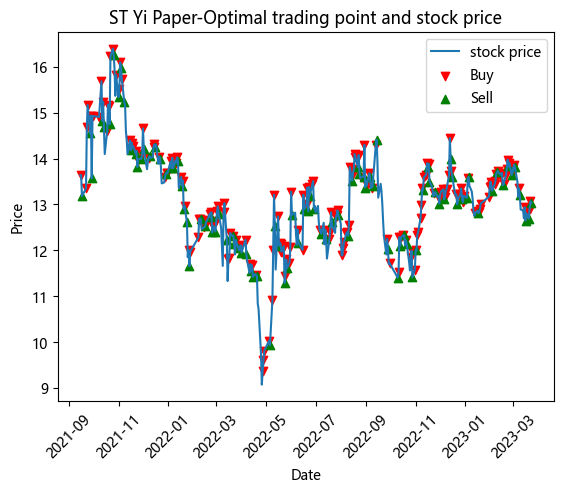

ST Yi Paper总收益率为: 1.3073222958204815
Epoch 1/100
4/4 [==============================] - 0s 43ms/step - loss: 0.9646 - val_loss: 1.1334
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.9002 - val_loss: 1.0814
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8508 - val_loss: 1.0050
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8101 - val_loss: 0.9522
Epoch 5/100
4/4 [==============================] - 0s 18ms/step - loss: 0.7816 - val_loss: 0.8736
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7493 - val_loss: 0.8228
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7211 - val_loss: 0.7746
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6881 - val_loss: 0.7688
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6587 - val_loss: 0.7619
Epoch 10/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6305 -

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 10ms/step - loss: 0.9646 - val_loss: 1.1111
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9269 - val_loss: 1.1000
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8850 - val_loss: 1.0591
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8616 - val_loss: 1.0620
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8478 - val_loss: 1.0955
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8135 - val_loss: 1.0200
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7848 - val_loss: 1.0237
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7710 - val_loss: 1.0095
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7221 - val_loss: 0.9157
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6784 - val_loss: 0.8839
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 8ms/step - loss: 1.3428 - val_loss: 0.6368
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0706 - val_loss: 0.6323
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0463 - val_loss: 0.6193
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0093 - val_loss: 0.5948
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9871 - val_loss: 0.5796
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9314 - val_loss: 0.5379
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8909 - val_loss: 0.5172
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8628 - val_loss: 0.4633
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 0.7836 - val_loss: 0.4568
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 0.7455 - val_loss: 0.4440
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 7ms/step - loss: 0.9769 - val_loss: 0.9815
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9349 - val_loss: 0.9487
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9101 - val_loss: 0.9233
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8814 - val_loss: 0.8958
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8505 - val_loss: 0.8743
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8188 - val_loss: 0.8419
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7905 - val_loss: 0.8183
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7432 - val_loss: 0.7491
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6959 - val_loss: 0.7042
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6414 - val_loss: 0.6639
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 6ms/step - loss: 1.0017 - val_loss: 0.9756
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9765 - val_loss: 0.9690
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9642 - val_loss: 0.9535
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9511 - val_loss: 0.9567
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9462 - val_loss: 0.9320
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9341 - val_loss: 0.9105
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9141 - val_loss: 0.8969
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8984 - val_loss: 0.8655
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8666 - val_loss: 0.8324
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8408 - val_loss: 0.7949
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
30/30 [==============================] - 0s 5ms/step - loss: 0.9679 - val_loss: 1.0197
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9091 - val_loss: 1.0093
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9070 - val_loss: 1.0047
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9056 - val_loss: 1.0184
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9001 - val_loss: 0.9798
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8900 - val_loss: 1.0061
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8819 - val_loss: 0.9807
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8720 - val_loss: 0.9611
Epoch 9/100
30/30 [==============================] - 0s 2ms/step - loss: 0.8722 - val_loss: 0.9540
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8583 - val_loss: 0.9445
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 0s 6ms/step - loss: 1.0509 - val_loss: 0.9860
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0357 - val_loss: 0.9685
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0192 - val_loss: 0.9700
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0117 - val_loss: 0.9600
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0051 - val_loss: 0.9565
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0039 - val_loss: 0.9514
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9973 - val_loss: 0.9721
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9877 - val_loss: 0.9342
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9832 - val_loss: 0.9300
Epoch 10/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9668 - val_loss: 0.9136
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
8/8 [==============================] - 0s 18ms/step - loss: 0.9973 - val_loss: 0.8101
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.9250 - val_loss: 0.7527
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9073 - val_loss: 0.7241
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8575 - val_loss: 0.7133
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8278 - val_loss: 0.7116
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7970 - val_loss: 0.6830
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7773 - val_loss: 0.6564
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7366 - val_loss: 0.6471
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7079 - val_loss: 0.6395
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6790 - val_loss: 0.6281
Epoch 11/100
8/8 [==========

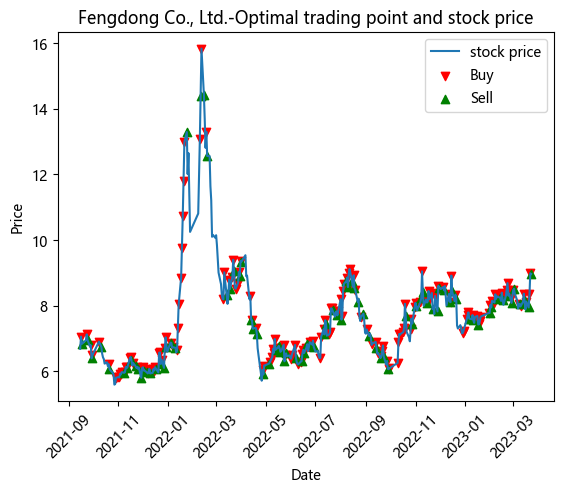

Fengdong Co., Ltd.总收益率为: 1.8731279774345504
Epoch 1/100
4/4 [==============================] - 0s 42ms/step - loss: 0.9956 - val_loss: 0.8300
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.8936 - val_loss: 0.8405
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8617 - val_loss: 0.8348
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.8379 - val_loss: 0.8193
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8139 - val_loss: 0.8030
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7938 - val_loss: 0.7856
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7760 - val_loss: 0.7668
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7555 - val_loss: 0.7403
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7380 - val_loss: 0.7182
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 12ms/step - loss: 0.8392 - val_loss: 1.0565
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7871 - val_loss: 1.0222
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7623 - val_loss: 0.9693
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7503 - val_loss: 0.9598
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7250 - val_loss: 0.9324
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7052 - val_loss: 0.9217
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6944 - val_loss: 0.8977
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6686 - val_loss: 0.8581
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6405 - val_loss: 0.8398
Epoch 10/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6282 - val_loss: 0.7964
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 13ms/step - loss: 0.8338 - val_loss: 1.0523
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.8043 - val_loss: 1.0351
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7551 - val_loss: 0.9815
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7420 - val_loss: 0.9616
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7258 - val_loss: 0.9736
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.7053 - val_loss: 0.9379
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6851 - val_loss: 0.9086
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6687 - val_loss: 0.9029
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6391 - val_loss: 0.8736
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6169 - val_loss: 0.8420
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 12ms/step - loss: 0.8829 - val_loss: 1.0771
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7975 - val_loss: 1.0202
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7603 - val_loss: 0.9672
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7416 - val_loss: 0.9406
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7200 - val_loss: 0.9298
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6945 - val_loss: 0.8893
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6749 - val_loss: 0.8731
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6454 - val_loss: 0.8544
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6255 - val_loss: 0.8119
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5893 - val_loss: 0.7551
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 12ms/step - loss: 0.8117 - val_loss: 1.0107
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7578 - val_loss: 0.9695
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7312 - val_loss: 0.9503
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7104 - val_loss: 0.9270
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6867 - val_loss: 0.9047
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6647 - val_loss: 0.8614
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6484 - val_loss: 0.8685
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6185 - val_loss: 0.8119
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5931 - val_loss: 0.7901
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5714 - val_loss: 0.7551
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 13ms/step - loss: 0.8503 - val_loss: 1.0797
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7879 - val_loss: 1.0182
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7723 - val_loss: 0.9864
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7702 - val_loss: 0.9649
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7422 - val_loss: 0.9639
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7259 - val_loss: 0.9419
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7097 - val_loss: 0.9110
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6984 - val_loss: 0.8980
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6736 - val_loss: 0.8727
Epoch 10/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6498 - val_loss: 0.8476
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 13ms/step - loss: 0.8168 - val_loss: 1.0421
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7906 - val_loss: 1.0134
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7723 - val_loss: 1.0015
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7645 - val_loss: 0.9788
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7484 - val_loss: 0.9815
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7311 - val_loss: 0.9524
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7158 - val_loss: 0.9441
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6990 - val_loss: 0.9397
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6809 - val_loss: 0.8920
Epoch 10/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6616 - val_loss: 0.8905
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
8/8 [==============================] - 0s 17ms/step - loss: 1.1586 - val_loss: 0.9580
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0350 - val_loss: 0.9309
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0116 - val_loss: 0.9081
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9769 - val_loss: 0.8959
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9516 - val_loss: 0.8806
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9236 - val_loss: 0.8571
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9045 - val_loss: 0.8257
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.8672 - val_loss: 0.7980
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.8401 - val_loss: 0.7861
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 0.8074 - val_loss: 0.7350
Epoch 11/100
8/8 [==========

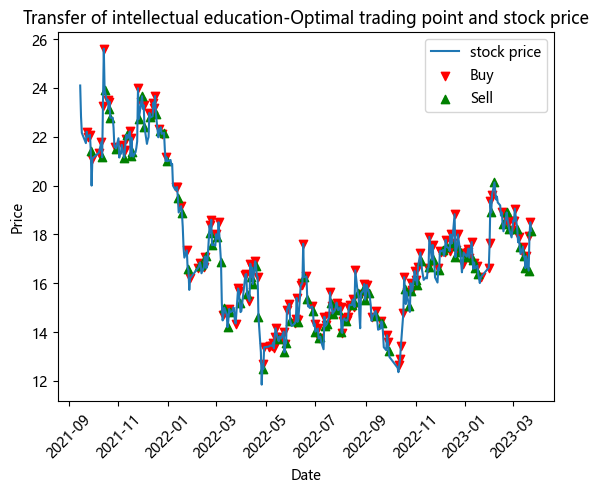

Transfer of intellectual education总收益率为: 1.5449715605050083
Epoch 1/100
4/4 [==============================] - 0s 39ms/step - loss: 1.0668 - val_loss: 0.9186
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 1.0344 - val_loss: 0.8877
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 1.0085 - val_loss: 0.8563
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9871 - val_loss: 0.8363
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9740 - val_loss: 0.8364
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9585 - val_loss: 0.8347
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9454 - val_loss: 0.8209
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9359 - val_loss: 0.8139
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9242 - val_loss: 0.8090
Epoch 10/100
4/4 [==============================] - 0s 14m

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 9ms/step - loss: 1.1466 - val_loss: 0.8915
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 1.1329 - val_loss: 0.8684
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0515 - val_loss: 0.8543
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0220 - val_loss: 0.8436
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9921 - val_loss: 0.8106
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9707 - val_loss: 0.7917
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9427 - val_loss: 0.7641
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9078 - val_loss: 0.7525
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9071 - val_loss: 0.7329
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8391 - val_loss: 0.6892
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 10ms/step - loss: 0.9695 - val_loss: 1.0884
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8963 - val_loss: 1.0575
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8785 - val_loss: 1.0456
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8758 - val_loss: 1.0246
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8487 - val_loss: 1.0198
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8372 - val_loss: 1.0143
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8162 - val_loss: 0.9789
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8045 - val_loss: 0.9702
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7917 - val_loss: 0.9707
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7653 - val_loss: 0.9488
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 1.1112 - val_loss: 0.8014
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 1.0502 - val_loss: 0.7749
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 1.0126 - val_loss: 0.7964
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9873 - val_loss: 0.7946
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9721 - val_loss: 0.7878
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9474 - val_loss: 0.7966
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9209 - val_loss: 0.7808
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8911 - val_loss: 0.7776
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8640 - val_loss: 0.7656
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8419 - val_loss: 0.7228
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 0.9212 - val_loss: 1.0733
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8901 - val_loss: 1.0870
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8727 - val_loss: 1.0762
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8580 - val_loss: 1.0772
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8419 - val_loss: 1.0397
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8100 - val_loss: 0.9771
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7918 - val_loss: 0.9612
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7402 - val_loss: 0.9510
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.6969 - val_loss: 0.8360
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.6447 - val_loss: 0.7524
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 0s 6ms/step - loss: 1.0419 - val_loss: 0.8125
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 1.0088 - val_loss: 0.7934
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9933 - val_loss: 0.7978
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9741 - val_loss: 0.8080
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9643 - val_loss: 0.7729
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9551 - val_loss: 0.7685
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9402 - val_loss: 0.7510
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9093 - val_loss: 0.7365
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8794 - val_loss: 0.7417
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8507 - val_loss: 0.6938
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 1s 7ms/step - loss: 1.0561 - val_loss: 0.8175
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 1.0019 - val_loss: 0.7875
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9815 - val_loss: 0.7968
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9674 - val_loss: 0.7749
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9517 - val_loss: 0.7461
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9317 - val_loss: 0.7578
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9254 - val_loss: 0.7796
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8973 - val_loss: 0.7481
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8816 - val_loss: 0.7028
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8385 - val_loss: 0.6632
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
8/8 [==============================] - 0s 20ms/step - loss: 1.0613 - val_loss: 0.6769
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.9561 - val_loss: 0.7555
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9179 - val_loss: 0.7991
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9004 - val_loss: 0.8220
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.8763 - val_loss: 0.8127
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8670 - val_loss: 0.7775
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.8444 - val_loss: 0.7938
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8361 - val_loss: 0.8109
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.8304 - val_loss: 0.8180
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 0.8138 - val_loss: 0.7685
Epoch 11/100
8/8 [==========

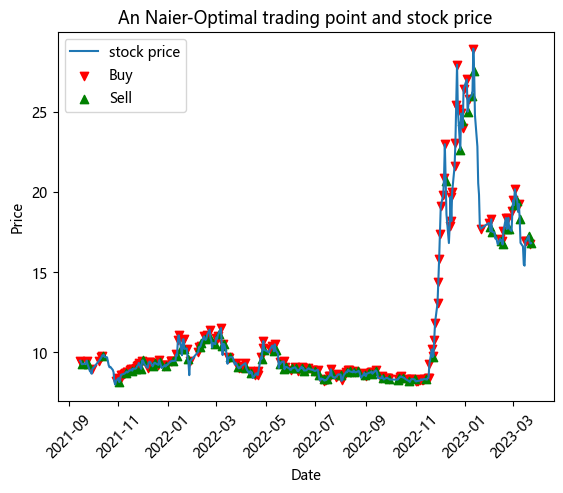

An Naier总收益率为: 0.9008433237345062
Epoch 1/100
4/4 [==============================] - 0s 46ms/step - loss: 1.4649 - val_loss: 1.0321
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 1.1936 - val_loss: 1.1020
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0157 - val_loss: 1.1801
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8929 - val_loss: 1.2406
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8258 - val_loss: 1.2691
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.7556 - val_loss: 1.2715
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6977 - val_loss: 1.2592
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6658 - val_loss: 1.2174
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6262 - val_loss: 1.1825
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6040 - va

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 10ms/step - loss: 1.0832 - val_loss: 0.8543
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0210 - val_loss: 0.8260
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9756 - val_loss: 0.7898
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9522 - val_loss: 0.7735
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9299 - val_loss: 0.7611
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9308 - val_loss: 0.7646
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9028 - val_loss: 0.7254
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8593 - val_loss: 0.7175
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8397 - val_loss: 0.6866
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8149 - val_loss: 0.6491
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 8ms/step - loss: 0.9690 - val_loss: 0.9514
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9181 - val_loss: 0.9873
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8872 - val_loss: 0.9336
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8709 - val_loss: 0.9007
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8656 - val_loss: 0.8985
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8456 - val_loss: 0.8845
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8416 - val_loss: 0.8729
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8196 - val_loss: 0.8814
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 0.7990 - val_loss: 0.8112
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 0.7860 - val_loss: 0.8259
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 7ms/step - loss: 0.9812 - val_loss: 0.8286
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9306 - val_loss: 0.8288
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9159 - val_loss: 0.8234
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9037 - val_loss: 0.8074
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8972 - val_loss: 0.8079
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8838 - val_loss: 0.7869
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8889 - val_loss: 0.8139
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8783 - val_loss: 0.7709
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8472 - val_loss: 0.7432
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8224 - val_loss: 0.7301
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 6ms/step - loss: 0.9590 - val_loss: 0.9710
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8951 - val_loss: 0.9904
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8851 - val_loss: 0.9708
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8797 - val_loss: 0.9706
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8742 - val_loss: 0.9820
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8671 - val_loss: 0.9602
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8697 - val_loss: 0.9449
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8514 - val_loss: 0.9659
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8506 - val_loss: 0.9458
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8555 - val_loss: 0.9354
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
30/30 [==============================] - 0s 5ms/step - loss: 0.9508 - val_loss: 0.9492
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8990 - val_loss: 0.9135
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8824 - val_loss: 0.9064
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8781 - val_loss: 0.9159
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8651 - val_loss: 0.9095
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8759 - val_loss: 0.9012
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8635 - val_loss: 0.8907
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8446 - val_loss: 0.9178
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8410 - val_loss: 0.9127
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8501 - val_loss: 0.9062
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 0s 5ms/step - loss: 1.1035 - val_loss: 0.8853
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0466 - val_loss: 0.9088
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0117 - val_loss: 0.8636
Epoch 4/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9965 - val_loss: 0.8472
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9886 - val_loss: 0.8666
Epoch 6/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9835 - val_loss: 0.8387
Epoch 7/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9787 - val_loss: 0.8439
Epoch 8/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9643 - val_loss: 0.8212
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9699 - val_loss: 0.8550
Epoch 10/100
33/33 [==============================] - 0s 2ms/step - loss: 0.9498 - val_loss: 0.8012
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
4/4 [==============================] - 0s 39ms/step - loss: 1.3467 - val_loss: 1.3301
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 1.1469 - val_loss: 1.2780
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.9880 - val_loss: 1.2348
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.8856 - val_loss: 1.2175
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7942 - val_loss: 1.2153
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7221 - val_loss: 1.2041
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6890 - val_loss: 1.2183
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6498 - val_loss: 1.1978
Epoch 9/100
4/4 [==============================] - 0s 12ms/step - loss: 0.6100 - val_loss: 1.1720
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.5895 - val_loss: 1.1652
Epoch 11/100
4/4 [=

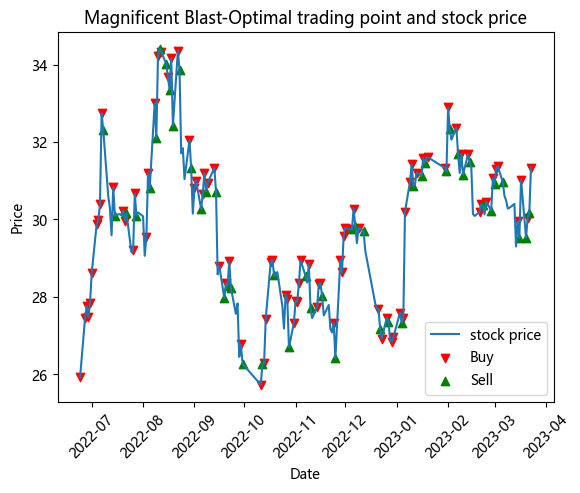

Magnificent Blast总收益率为: 0.8058717130137953
Epoch 1/100
4/4 [==============================] - 0s 36ms/step - loss: 1.1746 - val_loss: 1.0481
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 1.0631 - val_loss: 0.9712
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 1.0142 - val_loss: 0.9384
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.9899 - val_loss: 0.9235
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 0.9651 - val_loss: 0.9178
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.9524 - val_loss: 0.9140
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9393 - val_loss: 0.9102
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 0.9265 - val_loss: 0.9083
Epoch 9/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9150 - val_loss: 0.9123
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 15ms/step - loss: 0.7987 - val_loss: 0.6193
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7423 - val_loss: 0.6143
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7218 - val_loss: 0.6043
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7028 - val_loss: 0.5828
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6888 - val_loss: 0.5799
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6793 - val_loss: 0.5740
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6647 - val_loss: 0.5646
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6588 - val_loss: 0.5499
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6422 - val_loss: 0.5477
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6291 - val_loss: 0.5417
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 0.7152 - val_loss: 0.5569
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6780 - val_loss: 0.5553
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6635 - val_loss: 0.5435
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6387 - val_loss: 0.5334
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6273 - val_loss: 0.5153
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6085 - val_loss: 0.5138
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5875 - val_loss: 0.4912
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5680 - val_loss: 0.4716
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5355 - val_loss: 0.4575
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5162 - val_loss: 0.4516
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 0.7288 - val_loss: 0.5707
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7045 - val_loss: 0.5625
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6829 - val_loss: 0.5665
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6758 - val_loss: 0.5447
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6524 - val_loss: 0.5432
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6459 - val_loss: 0.5415
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6247 - val_loss: 0.5515
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6101 - val_loss: 0.5179
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6009 - val_loss: 0.4934
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5779 - val_loss: 0.4812
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 12ms/step - loss: 0.7620 - val_loss: 0.6095
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7328 - val_loss: 0.6062
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7058 - val_loss: 0.5771
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6891 - val_loss: 0.5835
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6768 - val_loss: 0.5662
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6656 - val_loss: 0.5572
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6515 - val_loss: 0.5390
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6454 - val_loss: 0.5324
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6376 - val_loss: 0.5359
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6149 - val_loss: 0.5171
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 1s 16ms/step - loss: 0.7383 - val_loss: 0.5879
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6976 - val_loss: 0.5824
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6933 - val_loss: 0.5801
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6666 - val_loss: 0.5590
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6782 - val_loss: 0.5553
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6527 - val_loss: 0.5536
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6432 - val_loss: 0.5298
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6137 - val_loss: 0.5260
Epoch 9/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6110 - val_loss: 0.5059
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5967 - val_loss: 0.5089
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 0.7996 - val_loss: 0.6233
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7223 - val_loss: 0.5685
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6920 - val_loss: 0.5743
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6825 - val_loss: 0.5547
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6703 - val_loss: 0.5522
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6577 - val_loss: 0.5460
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6438 - val_loss: 0.5506
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6357 - val_loss: 0.5388
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6242 - val_loss: 0.5283
Epoch 10/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6139 - val_loss: 0.5181
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
8/8 [==============================] - 0s 17ms/step - loss: 1.1454 - val_loss: 0.6734
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 1.1106 - val_loss: 0.6733
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 1.1033 - val_loss: 0.6761
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0980 - val_loss: 0.6697
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0880 - val_loss: 0.6572
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0811 - val_loss: 0.6542
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0694 - val_loss: 0.6587
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0662 - val_loss: 0.6588
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0535 - val_loss: 0.6461
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0439 - val_loss: 0.6481
Epoch 11/100
8/8 [==========

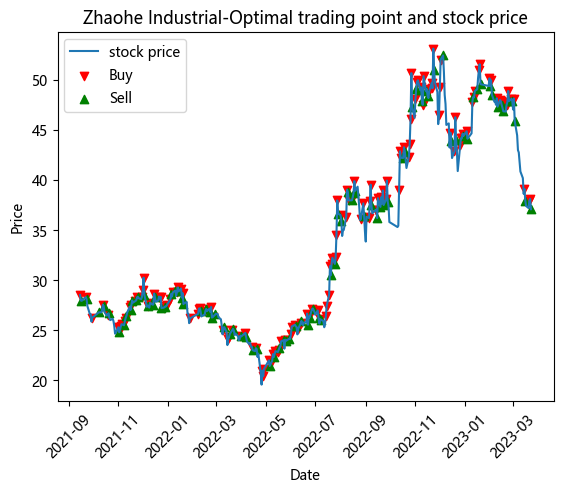

Zhaohe Industrial总收益率为: 1.7462973131171704
Epoch 1/100
4/4 [==============================] - 0s 37ms/step - loss: 0.9141 - val_loss: 0.9226
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8085 - val_loss: 0.8616
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7658 - val_loss: 0.8406
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7414 - val_loss: 0.8363
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7118 - val_loss: 0.8219
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6833 - val_loss: 0.8127
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6666 - val_loss: 0.8058
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6393 - val_loss: 0.8002
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6136 - val_loss: 0.7977
Epoch 10/100
4/4 [==============================] - 0s 11ms/step - loss: 0.

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 9ms/step - loss: 0.9227 - val_loss: 1.1220
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8827 - val_loss: 1.0826
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8669 - val_loss: 1.0679
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8536 - val_loss: 1.0592
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8419 - val_loss: 1.0640
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8317 - val_loss: 1.0502
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8323 - val_loss: 1.0339
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8028 - val_loss: 0.9931
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7950 - val_loss: 0.9740
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7746 - val_loss: 0.9620
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 8ms/step - loss: 0.9543 - val_loss: 1.1265
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9181 - val_loss: 1.1208
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8967 - val_loss: 1.1323
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8855 - val_loss: 1.1164
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8774 - val_loss: 1.1112
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8552 - val_loss: 1.0824
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8464 - val_loss: 1.0747
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8289 - val_loss: 1.0474
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8208 - val_loss: 1.0540
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8031 - val_loss: 1.0172
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 7ms/step - loss: 1.0692 - val_loss: 0.8553
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9895 - val_loss: 0.8288
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9779 - val_loss: 0.8353
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9690 - val_loss: 0.8268
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9446 - val_loss: 0.7955
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9198 - val_loss: 0.8071
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9026 - val_loss: 0.7467
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8714 - val_loss: 0.7378
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8509 - val_loss: 0.7123
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8152 - val_loss: 0.6882
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 6ms/step - loss: 0.9694 - val_loss: 0.8357
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9502 - val_loss: 0.8163
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9415 - val_loss: 0.8142
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9242 - val_loss: 0.7841
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9023 - val_loss: 0.7836
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8905 - val_loss: 0.7733
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8715 - val_loss: 0.7485
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8447 - val_loss: 0.7313
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8300 - val_loss: 0.7229
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8105 - val_loss: 0.6849
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 0s 6ms/step - loss: 0.9403 - val_loss: 1.0702
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 0.8989 - val_loss: 1.0333
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 0.8933 - val_loss: 1.0597
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8834 - val_loss: 1.0365
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8729 - val_loss: 1.0116
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8824 - val_loss: 0.9694
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8674 - val_loss: 0.9888
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8431 - val_loss: 0.9863
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8342 - val_loss: 0.9564
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8303 - val_loss: 0.8859
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
32/32 [==============================] - 0s 5ms/step - loss: 0.9667 - val_loss: 1.1803
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.9345 - val_loss: 1.1408
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9264 - val_loss: 1.1552
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.9246 - val_loss: 1.1608
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.9131 - val_loss: 1.1627
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9003 - val_loss: 1.1373
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8897 - val_loss: 1.0821
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8803 - val_loss: 1.1050
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8623 - val_loss: 1.0656
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8640 - val_loss: 1.0698
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
8/8 [==============================] - 0s 17ms/step - loss: 1.2323 - val_loss: 0.4721
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 1.0883 - val_loss: 0.5349
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0573 - val_loss: 0.5204
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0103 - val_loss: 0.4935
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9649 - val_loss: 0.4477
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9239 - val_loss: 0.4147
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.8730 - val_loss: 0.4061
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.8306 - val_loss: 0.3744
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7775 - val_loss: 0.3489
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7257 - val_loss: 0.3318
Epoch 11/100
8/8 [==========

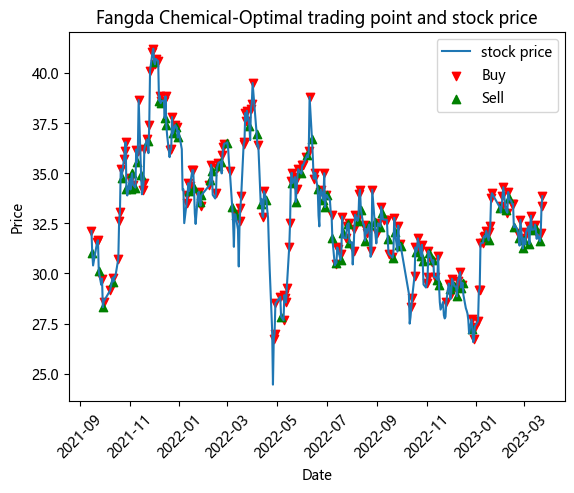

Fangda Chemical总收益率为: 1.1110893776354305
Epoch 1/100
4/4 [==============================] - 0s 38ms/step - loss: 0.9373 - val_loss: 1.7028
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8498 - val_loss: 1.8060
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7803 - val_loss: 1.9317
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7346 - val_loss: 2.0470
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7189 - val_loss: 2.1502
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.6991 - val_loss: 2.1873
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.6817 - val_loss: 2.1684
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6655 - val_loss: 2.1417
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6532 - val_loss: 2.0449
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.64

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 1.0672 - val_loss: 0.7888
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 1.0052 - val_loss: 0.7574
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9672 - val_loss: 0.7435
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9370 - val_loss: 0.7151
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9110 - val_loss: 0.7066
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.8907 - val_loss: 0.6780
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8552 - val_loss: 0.6868
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8219 - val_loss: 0.6312
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7889 - val_loss: 0.6191
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7428 - val_loss: 0.5676
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 1.0447 - val_loss: 0.9450
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 0.9774 - val_loss: 0.9187
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 0.9384 - val_loss: 0.8840
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9137 - val_loss: 0.8459
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8839 - val_loss: 0.8562
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8610 - val_loss: 0.7997
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8694 - val_loss: 0.7922
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8136 - val_loss: 0.7532
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7805 - val_loss: 0.7316
Epoch 10/100
19/19 [==============================] - 0s 5ms/step - loss: 0.7591 - val_loss: 0.6667
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 7ms/step - loss: 1.0912 - val_loss: 0.8222
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 1.0478 - val_loss: 0.8064
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 1.0095 - val_loss: 0.7956
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9874 - val_loss: 0.7670
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9591 - val_loss: 0.7467
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9255 - val_loss: 0.7112
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.9019 - val_loss: 0.7502
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8561 - val_loss: 0.6513
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8155 - val_loss: 0.6207
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7394 - val_loss: 0.5565
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 0.9420 - val_loss: 1.0690
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8857 - val_loss: 1.0258
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8659 - val_loss: 1.0268
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 0.8505 - val_loss: 0.9814
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8296 - val_loss: 0.9463
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8002 - val_loss: 0.9233
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7816 - val_loss: 0.8845
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7494 - val_loss: 0.9061
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.7104 - val_loss: 0.7947
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.6542 - val_loss: 0.7315
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 0s 6ms/step - loss: 1.0818 - val_loss: 0.9976
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 1.0359 - val_loss: 0.9591
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 1.0107 - val_loss: 0.9467
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9883 - val_loss: 0.9242
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9730 - val_loss: 0.8928
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9370 - val_loss: 0.8874
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8830 - val_loss: 0.8288
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8397 - val_loss: 0.7669
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7842 - val_loss: 0.7214
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7207 - val_loss: 0.7562
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
33/33 [==============================] - 1s 6ms/step - loss: 1.0782 - val_loss: 0.8448
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0350 - val_loss: 0.8634
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0241 - val_loss: 0.8498
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0192 - val_loss: 0.8385
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 1.0092 - val_loss: 0.8467
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9863 - val_loss: 0.8180
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9923 - val_loss: 0.8255
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9681 - val_loss: 0.7876
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9392 - val_loss: 0.7817
Epoch 10/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9297 - val_loss: 0.8155
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
8/8 [==============================] - 0s 21ms/step - loss: 1.0135 - val_loss: 0.9058
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.9545 - val_loss: 0.9553
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.9329 - val_loss: 0.9396
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8995 - val_loss: 0.8948
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8664 - val_loss: 0.8469
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8362 - val_loss: 0.8180
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8133 - val_loss: 0.7997
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7764 - val_loss: 0.7994
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 0.7307 - val_loss: 0.7309
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6939 - val_loss: 0.6970
Epoch 11/100
8/8 [==========

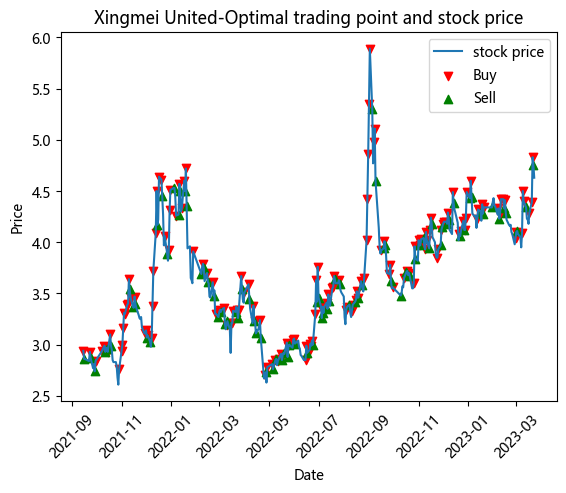

Xingmei United总收益率为: 1.559584426833086
Epoch 1/100
4/4 [==============================] - 0s 47ms/step - loss: 1.2440 - val_loss: 0.9168
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 1.1291 - val_loss: 0.8745
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0788 - val_loss: 0.8436
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0500 - val_loss: 0.8211
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0051 - val_loss: 0.8077
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.9765 - val_loss: 0.7961
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9516 - val_loss: 0.7886
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9251 - val_loss: 0.7815
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9010 - val_loss: 0.7793
Epoch 10/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8771

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 1.0131 - val_loss: 1.1294
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9372 - val_loss: 1.0934
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9077 - val_loss: 1.0789
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8888 - val_loss: 1.0550
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8659 - val_loss: 1.0132
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8435 - val_loss: 1.0048
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8119 - val_loss: 0.9588
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 0.7972 - val_loss: 0.9499
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7915 - val_loss: 0.8928
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7316 - val_loss: 0.8696
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 0.9356 - val_loss: 1.0106
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8267 - val_loss: 0.9432
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8485 - val_loss: 0.9137
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8064 - val_loss: 0.9169
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7756 - val_loss: 0.9011
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7426 - val_loss: 0.8615
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.7087 - val_loss: 0.8360
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6867 - val_loss: 0.8360
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6296 - val_loss: 0.7686
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.6015 - val_loss: 0.7088
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 0.9405 - val_loss: 1.0830
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8834 - val_loss: 1.0700
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8633 - val_loss: 1.0634
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8441 - val_loss: 1.0178
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8116 - val_loss: 1.0055
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7807 - val_loss: 0.9543
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7334 - val_loss: 0.8950
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.8545
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6661 - val_loss: 0.7970
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6001 - val_loss: 0.6995
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
24/24 [==============================] - 0s 7ms/step - loss: 0.9991 - val_loss: 1.0090
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.9076 - val_loss: 0.9675
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.8588 - val_loss: 0.9284
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.8211 - val_loss: 0.8927
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.7557 - val_loss: 0.8397
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.7150 - val_loss: 0.7405
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6230 - val_loss: 0.6083
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5311 - val_loss: 0.5033
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.4337 - val_loss: 0.4234
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.3854 - val_loss: 0.3783
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
28/28 [==============================] - 1s 6ms/step - loss: 1.0088 - val_loss: 0.8762
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 0.9598 - val_loss: 0.8719
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 0.9411 - val_loss: 0.8647
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 0.9195 - val_loss: 0.8505
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8990 - val_loss: 0.8594
Epoch 6/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8640 - val_loss: 0.7837
Epoch 7/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8367 - val_loss: 0.7907
Epoch 8/100
28/28 [==============================] - 0s 3ms/step - loss: 0.7989 - val_loss: 0.7522
Epoch 9/100
28/28 [==============================] - 0s 3ms/step - loss: 0.7306 - val_loss: 0.6647
Epoch 10/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6880 - val_loss: 0.6041
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9721 - val_loss: 1.0934
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9501 - val_loss: 1.0732
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9384 - val_loss: 1.0574
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9241 - val_loss: 1.0585
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9082 - val_loss: 1.0327
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8919 - val_loss: 0.9960
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8716 - val_loss: 0.9837
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8249 - val_loss: 0.8986
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7734 - val_loss: 0.8863
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7430 - val_loss: 0.8004
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
8/8 [==============================] - 0s 24ms/step - loss: 1.0764 - val_loss: 1.2440
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9850 - val_loss: 1.0911
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.9616 - val_loss: 1.0321
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.9353 - val_loss: 0.9662
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.9170 - val_loss: 0.9299
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 0.9000 - val_loss: 0.9186
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8832 - val_loss: 0.9096
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8793 - val_loss: 0.9121
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8565 - val_loss: 0.8686
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8395 - val_loss: 0.8335
Epoch 11/100
8/8 [==========

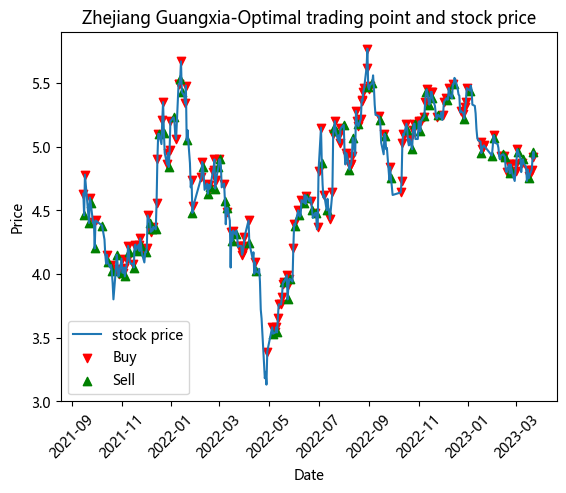

Zhejiang Guangxia总收益率为: 1.3543432100656543
Epoch 1/100
4/4 [==============================] - 0s 45ms/step - loss: 1.3206 - val_loss: 1.1339
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 1.1254 - val_loss: 0.9584
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0344 - val_loss: 0.8801
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0136 - val_loss: 0.8408
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0019 - val_loss: 0.8312
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9870 - val_loss: 0.8183
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.9675 - val_loss: 0.7990
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9491 - val_loss: 0.8020
Epoch 9/100
4/4 [==============================] - 0s 15ms/step - loss: 0.9408 - val_loss: 0.8076
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
15/15 [==============================] - 0s 11ms/step - loss: 0.9872 - val_loss: 0.6691
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.9258 - val_loss: 0.6900
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8828 - val_loss: 0.6608
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8660 - val_loss: 0.6580
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8399 - val_loss: 0.6495
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8219 - val_loss: 0.6380
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7998 - val_loss: 0.6246
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7771 - val_loss: 0.6072
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7459 - val_loss: 0.6211
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7376 - val_loss: 0.5569
Epoch 11

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 1.1443 - val_loss: 0.8292
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 1.0175 - val_loss: 0.8173
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9820 - val_loss: 0.8119
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9626 - val_loss: 0.8073
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9452 - val_loss: 0.7999
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9521 - val_loss: 0.7932
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9105 - val_loss: 0.7848
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8876 - val_loss: 0.7664
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8671 - val_loss: 0.7551
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8614 - val_loss: 0.7391
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
22/22 [==============================] - 0s 8ms/step - loss: 0.9746 - val_loss: 0.9669
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9032 - val_loss: 0.9571
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8824 - val_loss: 0.9170
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8514 - val_loss: 0.8668
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8247 - val_loss: 0.8357
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.8147 - val_loss: 0.8330
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8063 - val_loss: 0.8066
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7518 - val_loss: 0.7428
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7199 - val_loss: 0.7220
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7018 - val_loss: 0.6617
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 1.0257 - val_loss: 1.0469
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.9313 - val_loss: 1.0118
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8997 - val_loss: 0.9902
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 0.8887 - val_loss: 0.9824
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8627 - val_loss: 0.9649
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.8352 - val_loss: 0.9430
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 0.7983 - val_loss: 0.9153
Epoch 8/100
26/26 [==============================] - 0s 4ms/step - loss: 0.7852 - val_loss: 0.8717
Epoch 9/100
26/26 [==============================] - 0s 4ms/step - loss: 0.7424 - val_loss: 0.8489
Epoch 10/100
26/26 [==============================] - 0s 4ms/step - loss: 0.6785 - val_loss: 0.7882
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
29/29 [==============================] - 0s 7ms/step - loss: 1.0245 - val_loss: 1.1100
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9589 - val_loss: 1.0752
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9395 - val_loss: 1.0518
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9242 - val_loss: 1.0673
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9164 - val_loss: 1.0371
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8958 - val_loss: 1.0147
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8805 - val_loss: 1.0066
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8644 - val_loss: 0.9906
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8499 - val_loss: 0.9655
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8565 - val_loss: 0.9193
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8872 - val_loss: 0.9071
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8618 - val_loss: 0.8975
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8507 - val_loss: 0.9035
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8587 - val_loss: 0.8910
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8325 - val_loss: 0.8925
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8265 - val_loss: 0.8688
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8068 - val_loss: 0.8525
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8018 - val_loss: 0.8381
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7959 - val_loss: 0.8273
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7661 - val_loss: 0.8225
Epoch 11/

<ipython-input-5-e8582df063d9>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['今日开盘']=dataV2['今日开盘']
<ipython-input-5-e8582df063d9>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['收益率'] = profits
<ipython-input-5-e8582df063d9>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Epoch 1/100
8/8 [==============================] - 0s 24ms/step - loss: 1.0524 - val_loss: 0.7063
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.9659 - val_loss: 0.6784
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.9302 - val_loss: 0.6971
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.9076 - val_loss: 0.6779
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.8901 - val_loss: 0.6865
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.8731 - val_loss: 0.6548
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 0.8573 - val_loss: 0.6767
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 0.8486 - val_loss: 0.6809
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 0.8281 - val_loss: 0.6630
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 0.8127 - val_loss: 0.6363
Epoch 11/100
8/8 [==========

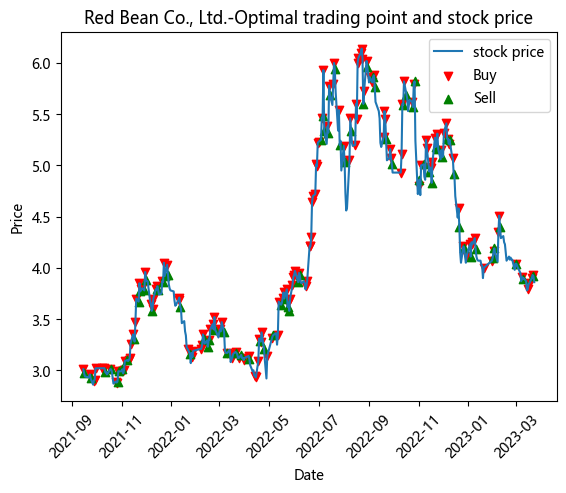

Red Bean Co., Ltd.总收益率为: 1.811993603749626


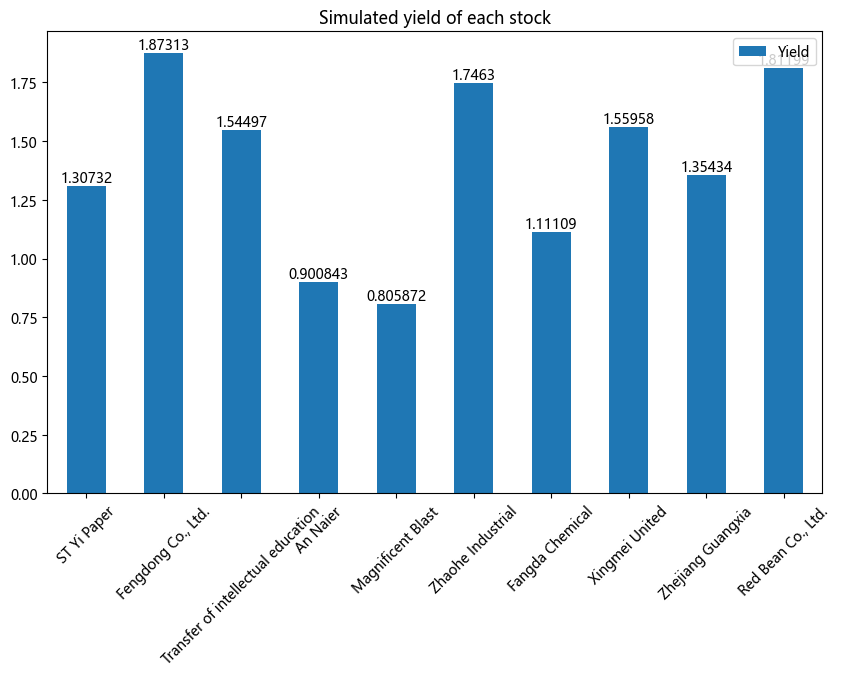

Simulated average yield of each stock:1.401544480190931


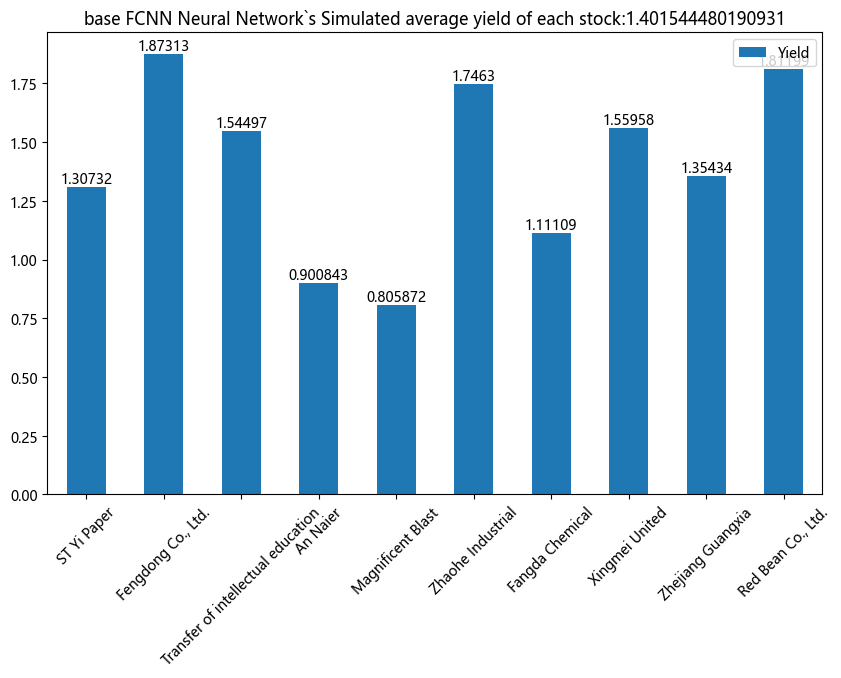

In [5]:
import openpyxl
from sklearn import svm
import xlrd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from translate import Translator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.optimize import minimize
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection
from sklearn.metrics import r2_score
import time

if not os.path.exists('Output'):
    os.makedirs('Output')
if not os.path.exists('min'):
    os.makedirs('min')
def train(model, x_train, y_train):
    model.fit(x_train, y_train.ravel())
def print_accuracy(model, x_train, y_train, x_test, y_test):
    print('SVM-输出训练集的准确率为:', model.score(x_train, y_train))
    print("SVM-输出测试集的准确率为:", model.score(x_test, y_test))
    # 原始结果与预测结果进行对比
    show_accuracy(model.predict(x_train), y_train, 'traing data')
    show_accuracy(model.predict(x_test), y_test, 'testing data')
    # 计算决策函数的值
    print('decision_function:\n', model.decision_function(x_train))

def show_accuracy(a, b, tip):
    acc = (a.ravel() == b.ravel())
    print("%s Accuracy:%.3f" % (tip, np.mean(acc)))

buy_threshold =0.08
sell_threshold =0.05

#'交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元'
# 设置相对路径
data_path = "./data"              ###股票十年历史数据所在文件夹
max_longs = 2000                    ####总日期长度
SF='FCNN神经网络'
translator = Translator(from_lang='zh', to_lang='en')
SF = translator.translate(SF)
# 创建空DataFrame来存储所有表格的数据
all_data = pd.DataFrame()
row_index2 = ['total time(s)', 'total revenue(%)', 'train_accuracy', 'test_accuracy']
# 创建一个空的DataFrame
table2_data = pd.DataFrame(index=row_index2)
row_index = ['Longs=183','Longs=366','Longs=549','Longs=732','Longs=915','Longs=1098','Longs=1281','Longs=1464','Longs=1647']
# 创建一个空的DataFrame
table1_data = pd.DataFrame(index=row_index)
########################如果文件是一个，分成不同的工作表，以下代码是先将工作表分开##########
# 打开Excel文件
workbook = xlrd.open_workbook("data\\股票十年历史数据.xls")

# 遍历每个工作表
for sheet_name in workbook.sheet_names():
    # 选择工作表
    sheet = workbook.sheet_by_name(sheet_name)
    # 创建一个新的Excel文件
    new_workbook = openpyxl.Workbook()

    # 选择新的工作表，并将数据复制到该工作表中
    new_sheet = new_workbook.active
    new_sheet.title = sheet_name
    for row in range(sheet.nrows):
        for col in range(sheet.ncols):
            # 检查是否为“交易日期”列
            if sheet.cell_value(0, col) == "交易日期":
                # 如果是，则将单元格格式设置为日期时间格式
                cell = new_sheet.cell(row=row+1, column=col+1)
                cell.value = sheet.cell_value(row, col)
                cell.number_format = "yyyy/m/d h:mm:ss"
            else:
                # 如果不是，则直接复制单元格的值
                new_sheet.cell(row=row+1, column=col+1).value = sheet.cell_value(row, col)
    # 获取“证券简称”列第一个数据
    security_name = sheet.cell_value(1, 1)

    # 去除文件名中的非法字符
    for char in ["\\", "/", ":", "*", "?", "\"", "<", ">", "|"]:
        security_name = security_name.replace(char, "")

    # 将工作表保存到新的Excel文件中，并将文件命名为“证券简称”列第一个数据
    new_workbook.save(os.path.join("data", f"{security_name}.xls"))

    # # 将工作表保存到新的Excel文件中
    # new_workbook.save(os.path.join("data", f"{sheet_name}.xls"))
##########################################################################################   



# 遍历"data"文件夹中的所有文件
for filename in os.listdir(data_path):
    if filename == "股票十年历史数据.xls":
       # 如果文件名是"股票十年历史数据.xls"，则跳过该文件
        continue
    if filename.endswith(".xls"):
        filepath = os.path.join(data_path, filename)
        # 读取表格数据
        df = pd.read_excel(filepath)#####################################
        
        nameT = os.path.splitext(os.path.basename(filename))[0].split(' ')[0]
        nameT = translator.translate(nameT)
        start_time = time.time()
        time_list = []
        remark_list = []
        table2=[]
        def ff(longg):
            Longs=longg
            name=filepath
            TEXTname=name
            # 读取 XLS 文件
            df = pd.read_excel(name)
            dddate=df##后面画图还要用到日期，这里先保留在ddate里
            df = df.iloc[-Longs:]
            # 选择需要的列并创建新的DataFrame
            data = df[['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']]
            dataL = data.set_index('交易日期')
            dataV= data
            # 重新命名列
            data.columns = ['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']
            df=data
            # 数据清洗
            df = df.drop_duplicates()  # 去重
            # 缺失值处理
            df = df.fillna(method='ffill')  # 用前一行的值填充缺失值
            # 异常值处理
            df = df[df['成交数量@单位：股'] > 0]  # 去除成交数量为负的数据
            # 特征工程
            df['涨跌幅'] = (df['最近成交'] - df['昨日收盘']) / df['昨日收盘']  # 计算涨跌幅

            # 删除无用的特征
            df = df.drop(columns=['交易日期', '最近成交', '成交金额(人民币)@单位：元'])  
            # 数据标准化z = (x - u) / s：均值归零，方差化1
            scaler = StandardScaler()
            df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

            # 将数据分为特征和标签；自变量因变量
            X = df_scaled.drop(columns=['涨跌幅'])
            y = df_scaled[['涨跌幅']]

            # 将数据分为训练集和测试集
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # 构建CNN模型
            model = keras.Sequential([
                layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
                layers.Dense(64, activation='relu'),
                layers.Dense(1)
            ])
            model.compile(loss='mean_squared_error', optimizer='adam')

            # 训练模型
            model.fit(X_train, y_train, epochs=100, validation_split=0.2)

            X1=X.iloc[:366,:]
            y_pred = model.predict(X1)
            yy = pd.DataFrame(y_pred, columns=[ '涨跌幅'])

            # RR=r2_score(y, y_pred)##R平方值
            # print(f'R平方值={RR}')
            # history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


            y_pred=yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
            df_scaled['策略'] = yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
            dataV2= dataV.iloc[-366:, :]
            df_selected= df_scaled.iloc[:366, :]

            df_selected.index=df_selected.index+len(dddate)-Longs
            df_selected['今日开盘']=dataV2['今日开盘']

            # 初始化买入价格和买入索引
            buy_price = None
            buy_index = None

            # 初始化收益率和策略列表
            profits = []
            strategies = []

            # 遍历选定的时间段内的每一天
            # 根据预测结果判断交易策略
            # 遍历选定的时间段内的每一天
            for i, row in df_selected.iterrows():
                if y_pred[i-len(dddate)+Longs] == 1:
                    # 买入策略
                    buy_price = row['今日开盘']
                    buy_index = i
                    buy_cishu=1
                    profits.append(0)
                    strategies.append('买进')
                else:
                    # 卖出策略
                    if buy_price is not None:
                            profit = (row['今日开盘']*buy_cishu - buy_price) / (buy_price)
                            profits.append(profit)
                            strategies.append('卖出')
                            buy_price=None
                            buy_cishu=0
                    else:
                            # 如果当前没有持仓，就继续观望
                            profits.append(0)
                            strategies.append('持有')



            # 将收益率和策略列表添加到数据框中
            df_selected['收益率'] = profits
            df_selected['策略'] = strategies
            sum_B1 = df_selected['收益率'].sum()

            sum_B_list.append(float(sum_B1))
            return sum_B1

        sum_B_list = []
        # 定义参数的可能取值范围###############################
        min_longs = 1
        max_longs = 1800
        Longs_range = [i for i in range(min_longs, max_longs+1) if i % 183 == 0]

        # 初始化最大输出和对应的参数值
        max_mean = -np.inf
        best_Longs = None

        # 遍历所有可能的参数值
        for Longs in Longs_range:
            # 计算当前参数值对应的输出
            output = ff(Longs)
            
            # 如果当前输出比最大输出更大，则更新最大输出和对应的参数值
            if output > max_mean:
                max_mean = output
                best_Longs = Longs
        ########################################################

        Longs=best_Longs
        name=filepath
        TEXTname=name
        # 读取 XLS 文件
        df = pd.read_excel(name)
        dddate=df##后面画图还要用到日期，这里先保留在ddate里
        df = df.iloc[-Longs:]
        # 选择需要的列并创建新的DataFrame
        data = df[['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']]
        dataL = data.set_index('交易日期')
        dataV= data
        # 重新命名列
        data.columns = ['交易日期','昨日收盘', '今日开盘', '成交数量@单位：股', '最高成交', '最低成交', '最近成交', '成交金额(原币)', '成交金额(人民币)@单位：元']
        df=data
        # 数据清洗
        df = df.drop_duplicates()  # 去重
        # 缺失值处理
        df = df.fillna(method='ffill')  # 用前一行的值填充缺失值
        # 异常值处理
        df = df[df['成交数量@单位：股'] > 0]  # 去除成交数量为负的数据
        # 特征工程
        df['涨跌幅'] = (df['最近成交'] - df['昨日收盘']) / df['昨日收盘']  # 计算涨跌幅

        # 删除无用的特征
        df = df.drop(columns=['交易日期', '最近成交', '成交金额(人民币)@单位：元'])  
        # 数据标准化z = (x - u) / s：均值归零，方差化1
        scaler = StandardScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

        # 将数据分为特征和标签；自变量因变量
        X = df_scaled.drop(columns=['涨跌幅'])
        y = df_scaled[['涨跌幅']]

        # 将数据分为训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 构建CNN模型
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(loss='mean_squared_error', optimizer='adam')

        # 训练模型
        model.fit(X_train, y_train, epochs=100, validation_split=0.2)
        # 在训练集和测试集上预测结果###########训练完成
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # 将预测结果映射为二分类结果（涨或跌）
        y_train_pred_binary = np.where(y_train_pred > 0, 1, 0)
        y_test_pred_binary = np.where(y_test_pred > 0, 1, 0)
        y_train_binary = np.where(y_train > 0, 1, 0)
        y_test_binary = np.where(y_test > 0, 1, 0)
        # 计算并输出准确率
        train_acc = accuracy_score(y_train_binary, y_train_pred_binary)
        test_acc = accuracy_score(y_test_binary, y_test_pred_binary)
        print("Train accuracy:", train_acc)
        print("Test accuracy:", test_acc)


        X1=X.iloc[:366,:]
        y_pred = model.predict(X1)
        yy = pd.DataFrame(y_pred, columns=[ '涨跌幅'])

        # RR=r2_score(y, y_pred)##R平方值
        # print(f'R平方值={RR}')
        # history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


        y_pred=yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
        df_scaled['策略'] = yy[ '涨跌幅'].apply(lambda x: 1 if x > 0 else 0)
        dataV2= dataV.iloc[-366:, :]
        df_selected= df_scaled.iloc[:366, :]

        df_selected.index=df_selected.index+len(dddate)-Longs
        df_selected['今日开盘']=dataV2['今日开盘']

        # 初始化买入价格和买入索引
        buy_price = None
        buy_index = None

        # 初始化收益率和策略列表
        profits = []
        strategies = []

        # 遍历选定的时间段内的每一天
        # 根据预测结果判断交易策略
        # 遍历选定的时间段内的每一天
        for i, row in df_selected.iterrows():
            if y_pred[i-len(dddate)+Longs] == 1:
                # 买入策略
                buy_price = row['今日开盘']
                buy_index = i
                buy_cishu=1
                profits.append(0)
                strategies.append('买进')
            else:
                # 卖出策略
                if buy_price is not None:
                        profit = (row['今日开盘']*buy_cishu - buy_price) / (buy_price)
                        profits.append(profit)
                        strategies.append('卖出')
                        buy_price=None
                        buy_cishu=0
                else:
                        # 如果当前没有持仓，就继续观望
                        profits.append(0)
                        strategies.append('持有')



        # 将收益率和策略列表添加到数据框中
        df_selected['收益率'] = profits
        df_selected['策略'] = strategies
        sum_B = df_selected['收益率'].sum()
        print(sum_B)

        ddate=df_selected

        ddate['交易日期']=dddate['交易日期']
        ddate['最近成交']=dddate['最近成交']
        # ddate['策略'] = ddate['策略'].replace({'卖出': '买入', '买入': '卖出'})###买进卖出互换

        avg_ddate = ddate.groupby('交易日期')['最近成交'].mean()
        # 选择买入和卖出点的数据
        buy_points = ddate.loc[ddate['策略'] == '买进']
        sell_points = ddate.loc[ddate['策略'] == '卖出']
        # 绘制折线图和散点图
        plt.plot(avg_ddate.index, avg_ddate.values, label='stock price')
        plt.scatter(buy_points['交易日期'], buy_points['最近成交'], marker='v', color='red', label='Buy')
        plt.scatter(sell_points['交易日期'], sell_points['最近成交'], marker='^', color='green', label='Sell')
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{nameT}-Optimal trading point and stock price')
        # 显示折线图和散点图
        plt.savefig(f'Output/{nameT}-最优交易点与股票价格.png', bbox_inches='tight')
        plt.legend()
        plt.show()
        dd = ddate[['交易日期','策略']]
        dd.to_csv(f'Output/{nameT}-决策方案.csv',index=False)
        # 打印列B的总和
        print(f"{nameT}总收益率为:", sum_B)



        end_time = time.time()
        elapsed_time = end_time - start_time


        # 将table作为一列添加到DataFrame中
        table1_data[f'{nameT}'] = sum_B_list




        table2.append(elapsed_time)
        table2.append(sum_B)
        table2.append(train_acc)
        table2.append(test_acc)



        # 将table作为一列添加到DataFrame中
        table2_data[f'{nameT}'] = table2

        all_data.loc[nameT, "Yield"] = sum_B

# 可视化
all_data.to_csv('Output/各个股票的模拟收益率.csv')
all_data = pd.DataFrame(all_data)

# 绘制柱形图
ax = all_data.plot(kind='bar', figsize=(10, 6), rot=0)

# 添加详细纵坐标
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.xticks(rotation=45)
plt.title('Simulated yield of each stock')
plt.savefig(f'Output/{filename}-各个股票的模拟收益率.png', bbox_inches='tight')
plt.legend()
plt.show()
mean = all_data.mean().mean()
print(f'Simulated average yield of each stock:{mean}')
all_data.to_csv('Output/各个股票的模拟收益率.csv')
all_data = pd.DataFrame(all_data)

# 绘制柱形图
ax = all_data.plot(kind='bar', figsize=(10, 6), rot=0)

# 添加详细纵坐标
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.xticks(rotation=45)
plt.title(f'base {SF}`s Simulated average yield of each stock:{mean}')
plt.savefig(f'基于{SF}模型的股票总收益率.png', bbox_inches='tight')
plt.legend()
plt.show()
# 创建一个Styler对象
table1_data = table1_data.style

# 将每一列的最大值用红色字体标注
table1_data.highlight_max(color='red')
with pd.ExcelWriter(f'Output/基于{SF}模型的训练时长分析.xlsx') as writer:
    table1_data.to_excel(writer, index=True, sheet_name='数据')
# 创建一个Styler对象

#table1_data.to_csv(f'基于{SF}模型的训练时长分析.csv')
table2_data.to_csv(f'Output/基于{SF}模型的结果表.csv')